In [1]:
import torch

# CUDAが使えるかどうかを確認
cuda_available = torch.cuda.is_available()

if cuda_available:
    print(f"CUDA is available! GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")
     

CUDA is available! GPU: Quadro RTX 5000


# **1枚画像**


image 1/1 C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1703_lens\IMG_1703_0774.jpg: 640x640 1 Fundus, 1 Disc, 1 Macula, 237.6ms
Speed: 11.0ms preprocess, 237.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


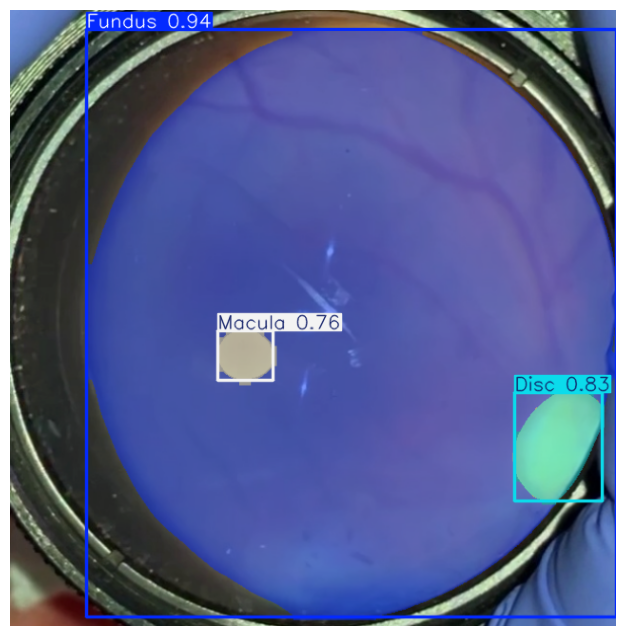

セグメンテーション結果をマージした画像として保存しました: segmentation_result.jpg
セグメンテーション座標データをテキストファイルに保存しました: segmentation_result.txt


In [6]:
from ultralytics import YOLO
import wget
import cv2
import numpy as np
import matplotlib.pyplot as plt

# モデルが未定義ならロードする
try:
    model  # 変数modelが定義されているか確認
except NameError:
    print("modelが未定義のため、ロードを実行します。")
    model = YOLO(r"C:\Users\ykita\ROP_AI_project\models\yolo11m-seg_1703.pt")

# 推論を実行: YOLOの推論
image_path = r'C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1703_lens\IMG_1703_0774.jpg'
results = model(image_path, save=False)

# セグメンテーション結果をテキストファイルに保存するための関数
def save_segment_to_txt(masks, file_path):
    with open(file_path, 'w') as f:
        for i, mask in enumerate(masks):
            # マスクを2値化して座標を取得
            contours, _ = cv2.findContours(mask.astype(np.uint8), 
                                         cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            
            # 各輪郭の座標を保存
            for contour in contours:
                # 画像サイズで正規化
                normalized_contour = contour.astype(float) / np.array([mask.shape[1], mask.shape[0]])
                # 輪郭の座標を書き込み
                f.write(f"{i} ") # クラスID
                for point in normalized_contour.reshape(-1, 2):
                    f.write(f"{point[0]:.6f} {point[1]:.6f} ")
                f.write("\n")

for r in results:
    # セグメンテーションマスクを取得
    masks = r.masks  # セグメンテーションマスク
    if masks is not None:
        # 結果を画像に描画して表示
        plt.figure(figsize=(12, 8))
        # セグメンテーション結果を含む画像を表示
        plotted_img = r.plot(boxes=True, masks=True)
        plt.imshow(cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # マージした画像を保存
        save_img_path = 'segmentation_result.jpg'
        cv2.imwrite(save_img_path, plotted_img)
        print(f"セグメンテーション結果をマージした画像として保存しました: {save_img_path}")

        # セグメンテーション座標データを保存
        save_txt_path = 'segmentation_result.txt'
        save_segment_to_txt(masks.data.cpu().numpy(), save_txt_path)
        print(f"セグメンテーション座標データをテキストファイルに保存しました: {save_txt_path}")

In [ ]:
#動画出力
from ultralytics import RTDETR
import wget
import cv2
import matplotlib.pyplot as plt

# モデルが未定義ならロードする
model = RTDETR(r"C:\Users\ykita\ROP_AI_project\models\rtdetr-l-1700_1703.pt")
try:
    model  # 変数modelが定義されているか確認
except NameError:
    print("modelが未定義のため、ロードを実行します。")
    model = RTDETR(r"C:\Users\ykita\ROP_AI_project\models\rtdetr-l-1700_1703.pt")

# 推論を実行: YOLOの推論
image_path = r'C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1699\IMG_1699_0025.jpg'
results = model(image_path, save=False)

for r in results:
    boxes = r.boxes  # YOLOv8の場合

    # YOLO形式出力
    for box in boxes:
        cls_id = int(box.cls[0])  # クラスID
        x_center, y_center, width, height = box.xywhn[0]

        # YOLO形式: class x_center y_center width height
        # 小数点以下6桁で出力したい場合
        print(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # 検出結果を画像に描画して表示
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(r.plot(), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # 結果の保存
    #cv2.imwrite('result.jpg', r.plot())

# YOLO形式の推論結果をresult.txtに保存
save_txt_path = 'result.txt'

# YOLO形式の推論結果をテキストファイルに書き込み
with open(save_txt_path, 'w') as f:
    for r in results:
        boxes = r.boxes  # YOLOv8系の出力
        for box in boxes:
            cls_id = int(box.cls[0])  
            x_center, y_center, width, height = box.xywhn[0]
            # YOLO形式: class x_center y_center width height （小数点以下6桁）
            line = f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
            f.write(line)

print(f"YOLO形式の推論結果をテキストファイルに保存しました: {save_txt_path}")


# **Create CVAT annotation dataset**

階層構造
```
archive.zip/
   ├── data.yaml  # configuration file
   ├── train.txt  # list of train subset image paths
   │
   ├── train/
   │   ├── images/  # directory with images for train subset
   │   │    ├── image1.jpg
   │   │    ├── image2.jpg
   │   │    └── image3.jpg
   |   └── labels/
   |        │── image1.txt
   │        ├── image2.txt
   │        └── ...
   |
   ├── val/
       ├── images/  # directory with images for validation subset
       │    ├── image10.jpg
       │    ├── image11.jpg
       │    └── image12.jpg
       └── labels/
            │── image10.txt
            ├── image11.txt
            └── ...
```

***.txt (ラベル)
```
0 0.260745 0.535950 0.218015 0.030600
1 0.760795 0.533850 0.213035 0.043800
```

daya.yaml
```
names:
  0: Lens
path: .
train: train.txt
```

train.txt
```
data/images/train/***.jpg
data/images/train/***.jpg
...(pathの羅列。拡張子を合わせる)
```
※ラベルや画像と対応を合わせること



In [ ]:
import os
import glob
import shutil
from tqdm import tqdm
from ultralytics import RTDETR

def create_yolo_dataset(orig_image_dir, output_dir, model_path):
    """
    YOLOデータセットの構造を作成する
    
    Args:
        orig_image_dir: 元の画像が存在するディレクトリ
        output_dir: 出力先のディレクトリ
        model_path: RTDETRモデルのパス
    """
    # 進捗バーの設定
    progress = tqdm(
        total=4,  
        desc="データセット作成",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )

    # 必要なディレクトリを作成
    os.makedirs(os.path.join(output_dir, "labels", "train"), exist_ok=True)
    progress.update(1)
    
    # data.yamlの作成
    yaml_content = """names:
  0: Lens
path: .
train: train.txt"""
    
    with open(os.path.join(output_dir, "data.yaml"), 'w', encoding='utf-8') as f:
        f.write(yaml_content)
    progress.update(1)
    
    # モデルのロード
    try:
        model = RTDETR(model_path)
    except Exception as e:
        print(f"モデルのロードに失敗: {e}")
        return
    
    # 画像ファイルのリストを取得
    image_files = []
    extensions = ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG', '*.tif', '*.TIF', '*.tiff', '*.TIFF']
    
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(orig_image_dir, ext)))
    
    total_files = len(image_files)
    print(f"\n合計 {total_files} 個のファイルが見つかりました")
    
    # 推論とラベル生成の進捗バー
    inference_progress = tqdm(
        total=total_files,
        desc="推論とラベル生成",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )
    
    # train.txtの作成とラベルファイルの生成
    with open(os.path.join(output_dir, "train.txt"), 'w', encoding='utf-8') as f:
        for image_path in image_files:
            # 元の拡張子を保持
            basename = os.path.basename(image_path)
            name_without_ext = os.path.splitext(basename)[0]
            
            # 推論を実行
            results = model(image_path, save=False)
            
            # ラベルファイルのパス（train/配下に.txt）
            label_path = os.path.join(output_dir, "labels", "train", f"{name_without_ext}.txt")
            
            # YOLO形式の推論結果をテキストファイルに書き込み
            with open(label_path, 'w', encoding='utf-8') as lf:
                for r in results:
                    boxes = r.boxes
                    for box in boxes:
                        cls_id = int(box.cls[0])
                        x_center, y_center, width, height = box.xywhn[0]
                        line = f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
                        lf.write(line)
            
            # train.txtにYOLOフォーマットのパスを書き込み
            yolo_path = f"data/images/train/{basename}"
            f.write(f"{yolo_path}\n")
            inference_progress.update(1)
    
    inference_progress.close()
    progress.update(1)
    
    # ZIP圧縮
    print("\nZIP圧縮を開始します...")
    zip_path = output_dir + ".zip"
    total = sum(len(files) for _, _, files in os.walk(output_dir))
    
    with tqdm(total=total, desc="ZIP圧縮", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
        for root, _, files in os.walk(output_dir):
            for file in files:
                pbar.update(1)
        shutil.make_archive(os.path.splitext(zip_path)[0], 'zip', output_dir)
    
    progress.update(1)
    progress.close()
    print(f"\nフォルダを {zip_path} に圧縮しました。")

# 使用例
if __name__ == "__main__":
    orig_image_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1699"
    output_dir = r"C:\Users\ykita\ROP_AI_project\inference\IMG_1699\archive"
    model_path = r"C:\Users\ykita\ROP_AI_project\models\rtdetr-l-1699_1703.pt"
    
    create_yolo_dataset(orig_image_dir, output_dir, model_path)

# **Extract bounding box**

In [10]:
import os
import cv2
import glob
from tqdm import tqdm
import shutil

def create_directory_if_not_exists(directory):
    """指定されたディレクトリが存在しない場合、作成する"""
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)
    print(f"ディレクトリを作成しました: {directory}")

def read_bounding_box(label_path):
    """YOLOフォーマットのラベルファイルからバウンディングボックス情報を読み取る"""
    with open(label_path, 'r') as f:
        # 最初の行のみ読み取る（1つのバウンディングボックスのみ）
        line = f.readline().strip()
        if line:
            # YOLOフォーマット: class x_center y_center width height
            parts = line.split()
            if len(parts) == 5:
                return [float(x) for x in parts[1:]]  # クラスIDは除外
    return None

def crop_image(image_path, label_path, output_path):
    """画像をバウンディングボックスに従って切り抜く"""
    # 画像を読み込む
    image = cv2.imread(image_path)
    if image is None:
        print(f"画像の読み込みに失敗しました: {image_path}")
        return False
    
    # 画像の寸法を取得
    height, width = image.shape[:2]
    
    # バウンディングボックス情報を読み取る
    bbox = read_bounding_box(label_path)
    if bbox is None:
        print(f"ラベルの読み取りに失敗しました: {label_path}")
        return False
    
    # YOLOフォーマット（正規化された座標）から実際の座標に変換
    x_center, y_center, w, h = bbox
    x_center *= width
    y_center *= height
    w *= width
    h *= height
    
    # バウンディングボックスの座標を計算
    x1 = int(x_center - w/2)
    y1 = int(y_center - h/2)
    x2 = int(x_center + w/2)
    y2 = int(y_center + h/2)
    
    # 座標が画像の範囲内に収まるようにクリップ
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(width, x2)
    y2 = min(height, y2)
    
    # 画像を切り抜く
    cropped_image = image[y1:y2, x1:x2]
    
    # 切り抜いた画像を保存
    cv2.imwrite(output_path, cropped_image)
    return True

def main():
    # 出力ディレクトリを作成
    create_directory_if_not_exists(output_dir)
    
    # 元画像ディレクトリ内の画像ファイルを取得
    image_files = glob.glob(os.path.join(orig_image_dir, "*.*"))
    
    # 画像ファイルごとに処理
    processed_count = 0
    error_count = 0
    
    # tqdmで進捗バーを表示
    for image_path in tqdm(image_files, desc="画像処理中", unit="枚"):
        # ファイル名（拡張子なし）を取得
        basename = os.path.splitext(os.path.basename(image_path))[0]
        
        # 対応するラベルファイルのパスを作成
        label_path = os.path.join(label_dir, f"{basename}.txt")
        
        # 出力ファイルのパスを作成（元の拡張子を維持）
        output_path = os.path.join(output_dir, os.path.basename(image_path))
        
        # ラベルファイルが存在するか確認
        if not os.path.exists(label_path):
            print(f"ラベルファイルが見つかりません: {label_path}")
            error_count += 1
            continue
        
        # 画像を切り抜いて保存
        if crop_image(image_path, label_path, output_path):
            processed_count += 1
        else:
            error_count += 1
    
    print(f"\n処理完了:")
    print(f"- 成功: {processed_count}枚")
    print(f"- エラー: {error_count}枚")
    print(f"- 合計: {len(image_files)}枚")

if __name__ == "__main__":
    orig_image_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1700"
    output_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1700_lens"
    label_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700"

    main()

ディレクトリを作成しました: C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1700_lens


画像処理中:   0%|          | 6/1607 [00:00<00:29, 54.81枚/s]

ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_0003.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_0006.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_0007.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_0008.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_0009.txt


画像処理中:  99%|█████████▊| 1585/1607 [00:52<00:00, 50.08枚/s]

ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1575.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1576.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1577.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1578.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1579.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1580.txt


画像処理中: 100%|██████████| 1607/1607 [00:52<00:00, 30.59枚/s]

ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1593.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1594.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1595.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1596.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1597.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1598.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1599.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1600.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1601.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1602.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1603.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_proj

# **※FacePhoto_instance用**

In [ ]:
import os
import glob
import shutil
from tqdm import tqdm
from ultralytics import RTDETR

def create_yolo_dataset(orig_image_dir, output_dir, model_path):
    """
    YOLOデータセットの構造を作成する
    
    Args:
        orig_image_dir: 元の画像が存在するディレクトリ
        output_dir: 出力先のディレクトリ
        model_path: RTDETRモデルのパス
    """
    # 進捗バーの設定
    progress = tqdm(
        total=4,  
        desc="データセット作成",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )

    # 必要なディレクトリを作成
    os.makedirs(os.path.join(output_dir, "labels", "train"), exist_ok=True)
    progress.update(1)
    
    # data.yamlの作成
    yaml_content = """names:
  0: Right_eye
  1: Left_eye
path: .
train: train.txt"""
    
    with open(os.path.join(output_dir, "data.yaml"), 'w', encoding='utf-8') as f:
        f.write(yaml_content)
    progress.update(1)
    
    # モデルのロード
    try:
        model = RTDETR(model_path)
    except Exception as e:
        print(f"モデルのロードに失敗: {e}")
        return
    
    # 画像ファイルのリストを取得
    image_files = []
    extensions = ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG', '*.tif', '*.TIF', '*.tiff', '*.TIFF']
    
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(orig_image_dir, ext)))
    
    total_files = len(image_files)
    print(f"\n合計 {total_files} 個のファイルが見つかりました")
    
    # 推論とラベル生成の進捗バー
    inference_progress = tqdm(
        total=total_files,
        desc="推論とラベル生成",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )
    
    # train.txtの作成とラベルファイルの生成
    with open(os.path.join(output_dir, "train.txt"), 'w', encoding='utf-8') as f:
        for image_path in image_files:
            # 元の拡張子を保持
            basename = os.path.basename(image_path)
            name_without_ext = os.path.splitext(basename)[0]
            
            # 推論を実行
            results = model(image_path, save=False)
            
            # ラベルファイルのパス（train/配下に.txt）
            label_path = os.path.join(output_dir, "labels", "train", f"{name_without_ext}.txt")
            
            # YOLO形式の推論結果をテキストファイルに書き込み
            with open(label_path, 'w', encoding='utf-8') as lf:
                for r in results:
                    boxes = r.boxes
                    for box in boxes:
                        cls_id = int(box.cls[0])
                        x_center, y_center, width, height = box.xywhn[0]
                        line = f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
                        lf.write(line)
            
            # train.txtにYOLOフォーマットのパスを書き込み
            yolo_path = f"data/images/train/{basename}"
            f.write(f"{yolo_path}\n")
            inference_progress.update(1)
    
    inference_progress.close()
    progress.update(1)
    
    # ZIP圧縮
    print("\nZIP圧縮を開始します...")
    zip_path = output_dir + ".zip"
    total = sum(len(files) for _, _, files in os.walk(output_dir))
    
    with tqdm(total=total, desc="ZIP圧縮", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
        for root, _, files in os.walk(output_dir):
            for file in files:
                pbar.update(1)
        shutil.make_archive(os.path.splitext(zip_path)[0], 'zip', output_dir)
    
    progress.update(1)
    progress.close()
    print(f"\nフォルダを {zip_path} に圧縮しました。")

# 使用例
if __name__ == "__main__":
    orig_image_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1699"
    output_dir = r"C:\Users\ykita\ROP_AI_project\inference\IMG_1699\archive"
    model_path = r"C:\Users\ykita\ROP_AI_project\models\rtdetr-l-1700_1703.pt"
    
    create_yolo_dataset(orig_image_dir, output_dir, model_path)

In [18]:
import os
import glob
from ultralytics import RTDETR
from tqdm import tqdm  # tqdmライブラリをインポート

# 1) 画像のフォルダを指定する
orig_image_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\image"
# 2) 出力先のフォルダを指定する。フォルダがなければ作成する
dst_parent_dir= r"C:\Users\ykita\FacePhoto_instance\inference\201-295\archive" #####
dst_label_dir = os.path.join(dst_parent_dir, "labels", "train")
os.makedirs(dst_label_dir, exist_ok=True)

# モデルが未定義ならロードする
try:
    model  # 変数modelが定義されているか確認
except NameError:
    print("modelが未定義のため、ロードを実行します。")
    model_path = r"C:\Users\ykita\FacePhoto_instance\models\135best_rtdetr.pt"
    model = RTDETR(model_path)

# 処理対象とする画像の拡張子
image_extensions = [
    '.jpg', '.jpeg', '.JPG', '.JPEG',
    '.png', '.PNG',
    '.tif', '.tiff', '.TIF', '.TIFF'
]

# 指定フォルダ配下の該当画像ファイルをすべて取得
image_files = []
for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(orig_image_dir, f'*{ext}')))

# tqdmで進捗状況を表示しながらループ
for image_path in tqdm(image_files, desc='推論中', unit='枚'):
    # 推論を実行
    results = model(image_path, save=False)

    # 画像と同じファイル名（拡張子を除く）でテキストファイル出力
    basename = os.path.splitext(os.path.basename(image_path))[0]
    save_txt_path = os.path.join(dst_label_dir, f"{basename}.txt")

    # YOLO形式の推論結果をテキストファイルに書き込み
    with open(save_txt_path, 'w', encoding='utf-8') as f:
        for r in results:
            boxes = r.boxes  # YOLOv8系の出力
            for box in boxes:
                cls_id = int(box.cls[0])
                x_center, y_center, width, height = box.xywhn[0]
                # YOLO形式: class x_center y_center width height（小数点以下6桁）
                line = f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
                f.write(line)

print("すべての画像に対する推論が完了し、YOLO形式でラベルを出力しました。")


推論中:   0%|          | 0/1390 [00:00<?, ?枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_024df9c564e854ac63c356338fae68d7e8ebd20fafde2856d07f854576d25bec.JPG: 640x640 1 Right_eye, 1 Left_eye, 1269.3ms
Speed: 42.0ms preprocess, 1269.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


推論中:   0%|          | 1/1390 [00:01<32:57,  1.42s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_11ecdb1214665a16b19b0289b20c71d2c5a5a325f974312963bd044ddd10932f.JPG: 640x640 1 Right_eye, 1 Left_eye, 784.6ms
Speed: 7.1ms preprocess, 784.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   0%|          | 2/1390 [00:02<24:56,  1.08s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_50a5a27bf14844c0973f0c274e935b2766ef37d438492d264e490a1e2dcaf11b.JPG: 640x640 1 Right_eye, 1 Left_eye, 758.5ms
Speed: 7.1ms preprocess, 758.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   0%|          | 3/1390 [00:03<22:05,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_5775015e20cdb44f407ce9d908414403051f7b938d0f5ad519811a243418f9df.JPG: 640x640 1 Right_eye, 1 Left_eye, 749.5ms
Speed: 7.7ms preprocess, 749.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   0%|          | 4/1390 [00:03<20:50,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_7a191e64370164f70f9a201e7392ea3630707c93f7cbc5b724279b7f1811136b.JPG: 640x640 1 Right_eye, 1 Left_eye, 756.5ms
Speed: 10.1ms preprocess, 756.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   0%|          | 5/1390 [00:04<20:03,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_9f5db5050c8e588fd55bb35d4b116533f3c157f6eeb9369a51e3b004ffc96f00.JPG: 640x640 2 Left_eyes, 744.4ms
Speed: 7.6ms preprocess, 744.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   0%|          | 6/1390 [00:05<19:27,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_aad77ff1d9e3857a248a9e77b19c567776cd17c1605eb41bde3391ff46733fbe.JPG: 640x640 1 Right_eye, 1 Left_eye, 757.3ms
Speed: 6.1ms preprocess, 757.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 7/1390 [00:06<19:13,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_ae7df7fa888a812f77940366dc0ee3ca7960eedd8e09f05e7e7db1a1a8edbf87.JPG: 640x640 1 Right_eye, 1 Left_eye, 751.3ms
Speed: 5.6ms preprocess, 751.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 8/1390 [00:07<18:57,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_afcc6f5ceeb58e835c5c8b0eaad7e2dc831d84416bdb548db95b9df00761b4c6.JPG: 640x640 1 Right_eye, 1 Left_eye, 751.6ms
Speed: 8.6ms preprocess, 751.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 9/1390 [00:07<18:50,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20080129-9-113451_cd22e2f6687375e46aaa926d7c2df4ec20e829d4728ba0bbbb81b62e28e3145c.JPG: 640x640 1 Right_eye, 1 Left_eye, 816.9ms
Speed: 8.2ms preprocess, 816.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 10/1390 [00:08<19:11,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\202-20110908-67-000000_3474eb6af187c2eb6e67a075c6ca7d8582e3053d9aadd0bcffa191d07cd14e8e.jpg: 640x640 2 Right_eyes, 1023.0ms
Speed: 8.3ms preprocess, 1023.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 11/1390 [00:09<20:49,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\202-20110916-67-000000_607d107cfc96d9137aa5fdf3960a8046d746e90323bf22c97d24b73ca24e76d6.jpg: 640x640 1 Right_eye, 1 Left_eye, 959.5ms
Speed: 10.6ms preprocess, 959.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 12/1390 [00:11<22:35,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\203-20181114-1-104445_3ac43ba46182948796e96015d2ba3afb3a5651b05a6ab7d571079ebcd4ad370b.jpg: 640x640 1 Right_eye, 1 Left_eye, 1037.5ms
Speed: 14.2ms preprocess, 1037.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 13/1390 [00:12<24:30,  1.07s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120823-59-095005_bb9680608ade3628a781b349770762db12e3d707e110fb640e4d4e9b182e8f5e.jpg: 640x640 1 Right_eye, 1 Left_eye, 983.4ms
Speed: 6.0ms preprocess, 983.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 14/1390 [00:13<25:27,  1.11s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_1445850d9e02c3c7c3578477d71043e854e041c9f676b1ee94c45ac934d3d23c.jpg: 640x640 1 Right_eye, 1 Left_eye, 969.7ms
Speed: 7.5ms preprocess, 969.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 15/1390 [00:14<26:04,  1.14s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_1ede8a659af9b5c4cbf930f0ac282d86f088781ed471d444fe8e995c7a71d721.jpg: 640x640 2 Left_eyes, 931.1ms
Speed: 12.0ms preprocess, 931.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 16/1390 [00:15<26:03,  1.14s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_429511617d3fbe993694a39a01d0e090fbb22290467d4d2e2389076111a9b478.jpg: 640x640 1 Right_eye, 1 Left_eye, 922.3ms
Speed: 7.1ms preprocess, 922.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 17/1390 [00:16<25:53,  1.13s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_5110b4f5b339b0463da88b97be1cc28aae981c4d2ae17007035899d1fc9fac4a.jpg: 640x640 1 Right_eye, 1 Left_eye, 973.2ms
Speed: 9.6ms preprocess, 973.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|▏         | 18/1390 [00:18<26:20,  1.15s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_5417d937e94e2aa1c252d9a4f9fe38604d6551499f3ea0e60aaddb80cb001082.jpg: 640x640 1 Right_eye, 1 Left_eye, 820.3ms
Speed: 11.5ms preprocess, 820.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|▏         | 19/1390 [00:19<25:32,  1.12s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_556a54779616eae2bd980c59cde8c3c3fdcdd5ce25b9ae6b7652d77ee00bfe64.jpg: 640x640 1 Right_eye, 1 Left_eye, 934.4ms
Speed: 11.3ms preprocess, 934.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|▏         | 20/1390 [00:20<25:38,  1.12s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_7436be9ffad3f6a18d9da24376a47fd0755336c42b0ac3f88cab90be9d568e6b.jpg: 640x640 1 Right_eye, 1 Left_eye, 943.2ms
Speed: 7.6ms preprocess, 943.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 21/1390 [00:21<26:24,  1.16s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_9467370d31b329335821e21ae141bf56ab560f0744c3ab18a593b5767906dc12.jpg: 640x640 2 Right_eyes, 1 Left_eye, 785.6ms
Speed: 7.1ms preprocess, 785.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 22/1390 [00:22<25:15,  1.11s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_b2faa4af78651e56eede786e0565a7f105a7e8406c42997cf5d3c45cbe6f5773.jpg: 640x640 1 Right_eye, 1 Left_eye, 763.7ms
Speed: 8.1ms preprocess, 763.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 23/1390 [00:23<24:22,  1.07s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_e1ed45c495418b43857bac1bf6d3c731676534823cdd31ecc22aa18932c59669.jpg: 640x640 1 Right_eye, 1 Left_eye, 774.2ms
Speed: 7.5ms preprocess, 774.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 24/1390 [00:24<23:45,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20121018-59-113652_ad00884a9ea863eb2ad97b1c81ba5fb7e17956f23e46d761c4e990c731258dae.jpg: 640x640 1 Right_eye, 1 Left_eye, 781.5ms
Speed: 6.1ms preprocess, 781.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 25/1390 [00:25<23:19,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\205-20130717-0-102938_98fc798e352707c2183d114c754ebb9001ccd45d06057484b41d1839fd99ad77.jpg: 640x640 1 Right_eye, 1 Left_eye, 778.7ms
Speed: 7.1ms preprocess, 778.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 26/1390 [00:26<22:15,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170222-41-104248_6a8bf220ed15b183685305d20bdb79f4a12a8516daaf9210df3e784052ae56f6.jpg: 640x640 2 Left_eyes, 979.1ms
Speed: 12.3ms preprocess, 979.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 27/1390 [00:27<22:57,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170222-41-104248_f5eeeff6e0503e1a62962242c1cb202b2fbb5d007d6169ec205fe17e5a1430f6.jpg: 640x640 1 Right_eye, 1 Left_eye, 946.1ms
Speed: 9.1ms preprocess, 946.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 28/1390 [00:28<23:16,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-110317_05f18822d85e77bc85a2a97a97fd3d2d711b62db3c09665de13579512c7765de.jpg: 640x640 1 Right_eye, 1 Left_eye, 780.9ms
Speed: 9.7ms preprocess, 780.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 29/1390 [00:29<22:07,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-110317_082eb4a3e1e81bdf4b5c2b28d583b9d78d4af6c27b8008d1cfc65e08f1e8d658.jpg: 640x640 1 Right_eye, 1 Left_eye, 780.0ms
Speed: 7.5ms preprocess, 780.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 30/1390 [00:30<21:19,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-110317_6ce4f9c66f653c75725493c81613d0792221048dec1282ce4ffd526194b74595.jpg: 640x640 1 Right_eye, 2 Left_eyes, 954.4ms
Speed: 10.1ms preprocess, 954.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 31/1390 [00:31<21:54,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-141035_b6b81256f005dca6949a34f725cbe39ad5465671f32533962e200ab02e2b595e.jpg: 640x640 1 Right_eye, 1 Left_eye, 966.9ms
Speed: 7.7ms preprocess, 966.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 32/1390 [00:32<22:24,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-141035_c18ab23f5650ebb577754a93a46f5a14867b2622d22dca3d851a40ced8d064e8.jpg: 640x640 1 Right_eye, 1 Left_eye, 1031.4ms
Speed: 6.5ms preprocess, 1031.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 33/1390 [00:33<23:13,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170719-41-131937_186fece0b4bf9c8d951cc7876b38998d46f5b80e3ee5d27601579efc845028e3.jpg: 640x640 1 Right_eye, 1 Left_eye, 842.5ms
Speed: 5.8ms preprocess, 842.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 34/1390 [00:34<22:27,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\207-20120726-71-113947_63d7786bf09e9fd187213afd8f4a9bf4f6d2c34debc63f34a787364d056d76c1.jpg: 640x640 1 Right_eye, 1 Left_eye, 931.4ms
Speed: 11.5ms preprocess, 931.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 35/1390 [00:35<23:23,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\207-20121122-71-114614_124b58d81e3e3affd461e53ddc3d2dce08e62b1b374d6f56d5f4996186e0d159.jpg: 640x640 1 Right_eye, 2 Left_eyes, 801.4ms
Speed: 8.6ms preprocess, 801.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 36/1390 [00:36<23:11,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-110017_46b2222712656e5917d5a8398b1566498344648a8a9cd939e34730506aa2d177.jpg: 640x640 1 Right_eye, 1 Left_eye, 952.0ms
Speed: 8.1ms preprocess, 952.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 37/1390 [00:37<23:05,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-110017_49f1b92ac1f275f96287a2f1064a813aa7823e7e4f3a2c1cdef6697e30ba82e2.jpg: 640x640 1 Right_eye, 1 Left_eye, 834.0ms
Speed: 4.0ms preprocess, 834.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 38/1390 [00:38<22:20,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-110017_5b15e4fee069de9ae8ef831012d9d38d10beb7b2305e4fae34fb7e3e9f33c0a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 802.1ms
Speed: 10.0ms preprocess, 802.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 39/1390 [00:39<21:32,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_2a28f835ba096a7cdab954b9c2911ad4a457c3689005d971692304d86687d241.jpg: 640x640 2 Left_eyes, 815.9ms
Speed: 7.6ms preprocess, 815.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 40/1390 [00:40<21:03,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_6ba19f9ecb4788f8994f97b116304d7cb286ae7702fa74a5277009e92b48821b.jpg: 640x640 1 Right_eye, 1 Left_eye, 791.9ms
Speed: 8.6ms preprocess, 791.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 41/1390 [00:41<20:32,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_766637013b819c52f519491b971ef1db67e7e139aec23540ddad7333ba2f9930.jpg: 640x640 1 Right_eye, 1 Left_eye, 981.1ms
Speed: 6.1ms preprocess, 981.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 42/1390 [00:42<21:25,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_88aacbd638c82ae84b3324a89ecf9f68dc2a255dead5cc16384324c299858ae3.jpg: 640x640 1 Right_eye, 2 Left_eyes, 908.3ms
Speed: 6.2ms preprocess, 908.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 43/1390 [00:43<21:32,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_c15ff66468a71becff74f0a812297e26ac4c26468bc097dfd3ee8b5282f5ae1f.jpg: 640x640 1 Right_eye, 1 Left_eye, 850.0ms
Speed: 6.1ms preprocess, 850.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 44/1390 [00:43<21:16,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_d0f1a14c6883d8ac2106959d10da31c83c374b6722aefeb152783331b1eba211.jpg: 640x640 2 Left_eyes, 767.9ms
Speed: 9.1ms preprocess, 767.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 45/1390 [00:44<20:30,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_e5eff653afe42c531d11a26ba17533cf95c6212c4feaa7e7bb0816deb0e478c2.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.5ms
Speed: 6.4ms preprocess, 725.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 46/1390 [00:45<19:41,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_ec0b571343a4943fb5ab7eb05153591b6dffa2d1e82ffe3c2935bf946a3f0043.jpg: 640x640 1 Right_eye, 2 Left_eyes, 726.3ms
Speed: 5.1ms preprocess, 726.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 47/1390 [00:46<19:03,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_fa4302b9409ab6b2d07bfb2040b4e4c597d9ad0317c40d90c3689fd98a359bfc.jpg: 640x640 1 Right_eye, 1 Left_eye, 866.0ms
Speed: 6.1ms preprocess, 866.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 48/1390 [00:47<19:31,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_014c345ec75e08fd5e3af8041a745338ebe9d53e06523f33948c9eb1ff7e0e92.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.4ms
Speed: 5.4ms preprocess, 720.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▎         | 49/1390 [00:48<19:00,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_04e2d7afefa163ecc6aaf5b69286fcc461a9e80ef611c43abe9be547b4643937.jpg: 640x640 3 Right_eyes, 1 Left_eye, 704.7ms
Speed: 6.1ms preprocess, 704.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▎         | 50/1390 [00:48<18:25,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_05f1a832521617358c4304dee5bf0d4a31616ed87cb22e00bb5963542f595246.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.2ms
Speed: 5.5ms preprocess, 720.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▎         | 51/1390 [00:49<18:09,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_1e59db913b23521d22ce7cfe52fd963bddb4730cca9f4ffacdb73bf1a41fd5c2.jpg: 640x640 2 Left_eyes, 707.5ms
Speed: 6.1ms preprocess, 707.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▎         | 52/1390 [00:50<17:54,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_2b11502e29472312e45862853b35ff1070196353921d1ac433ed9e163bc8691d.jpg: 640x640 1 Right_eye, 1 Left_eye, 747.3ms
Speed: 5.6ms preprocess, 747.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 53/1390 [00:51<17:56,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_3eb5d82e7293bcab7f73c5be986e30620ee8ec79d459ec61f5e06fab14533ff7.jpg: 640x640 1 Right_eye, 1 Left_eye, 772.1ms
Speed: 5.7ms preprocess, 772.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 54/1390 [00:52<18:13,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_5c8e3b695f7184965b8d580c0452588beddbf080d6d80c08ab3ed3e3e087e1ea.jpg: 640x640 3 Right_eyes, 1 Left_eye, 748.0ms
Speed: 7.3ms preprocess, 748.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 55/1390 [00:52<18:09,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_74b098cf225e39691f32614ebeb18d62656852105bf0260b26fe4c436bf8ecb7.jpg: 640x640 2 Left_eyes, 723.9ms
Speed: 6.3ms preprocess, 723.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 56/1390 [00:53<17:55,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_9804be9571f80504de5ae6e4a98a268885921a07fb1124682801fcdf4c066aae.jpg: 640x640 2 Left_eyes, 705.0ms
Speed: 6.5ms preprocess, 705.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 57/1390 [00:54<17:43,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_d5de0e290f5b8f7ae0f92b51463bda63c8ec1aa3fbfeaa78216f5e4a42664495.jpg: 640x640 3 Left_eyes, 712.7ms
Speed: 5.0ms preprocess, 712.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 58/1390 [00:55<17:32,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_e2b89c52bcfdca5daeec6065504dad0947d18c1038d03ddb71d43991af115368.jpg: 640x640 2 Left_eyes, 707.8ms
Speed: 6.6ms preprocess, 707.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 59/1390 [00:56<17:26,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_e6aadf83f9986309209ce0a1d2119d71b7d944724719d881120980549299e566.jpg: 640x640 1 Right_eye, 3 Left_eyes, 705.7ms
Speed: 4.3ms preprocess, 705.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 60/1390 [00:56<17:20,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_f7cded9a806459f235e706aca11ccc00cf0e386281562f632c974cfde3fa3178.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.4ms
Speed: 5.0ms preprocess, 715.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 61/1390 [00:57<17:25,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170831-76-133629_be516d5fcb1676f57e27dd34dcf69b59d1f631df0e99fb2b4523a89e6f920c10.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.8ms
Speed: 4.6ms preprocess, 712.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 62/1390 [00:58<17:22,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170831-76-133629_d3be1e0385d8df30cfda70348a9a6d3847692c3521886ef92fa0f7f0b63fb360.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.1ms
Speed: 4.0ms preprocess, 712.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▍         | 63/1390 [00:59<17:13,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170928-76-134136_c7d87cf7d78f2ea088e5af1373cf637713971856c4711d08e93029dad7c86017.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.6ms
Speed: 7.0ms preprocess, 725.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▍         | 64/1390 [00:59<17:16,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-135145_1590096e4fff9e1003137d616f4b0a61498279f3b785dabfdafb5bcef720bada.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.6ms
Speed: 6.0ms preprocess, 719.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▍         | 65/1390 [01:00<17:30,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-135145_467c8188feade8ad0d5e77a620b4c31f53fc26595bb8c21a044dec33bf0e55dc.jpg: 640x640 1 Right_eye, 1 Left_eye, 734.9ms
Speed: 4.5ms preprocess, 734.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▍         | 66/1390 [01:01<17:40,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-135751_80a7fe3db5a4a8f112acc0a0a2007d4827ae7c17ce486199a05a8ecdab0b03e7.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.7ms
Speed: 6.1ms preprocess, 720.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▍         | 67/1390 [01:02<17:42,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-140322_ddeb8e0ba152289e85ba4c5df3b579fa9c4f33e19ab036def2d225d757f8ba89.jpg: 640x640 1 Right_eye, 1 Left_eye, 701.2ms
Speed: 5.7ms preprocess, 701.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▍         | 68/1390 [01:03<17:37,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-140322_f9f9498fd2a1246968bbc319f7accdc8b6917b4dff5b17ddae06a96dda58a761.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.2ms
Speed: 6.1ms preprocess, 720.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▍         | 69/1390 [01:03<17:41,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171129-76-155251_9535ebb92f2043991656a8f3d89a9d49a65d1ac074d25687c56a056078d6e83a.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.8ms
Speed: 5.0ms preprocess, 717.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▌         | 70/1390 [01:04<17:31,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_008c389e801e5defb5694f06567c2311095da59549db28eee108317d02ee5a41.jpg: 640x640 1 Right_eye, 1 Left_eye, 931.4ms
Speed: 5.1ms preprocess, 931.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▌         | 71/1390 [01:05<18:52,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_0eb9512cf2af8702d9244f1701e89f1e13538ab3d06dfd0cb21a6d5716547743.jpg: 640x640 2 Left_eyes, 828.2ms
Speed: 8.7ms preprocess, 828.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▌         | 72/1390 [01:06<19:08,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_647dd67d1f7d270b80b7c5f6f9e70e5cf0c581cb676ef615751370b16af5d5f4.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.8ms
Speed: 7.7ms preprocess, 732.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▌         | 73/1390 [01:07<18:36,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_94fb25b64cf346e434a9de720ce529a2a34441295be2f4c0395c3fd4e0544bec.jpg: 640x640 1 Right_eye, 1 Left_eye, 729.2ms
Speed: 5.2ms preprocess, 729.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▌         | 74/1390 [01:08<18:15,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_ae47f698f9e9255031397216da99da85567c62e03ec722697a24864adcdca7e5.jpg: 640x640 1 Right_eye, 1 Left_eye, 886.5ms
Speed: 7.0ms preprocess, 886.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▌         | 75/1390 [01:09<19:00,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_b3136f21adb2b3100d6b482e32df67f4a2c926a0670f0eee654dcf5c63239f2b.jpg: 640x640 1 Right_eye, 1 Left_eye, 950.9ms
Speed: 9.2ms preprocess, 950.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▌         | 76/1390 [01:10<20:07,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_c2a3d3c65ee5709af5794ef67bf7e9de87cdcf127828f75966232578046a75e2.jpg: 640x640 1 Right_eye, 1 Left_eye, 800.0ms
Speed: 7.1ms preprocess, 800.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 77/1390 [01:11<19:48,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_c440a7326af0d9b2d3c9aa170e7684aabc28891a92df0d4bf8ee0c807480460b.jpg: 640x640 2 Left_eyes, 765.0ms
Speed: 5.0ms preprocess, 765.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 78/1390 [01:11<19:20,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_daf8c856aab84098ac89925f1fd2a94f7a3379eef8e7797fcd2d1eb7b9949e6d.jpg: 640x640 1 Right_eye, 1 Left_eye, 870.8ms
Speed: 6.1ms preprocess, 870.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 79/1390 [01:12<19:41,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-150345_1cb2fe3dfa9dcc77e559f7db4e042fa0803a1ba6d47a9a9075ef3e9f663b06a6.jpg: 640x640 1 Right_eye, 1 Left_eye, 757.8ms
Speed: 6.1ms preprocess, 757.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 80/1390 [01:13<19:12,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180222-76-135523_96329248c51b18267f010b7acc6494b53bd95f150ab5ead013c5dbfebfd7c715.jpg: 640x640 1 Right_eye, 1 Left_eye, 750.2ms
Speed: 8.2ms preprocess, 750.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 81/1390 [01:14<18:47,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180222-76-135523_d63f22ada48f6af594f26e5eef5d5739ef747681c5ab477e50291b1f2fdc5e44.jpg: 640x640 1 Right_eye, 1 Left_eye, 746.2ms
Speed: 6.5ms preprocess, 746.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 82/1390 [01:15<18:29,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180322-76-115453_db293e1ed974a4e3424d27e0812f4031a8b1444afde0cebbc0d4a70619f8fdf5.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.6ms
Speed: 6.6ms preprocess, 715.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 83/1390 [01:16<18:04,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180510-76-105914_b1eb5f07996e825df653c99413c08f1daa6409cd1766746c3b94e8c992e6b56a.jpg: 640x640 2 Left_eyes, 713.6ms
Speed: 6.1ms preprocess, 713.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 84/1390 [01:16<17:53,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180823-77-105619_2c58cf58e0e5e05a39e752d0b887f5d0f0a853db497e5911130c26fd8e2fc06f.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.2ms
Speed: 7.1ms preprocess, 716.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 85/1390 [01:17<17:44,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180823-77-105619_3bb55a936a62fbb388420006abfff8c45ab8f068fb47adf5df51655444d90867.jpg: 640x640 1 Right_eye, 1 Left_eye, 704.1ms
Speed: 6.0ms preprocess, 704.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 86/1390 [01:18<17:39,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20190110-77-115506_db2eb066cdaee43bf93de25e9f07ccf54be62d9690992e94ca508dc95a34e10d.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.0ms
Speed: 6.1ms preprocess, 718.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▋         | 87/1390 [01:19<17:36,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_0b48e1ad4eb95d92f906dbe10bd368237d22e7c8690419142f85fa3340bfe9a8.jpg: 640x640 1 Right_eye, 1 Left_eye, 755.1ms
Speed: 6.3ms preprocess, 755.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▋         | 88/1390 [01:20<17:46,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_4467b14a4b32da2ad5d5b91d5b40ea8e47e4a5a4bebd515555958ef9d8a16f0d.jpg: 640x640 1 Right_eye, 1 Left_eye, 742.7ms
Speed: 6.0ms preprocess, 742.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▋         | 89/1390 [01:20<17:39,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_48fa4a09dd8c812af61501d6918037f136057cd946f777fb1f95be2e4ded51b8.jpg: 640x640 1 Right_eye, 2 Left_eyes, 723.4ms
Speed: 6.6ms preprocess, 723.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▋         | 90/1390 [01:21<17:27,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_568bced5b8a94b71f9e34b7c30ded2ecf7ef7558ee3c94e88bb417da4605ec05.jpg: 640x640 1 Right_eye, 2 Left_eyes, 725.4ms
Speed: 5.6ms preprocess, 725.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 91/1390 [01:22<17:23,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_5e666bb29641e6a542be74a94df8ffcb2846f7a83250d4c4bcb363110b321685.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.1ms
Speed: 6.3ms preprocess, 709.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 92/1390 [01:23<17:19,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_7d797fba43de2ae321f990a7dbc572217a3d64780a6f4b64f256e692bc673106.jpg: 640x640 1 Right_eye, 1 Left_eye, 706.1ms
Speed: 7.1ms preprocess, 706.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 93/1390 [01:24<17:06,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_8f89feea483d8d7d850d028fd6736cd498a0536f942ddb03362ff3af2756c276.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.5ms
Speed: 7.8ms preprocess, 712.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 94/1390 [01:24<17:05,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_b5f66bc7a70638af867d3eb76fbb7a36c824e7b3dd56725cb77d8dc7061cd22a.jpg: 640x640 1 Right_eye, 1 Left_eye, 726.3ms
Speed: 5.0ms preprocess, 726.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 95/1390 [01:25<17:06,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_d7ea4f644a41b486c17976926344a267148410099fa4de35e0c4936b9ffef46f.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.7ms
Speed: 8.0ms preprocess, 725.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 96/1390 [01:26<17:07,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\210-20130612-75-125110_9e39fd7a2ba5875049ddd668b14eaf11f388edc174496f3810962e36591b9116.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.6ms
Speed: 6.0ms preprocess, 719.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 97/1390 [01:27<17:45,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\211-20170220-33-125321_3fe7c48d9355efa29505d8f9ea788955c49df268240e921255cd4c9de8574ff1.jpg: 640x640 1 Right_eye, 1 Left_eye, 699.4ms
Speed: 5.6ms preprocess, 699.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 98/1390 [01:28<17:23,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\212-20170301-82-110358_3c5ea838abac9353417d40d30b6eef5bff483bfc3ceee326f07a3be6042f059b.jpg: 640x640 1 Right_eye, 2 Left_eyes, 708.6ms
Speed: 7.1ms preprocess, 708.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 99/1390 [01:28<17:13,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\212-20170301-82-110358_44c507c3d5e75be338bafe28cb157ab7fc14bfa230332ce0e0cd2b44bac0e907.jpg: 640x640 (no detections), 692.4ms
Speed: 5.3ms preprocess, 692.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 100/1390 [01:29<17:08,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\212-20170301-82-110358_d8a5776a367ecd156848d2f74f54ef5eead471b8d1a68e22569cf2b3f02c97bc.jpg: 640x640 (no detections), 685.8ms
Speed: 5.0ms preprocess, 685.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 101/1390 [01:30<16:58,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20180926-6-110535_e4cc657ae77b4c8a1d380185614d99e5213918e21023f751e42873809e7ba4c3.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.0ms
Speed: 9.8ms preprocess, 719.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 102/1390 [01:31<17:36,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20180926-6-110535_eb3cf134a04281fd749c2d6b3bbc69e3fddd75981b67904192c648a47d3c9e74.jpg: 640x640 1 Right_eye, 1 Left_eye, 706.3ms
Speed: 6.0ms preprocess, 706.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 103/1390 [01:32<18:01,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20190918-7-104931_7a7d19918ab16765ccbc6d497c0b1d55d4681c7a78fe731c69a171268842cafe.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.1ms
Speed: 7.1ms preprocess, 705.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 104/1390 [01:33<18:21,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20190918-7-104931_9cf441b20356b92ccb3aaf7f0abceb70548a2b9a6b114da7b2e38b23afa904dc.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.6ms
Speed: 6.6ms preprocess, 721.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 105/1390 [01:34<18:38,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20191120-7-111334_03d16fe24124a56fe30746233f9c2cc11a2904ac3ff6e630a18ef97653ebb24a.jpg: 640x640 2 Right_eyes, 1 Left_eye, 693.4ms
Speed: 6.1ms preprocess, 693.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 106/1390 [01:34<18:12,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20200401-8-102021_3d5d949ef2db2c3dc9f152f1bd2ef68cbf55db2fe0b3b448736c384bfcffd75e.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.2ms
Speed: 4.0ms preprocess, 711.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 107/1390 [01:35<17:51,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\214-20040518-72-121349_33c1bade863e137047b6b10ca873592bb28f93b88d23512e6fec004c8b12892b.JPG: 640x640 1 Right_eye, 1 Left_eye, 708.5ms
Speed: 4.0ms preprocess, 708.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 108/1390 [01:36<17:26,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\214-20040518-72-121349_5e0726a9783f8aad5053902cf423d4a6ca0aebbda07159a1f9643ed405cb7b5b.JPG: 640x640 1 Right_eye, 1 Left_eye, 693.1ms
Speed: 5.3ms preprocess, 693.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 109/1390 [01:37<17:00,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_5e9f616278fe0724540158461dd8cd050e9bbce89c974094eeef39310cd047be.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.1ms
Speed: 5.2ms preprocess, 705.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 110/1390 [01:38<16:46,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_619e1827c97d677c4783c2aa39e61831a7270385e4f1254a29b92ee8ccde2225.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.7ms
Speed: 4.5ms preprocess, 714.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 111/1390 [01:38<16:44,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_64b5a9653aecef5f5d80bf7ad222a99b1526c851faff93f7a275ed018f5c49e9.jpg: 640x640 1 Right_eye, 1 Left_eye, 704.2ms
Speed: 6.6ms preprocess, 704.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 112/1390 [01:39<16:39,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_74a68ac04e008b0e90f5a9718ce8e3d1466211400c3d3e85ddb84d8220911ed6.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.3ms
Speed: 5.1ms preprocess, 707.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 113/1390 [01:40<16:33,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_8f7752e1cd5c00ce5757eadcfd834d8f19823db15f27959490824ba567d620d4.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.7ms
Speed: 5.2ms preprocess, 709.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 114/1390 [01:41<16:33,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_994e514e2e6b1ce668b2c5aae8ec3aef4c8fd6c9b1d759e95224d61ae406bb39.jpg: 640x640 2 Right_eyes, 1 Left_eye, 717.8ms
Speed: 4.6ms preprocess, 717.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 115/1390 [01:41<16:35,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_cfcaba0bf8972023571532cacf187cd505c9a4136ee8753ca5108e97f78a47f6.jpg: 640x640 1 Right_eye, 1 Left_eye, 746.9ms
Speed: 5.1ms preprocess, 746.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 116/1390 [01:42<16:48,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_d0c8dd6ef01be9e39c1d36011364774341d0c1f8dc862c8193a13639fa7ee582.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.1ms
Speed: 5.6ms preprocess, 710.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 117/1390 [01:43<16:37,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_fbaf8470287bd9952c34a3299cdb657b37bb99454eba47aaaf63987250be654d.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.4ms
Speed: 4.0ms preprocess, 711.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 118/1390 [01:44<16:33,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20141126-65-114715_634d3e651f2b04712cd2a79eb2ccf6c5c1f705a872783268cb05cf36db4d17a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.2ms
Speed: 4.0ms preprocess, 707.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▊         | 119/1390 [01:45<16:33,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20150107-65-122856_50cf3941b81c3b8ef7136d54ab5f9c9dee18869b1775926f9680721ceec13810.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.1ms
Speed: 4.8ms preprocess, 719.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▊         | 120/1390 [01:45<16:29,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20150408-65-115424_6ad67ffece46b6ce5b6c3cc29236a5eb511a8e101da648770cf062db55198f2d.jpg: 640x640 1 Right_eye, 1 Left_eye, 698.2ms
Speed: 5.0ms preprocess, 698.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▊         | 121/1390 [01:46<16:24,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20151014-65-103733_98395421749461f6542d806c15bbff2f25cef2d6313585b17b624bdd6aa013f5.jpg: 640x640 2 Right_eyes, 1 Left_eye, 707.6ms
Speed: 7.5ms preprocess, 707.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 122/1390 [01:47<16:39,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170608-45-112632_acd78e722463775c708b2e567095b38e2a19c3444adf2b89aa76cabd956c9373.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.7ms
Speed: 7.0ms preprocess, 709.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 123/1390 [01:48<16:32,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170608-45-121324_f31ebd7b71eef86d102de0b2a74a39d66db3abdbf7978ebf4089b64ca7820e7e.jpg: 640x640 1 Right_eye, 1 Left_eye, 722.4ms
Speed: 6.6ms preprocess, 722.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 124/1390 [01:48<16:34,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_079525f7dd821f99bdf52ea6275ec017474e3f9e9c0036adc8f722fbbe72ff1c.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.2ms
Speed: 4.6ms preprocess, 713.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 125/1390 [01:49<16:34,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_0e5f59ca59e5a34933b1aa382d21265d8f86c263ca7c9656d6e5e88812b8b2ab.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.3ms
Speed: 5.1ms preprocess, 711.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 126/1390 [01:50<16:27,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_1123bfd2f6150e843ee33cdf55e0dc580a72943dc4dde3a1da2c3cae929d7533.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.4ms
Speed: 6.6ms preprocess, 718.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 127/1390 [01:51<16:29,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_170e778e57167c31d258043cba07a40e0d5af1ae5fbf0ed33d75b82f2a9d8cae.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.6ms
Speed: 6.6ms preprocess, 709.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 128/1390 [01:52<16:33,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_17a7bc760e4365fbd412db8aa85626eeb2bbb83807e27f0f40e76f800753841b.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.5ms
Speed: 6.6ms preprocess, 715.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 129/1390 [01:52<16:31,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_58b02b5fd464d829e86cdee56f508051c380a465c610801d62e7781ab252001e.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.1ms
Speed: 4.5ms preprocess, 716.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 130/1390 [01:53<16:25,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_782df4c9b72fa6ea939a0330873f49e321676ce1811e356745536f35e1efb5d4.jpg: 640x640 1 Right_eye, 1 Left_eye, 690.3ms
Speed: 6.6ms preprocess, 690.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 131/1390 [01:54<16:12,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_7f9f75c2f26e7a7258c80237b21170c330a5ca0b8d7c9bce3566d2b6f77e57bb.jpg: 640x640 1 Right_eye, 1 Left_eye, 706.6ms
Speed: 5.4ms preprocess, 706.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 132/1390 [01:55<16:17,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_84c54bceaa3f93320adc21e893209199139b5492e87873f34b4b671f9f2a90f4.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.5ms
Speed: 5.4ms preprocess, 711.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|▉         | 133/1390 [01:55<16:12,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170803-45-133910_22a0f4e1ad192c0c2fd6388e93e710c6257d7f1e6aa068f05149ea0ed0bb5518.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.7ms
Speed: 5.0ms preprocess, 712.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|▉         | 134/1390 [01:56<16:13,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170907-45-134448_c0aea732e2c5d327830dd3418ad0bbb04f3b37fe529f3bcdd361eeed0a4eebf9.jpg: 640x640 1 Right_eye, 1 Left_eye, 728.9ms
Speed: 5.1ms preprocess, 728.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|▉         | 135/1390 [01:57<16:23,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20180104-45-144635_c71655c9de88bc366a9271c638db4de1f5d1762b42bf6b2db623ec6bd678aea0.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.8ms
Speed: 6.4ms preprocess, 716.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|▉         | 136/1390 [01:58<16:27,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180530-2-103253_595fb7e70530a3701855b3724092f070f5058c3b2a6d1da7f0fd5fd318c6260b.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.0ms
Speed: 5.1ms preprocess, 711.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|▉         | 137/1390 [01:59<16:18,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180530-2-103253_dd7010b896022c16ede0d996d5a1b63e4c10f49a22a3bc39fd4e6e1a0e44524d.jpg: 640x640 1 Right_eye, 1 Left_eye, 734.4ms
Speed: 5.0ms preprocess, 734.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|▉         | 138/1390 [01:59<16:21,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180926-2-105447_0e06461edcd25832bb7f169f034f3e06241398f4bb5c049db7372b8665b749b3.jpg: 640x640 1 Right_eye, 2 Left_eyes, 709.0ms
Speed: 6.1ms preprocess, 709.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|█         | 139/1390 [02:00<16:25,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180926-2-105447_213cf9b2e8afb7477bef4b3ba274d53f338a5a41caa043562ee5d098c442e730.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.1ms
Speed: 6.0ms preprocess, 719.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|█         | 140/1390 [02:01<16:34,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20130801-19-104717_a41d03d3a9f1225ab0b2698f357e0eb13ad82b9394c717b4f48a19786b1cea9a.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.4ms
Speed: 6.5ms preprocess, 711.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|█         | 141/1390 [02:02<16:24,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_4d06c1b09def89afc043e6286b522bfa6d14881bfaeacf16202a67995f63d829.jpg: 640x640 1 Right_eye, 1 Left_eye, 701.8ms
Speed: 6.2ms preprocess, 701.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|█         | 142/1390 [02:03<16:23,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_719becdd8e524a70882e2bdddc6f55a3d3240e3aec5141b8bb0ce848a31b53ad.jpg: 640x640 1 Right_eye, 1 Left_eye, 699.3ms
Speed: 6.0ms preprocess, 699.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|█         | 143/1390 [02:03<16:14,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_b276508ffe58d67f512a9bd1f2ee9da3b8dedc6b66b714b74856005b25b0f4ee.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.0ms
Speed: 5.5ms preprocess, 717.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|█         | 144/1390 [02:04<16:12,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_ca959e78e052025bc3d557166dd19deebbf9943164bae7528bf27dad2274aae4.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.4ms
Speed: 5.6ms preprocess, 721.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|█         | 145/1390 [02:05<16:11,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_cfcff1aad77480a433860dc44ed9d7ae77bbee626c5e788ecc465efc54b732d2.jpg: 640x640 1 Right_eye, 1 Left_eye, 784.8ms
Speed: 5.5ms preprocess, 784.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 146/1390 [02:06<16:37,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_e29766be0c0046616bfe5115279e505c09bbc4f48a45e0620ed6526b1081fe51.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.2ms
Speed: 6.1ms preprocess, 713.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 147/1390 [02:07<16:30,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_e9e7ad5b28947c000ae5b9aaa6948c720679e0adb92f49677dad842e1164e6c8.jpg: 640x640 1 Right_eye, 1 Left_eye, 700.2ms
Speed: 5.0ms preprocess, 700.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 148/1390 [02:07<16:25,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_ea9d8df046a17000964e1c4b0387ae7a7e5b8733944cbf359412b23088a54b39.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.1ms
Speed: 8.1ms preprocess, 712.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 149/1390 [02:08<16:18,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_ec060c4c1aa9433cf05fcd45a49c6045af4dcf919fa5a205cb3abeceb9b99f0e.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.2ms
Speed: 5.0ms preprocess, 716.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 150/1390 [02:09<16:17,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_fdfdf54d18de90b338ac52e4c9af3641c2209404fe6b820f10d7803b75b4644f.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.1ms
Speed: 6.1ms preprocess, 717.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 151/1390 [02:10<16:11,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\220-20041214-1-085110_6c408bac9932e3e0e10253e45595ab72eeacaa3ac6607fa59f68a2b59c51cdaf.JPG: 640x640 1 Right_eye, 2 Left_eyes, 702.6ms
Speed: 6.0ms preprocess, 702.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 152/1390 [02:10<16:02,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20170329-59-150239_8f4d077f378d56926758c14f5b0963ba392117d6e08af779e81272790ad13849.jpg: 640x640 1 Right_eye, 1 Left_eye, 702.3ms
Speed: 5.6ms preprocess, 702.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 153/1390 [02:11<16:01,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20170426-59-150948_891c7f06da170f573580b5d1261f7b7e203f7a43c15eebbdb9624f26c667d6c1.jpg: 640x640 1 Right_eye, 1 Left_eye, 706.5ms
Speed: 6.1ms preprocess, 706.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 154/1390 [02:12<15:57,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20190612-62-115930_e3b9979defca07a3c1a371c188b284711663893f850924d585fc729e0a3b045a.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.0ms
Speed: 5.3ms preprocess, 707.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 155/1390 [02:13<16:55,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20191003-62-090704_940ed636281764d93ba6ac9a92ec7db024b5173c991ba9e1e495d1d0d002246d.jpg: 640x640 1 Right_eye, 1 Left_eye, 699.4ms
Speed: 6.1ms preprocess, 699.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 156/1390 [02:14<16:46,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20191031-62-092331_a6e5ef6b00b8a1aff689752b4a5bd917b38e87e3e01a42f070cc4733a66c6a0b.jpg: 640x640 2 Right_eyes, 709.5ms
Speed: 6.8ms preprocess, 709.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█▏        | 157/1390 [02:14<16:39,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20191204-62-105858_8f882394863d96081f041503b660f9e17f5116765227a2da0dd07fa906fd3600.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.8ms
Speed: 9.9ms preprocess, 707.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█▏        | 158/1390 [02:15<16:38,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20200109-62-093330_a5a865c2c88b1847b197a156105f8058d509e3b321342415899d450dec1a9978.jpg: 640x640 1 Right_eye, 1 Left_eye, 695.2ms
Speed: 9.5ms preprocess, 695.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█▏        | 159/1390 [02:16<17:40,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20200409-63-091700_9b7e69d886990cd2653ff23b5a85f9fc1ffa030593d67fe8f9391bee4932df2e.jpg: 640x640 1 Right_eye, 2 Left_eyes, 705.8ms
Speed: 7.2ms preprocess, 705.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 160/1390 [02:17<17:17,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20200702-63-095122_3863b3c1744fed5181787db87fb7d217f2ed57d4165c0676f59c329de374e8d6.jpg: 640x640 2 Right_eyes, 2 Left_eyes, 710.3ms
Speed: 6.7ms preprocess, 710.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 161/1390 [02:18<17:00,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110119-41-110842_0fa02e0f2f06567f1ca5e702031bcf433c8d5733b31bc2eabc3d01a36f1ffa6c.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.5ms
Speed: 6.6ms preprocess, 710.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 162/1390 [02:19<16:33,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110119-41-110842_738cf9a84f1920e9a1dd81f55b810bc44b53bbd23295fbe6833f4a3e7ea82652.jpg: 640x640 1 Right_eye, 2 Left_eyes, 715.7ms
Speed: 6.1ms preprocess, 715.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 163/1390 [02:19<16:19,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110119-41-110842_a7329c6470649198ba1b69110ac62ef4c7864bae32cf893dce5d3c84d08ded4d.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.4ms
Speed: 4.1ms preprocess, 711.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 164/1390 [02:20<16:05,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110223-41-163551_71fe1f5a5dd6de0c48665ebdf5461eb6bee5f3c380ae782599a63b2060a01bbe.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.4ms
Speed: 6.1ms preprocess, 719.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 165/1390 [02:21<15:53,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110223-41-163551_83414923df7b0ac5e5d469ac4057ae89ee537f93925155ad2dc4e82a01d46816.jpg: 640x640 1 Right_eye, 1 Left_eye, 701.5ms
Speed: 7.1ms preprocess, 701.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 166/1390 [02:22<15:46,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110223-41-163551_9fab3ba60a17b3b19edc0b74a88494b30af499fa379fffa29374bc77f9f6e0fe.jpg: 640x640 2 Left_eyes, 714.8ms
Speed: 6.5ms preprocess, 714.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 167/1390 [02:22<15:38,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_37df22ca854191e2b52cfcdfcf1bc12d99395b8f993be3425ba9537a1f82f2b5.jpg: 640x640 1 Right_eye, 2 Left_eyes, 715.6ms
Speed: 8.2ms preprocess, 715.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 168/1390 [02:23<16:24,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_5fdc63a18d8e20c4fb57e1c6919e4d4a46e57800701aff2875c4c0a4f8a01bfb.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.9ms
Speed: 6.6ms preprocess, 711.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 169/1390 [02:24<16:56,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_6806f06bedb6b2d2a3de332caed0ca441efef5c323a5ded69184d507c8798c75.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.7ms
Speed: 9.1ms preprocess, 707.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 170/1390 [02:25<17:22,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_6d7c60e44b34493a02c3a6247632b891d28756a411d25d91a2621563621144f7.jpg: 640x640 1 Right_eye, 1 Left_eye, 775.2ms
Speed: 7.1ms preprocess, 775.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 171/1390 [02:26<18:02,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_6df1fdd7af44bbbdf7c351aca1c7cd44454206a7a198a0e90233761ae9472691.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.0ms
Speed: 9.2ms preprocess, 711.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 172/1390 [02:27<18:12,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_8bc1ce1e201451ab3429ea3336ebac01d52fec72803c3167af13b9ab7a134f9c.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.4ms
Speed: 6.1ms preprocess, 715.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 173/1390 [02:28<18:11,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_8d3ae3c5110cf554262c039ee9f5494c34d08b232f1931873edbd7ebabef32c9.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.1ms
Speed: 6.0ms preprocess, 720.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 174/1390 [02:29<18:06,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_b8c2927415059a8297d68377a7a8707b70de9f712816651b0ae3899cc272b642.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.8ms
Speed: 6.1ms preprocess, 723.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 175/1390 [02:30<18:10,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_c9cc94c258f7a483e6a437dcf6b2b50a5ee79195a9dd9c5857a31dbbe42acce3.jpg: 640x640 1 Right_eye, 2 Left_eyes, 719.9ms
Speed: 5.0ms preprocess, 719.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 176/1390 [02:31<18:10,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_e4f0920daa6630340a6c061e154779ac50dd8fc140d01614772833548dc6c6a5.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.3ms
Speed: 6.2ms preprocess, 711.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 177/1390 [02:32<18:07,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\224-20131023-0-104232_810d60c94c435d196a9e734468ff4de329a4b7b85512521cbb3729f58e249c3a.jpg: 640x640 1 Right_eye, 1 Left_eye, 702.1ms
Speed: 7.0ms preprocess, 702.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 178/1390 [02:32<17:20,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\224-20131023-0-104232_f5a2b8bf9a9d192b56d7b4275d224f920b7602f73af3254ec43f2a2ba9fd156c.jpg: 640x640 1 Right_eye, 1 Left_eye, 704.2ms
Speed: 5.1ms preprocess, 704.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 179/1390 [02:33<16:43,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20130829-12-114307_0ac7f2ba4cdc9b8ede55b668dfd8bf496f47dbb27c8f0c5ffc2bd2946c3062c8.jpg: 640x640 1 Right_eye, 2 Left_eyes, 688.4ms
Speed: 6.2ms preprocess, 688.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 180/1390 [02:34<16:19,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20130829-12-114307_a1706cbf00b9343703a1eb6832ab5f0264310b31384992ae22649af2fa9913b6.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.4ms
Speed: 5.6ms preprocess, 713.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 181/1390 [02:35<16:04,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_1bc82a5ccaf1ae9bce3fe69b78555272b931b9d4526588451c7a396e891cac21.jpg: 640x640 (no detections), 693.1ms
Speed: 5.5ms preprocess, 693.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 182/1390 [02:35<15:42,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_2a231d3bc3e06ba59ba394eb626bf112ec870f8f1de7e2a1ff883e325153d802.jpg: 640x640 (no detections), 689.4ms
Speed: 4.0ms preprocess, 689.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 183/1390 [02:36<15:28,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_377586522c7e4edfb887a3541e6c1653dbd09200a00ff519c91c67ab73385083.jpg: 640x640 2 Right_eyes, 692.4ms
Speed: 6.2ms preprocess, 692.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 184/1390 [02:37<15:13,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_50b8b51e96af0169238dda48968f76969b303ff07b91602e70f846f0d82d7bb9.jpg: 640x640 (no detections), 697.6ms
Speed: 6.1ms preprocess, 697.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 185/1390 [02:38<15:04,  1.33枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_6334cd74f3c4f4cb1415d0a530ddfca6fd1476426d9db9ed4be85bb817094dc9.jpg: 640x640 (no detections), 687.2ms
Speed: 5.7ms preprocess, 687.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 186/1390 [02:38<14:57,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_a57eaff6b4192ea69bd7fa7558eecc92f5511d098e2230c9d9eb3f7ad6e31842.jpg: 640x640 (no detections), 706.2ms
Speed: 5.1ms preprocess, 706.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 187/1390 [02:39<14:55,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_b72cafa3a3b0de76a3bdab70089f4eafd7f31da8a818e67cbc04186769e432ed.jpg: 640x640 (no detections), 691.5ms
Speed: 5.6ms preprocess, 691.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▎        | 188/1390 [02:40<14:50,  1.35枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_61342c3751ec13035779cf3a1186ff6367b31c7cd5864aee77d4a8a75a94e00f.jpg: 640x640 1 Right_eye, 689.4ms
Speed: 7.6ms preprocess, 689.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▎        | 189/1390 [02:40<14:46,  1.36枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_91fea7fd3a68fd90e1bce66d3c1609a8c3744a867a7d08a18508e8ba8134a017.jpg: 640x640 1 Right_eye, 700.2ms
Speed: 5.0ms preprocess, 700.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▎        | 190/1390 [02:41<14:49,  1.35枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_9e75f2a8ddb200aad767c9ffc27fbe30084067afe42ddf1714b9400e8ff22e14.jpg: 640x640 (no detections), 696.7ms
Speed: 6.3ms preprocess, 696.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▎        | 191/1390 [02:42<14:51,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_b60ebcf2ebd5b506ae66962e2d42e1e1bb2e4ce5ee9f6798fde2b5123c9e37cb.jpg: 640x640 (no detections), 720.9ms
Speed: 5.6ms preprocess, 720.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 192/1390 [02:43<14:54,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-104601_87a8f757491316053ff7a4e338dbc149f79682a92266098bee6028b2683ae46d.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.0ms
Speed: 7.1ms preprocess, 716.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 193/1390 [02:44<15:10,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-104601_e9973a1c008ad0052d9842d17cf50b3b03f921872df4c09840b0fc7db71ce386.jpg: 640x640 2 Right_eyes, 1 Left_eye, 704.2ms
Speed: 4.0ms preprocess, 704.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 194/1390 [02:44<15:13,  1.31枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-105136_3383d66eb04bb60660953a90616314aad5a904ab1f8a632b8fe9ff0a4ed38606.jpg: 640x640 1 Right_eye, 1 Left_eye, 703.5ms
Speed: 5.1ms preprocess, 703.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 195/1390 [02:45<15:17,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-110752_7615279eb739c39f056a9a1621304e5350c436f00096d7abb3d3b293bfc01014.jpg: 640x640 (no detections), 680.4ms
Speed: 5.6ms preprocess, 680.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 196/1390 [02:46<15:08,  1.31枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-110905_41f8fb48b15415fcb26a8d722a2e968d677853feb14d7c664bb18d4a41eefe33.jpg: 640x640 1 Left_eye, 710.8ms
Speed: 6.0ms preprocess, 710.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 197/1390 [02:47<15:04,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-110905_42fcb0b120f9926a0b13084ef157c469f62291d39a1f4a95e8285f4998ef7c33.jpg: 640x640 1 Left_eye, 699.9ms
Speed: 4.5ms preprocess, 699.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 198/1390 [02:47<14:59,  1.33枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101142_d639f66097c7f8663d9db45f46ec4ff6c3e6685b910b3632340c1359bb1d94c5.jpg: 640x640 (no detections), 685.0ms
Speed: 4.7ms preprocess, 685.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 199/1390 [02:48<14:50,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101142_ebc2d82e88ad9cb997e71153a1947ea5a7564a83dd7bf037a56443161f815ab5.jpg: 640x640 1 Right_eye, 687.9ms
Speed: 6.1ms preprocess, 687.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 200/1390 [02:49<14:49,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101216_285c71ca852e2a1d26cb671a71acd545d770f171a7ee53c9f3dc1d62cb0fad75.jpg: 640x640 1 Right_eye, 1 Left_eye, 695.2ms
Speed: 6.5ms preprocess, 695.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 201/1390 [02:50<14:51,  1.33枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101216_d7cf67fbb8b9cc46b352346a157fbb2ba0432c104b9b607d47dc77444b86b55a.jpg: 640x640 (no detections), 720.7ms
Speed: 6.1ms preprocess, 720.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▍        | 202/1390 [02:50<15:03,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\226-20010321-6-172906_ad4c81a4375ae0d792acecb98a102e2804f85b9a81afd2a1c3a74a797cf3d96e.JPG: 640x640 1 Left_eye, 695.3ms
Speed: 5.5ms preprocess, 695.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▍        | 203/1390 [02:51<15:02,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\226-20010321-6-172906_ea0273b9e2940661dda820d06bd130bcd7892970d723ab8897b91640f2b2bb3b.JPG: 640x640 1 Right_eye, 1 Left_eye, 707.9ms
Speed: 5.6ms preprocess, 707.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▍        | 204/1390 [02:52<15:00,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\227-20170621-72-103349_15d1b38784f628d101f21e087d9c50b790515c316ffe1b99ce4ca6292bd8131a.jpg: 640x640 2 Left_eyes, 706.8ms
Speed: 7.0ms preprocess, 706.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▍        | 205/1390 [02:53<15:10,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\227-20170621-72-103349_433c67b812658c933dfbe7f5d87058776a6470a2c6d8442c925c26a92d7307a8.jpg: 640x640 1 Right_eye, 1 Left_eye, 697.5ms
Speed: 8.7ms preprocess, 697.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▍        | 206/1390 [02:53<15:23,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\227-20170621-72-103349_4a7225cd6a145dca7241aa2e79e6b70cdcf1539aca266e98dead662c5941c551.jpg: 640x640 2 Left_eyes, 725.7ms
Speed: 7.1ms preprocess, 725.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▍        | 207/1390 [02:54<15:37,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170421-7-123708_0391e70e60bd03be0671796ae6de36e74a03467b9078d20585c0221c1080e948.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.4ms
Speed: 6.6ms preprocess, 740.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▍        | 208/1390 [02:55<15:40,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170421-7-123708_3f3c0acc4ac407c88d4d01f95895d61743689ade81935e3527360c8701e98cf0.jpg: 640x640 (no detections), 744.9ms
Speed: 7.1ms preprocess, 744.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▌        | 209/1390 [02:56<15:48,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170508-7-100104_9d1b94c44c06fed7b4a46f4ef279dc8364bd181e82be415e96a6a94580ca0cee.jpg: 640x640 1 Right_eye, 1 Left_eye, 761.4ms
Speed: 6.4ms preprocess, 761.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▌        | 210/1390 [02:57<15:59,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170602-7-095204_934622afa0b15aa1d7894c625b14f0a7d6ff9b1b3d2de70986dedf580e8e4fa9.jpg: 640x640 1 Right_eye, 1 Left_eye, 755.3ms
Speed: 6.7ms preprocess, 755.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▌        | 211/1390 [02:58<16:00,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170602-7-095204_efc462ae62532b852ce2d92b2f601abea8b1ee4cb619c2a64744cbe409d74090.jpg: 640x640 1 Right_eye, 1 Left_eye, 752.0ms
Speed: 6.1ms preprocess, 752.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▌        | 212/1390 [02:58<15:58,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170602-7-095755_57928685922f406f2d26a1cd92ba8144dcdbad5ebe025c630635429b8b6990da.jpg: 640x640 2 Right_eyes, 691.9ms
Speed: 6.6ms preprocess, 691.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▌        | 213/1390 [02:59<15:43,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20151224-56-132622_6ec095ddee4dc7ca199f16cabd5345d7ff1f6fc90d3c9f456aba01e5b4275189.jpg: 640x640 1 Right_eye, 1 Left_eye, 700.2ms
Speed: 7.1ms preprocess, 700.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▌        | 214/1390 [03:00<15:32,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20190410-59-141656_c11ad79d2a1696279f2680d779b89a4919d1cc9d1cd9f8d784c5bae0939de543.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.1ms
Speed: 6.6ms preprocess, 711.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▌        | 215/1390 [03:01<15:33,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20190821-59-141851_8ebb3eaf19cfb619b1c01e95c9af49f9b81b2dfc6c461d0e78317109bc056cc4.jpg: 640x640 2 Right_eyes, 683.7ms
Speed: 4.0ms preprocess, 683.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 216/1390 [03:01<15:33,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20190821-59-141851_dad27a3f5a9e3fa3fff6dc872825f1336ec583ee6addc1b84117c8eb4324ea82.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.7ms
Speed: 6.1ms preprocess, 719.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 217/1390 [03:02<15:40,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\230-20031209-29-121349_7abbd9650de82c0c08e58fb903a0de9d95981deea7fdd99f051a529d9b47de14.JPG: 640x640 2 Right_eyes, 725.0ms
Speed: 5.1ms preprocess, 725.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 218/1390 [03:03<15:36,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_23e2122071642c706581f31ca80ac7606c63efb1531b6121a3e69b8be5b22a41.jpg: 640x640 1 Right_eye, 1 Left_eye, 708.8ms
Speed: 5.6ms preprocess, 708.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 219/1390 [03:04<15:23,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_4fdff2a5731ba6eafe1f1902925b2c0db078f1c0af6863150c4bddcd7ec810c0.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.3ms
Speed: 4.1ms preprocess, 707.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 220/1390 [03:05<15:15,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_54df93c3282f0c4750be19a50b7bf69641ac3c9d0916d50869b2e7d27e734b0e.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.2ms
Speed: 6.1ms preprocess, 714.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 221/1390 [03:05<15:14,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_5e15b0f376d469cb8b43d845ab631adfb7e454dfad50c468cb30d7eca3777a64.jpg: 640x640 2 Right_eyes, 2 Left_eyes, 701.2ms
Speed: 6.5ms preprocess, 701.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 222/1390 [03:06<15:10,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_77e8ca7a2265d46d3e9e86f54c31f44d79e4617e77b3c61f9eaaa81a7726cd88.jpg: 640x640 2 Right_eyes, 1 Left_eye, 730.1ms
Speed: 6.2ms preprocess, 730.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 223/1390 [03:07<15:16,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_87d6a44ebca62b7811463d82c4a2308a378a714e279336b1955605e79186f9b6.jpg: 640x640 1 Right_eye, 1 Left_eye, 701.8ms
Speed: 5.6ms preprocess, 701.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 224/1390 [03:08<15:07,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_8b5cfff2803f00e852856a1d8b718b9b6ced8f3e2d6cd1ef2670f1beab752fa2.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.0ms
Speed: 5.0ms preprocess, 712.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 225/1390 [03:09<15:07,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_b1362a3d78e6f9f7d2cc94f47b0b5b24f9c45c86e26fd03e23a8420d225cebb5.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.1ms
Speed: 5.7ms preprocess, 712.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▋        | 226/1390 [03:09<15:09,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_c9d3bb5e25b32ca30499301444cfe92898baf6135434a3a7a49088dd807e77c5.jpg: 640x640 1 Right_eye, 1 Left_eye, 692.9ms
Speed: 6.0ms preprocess, 692.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▋        | 227/1390 [03:10<14:58,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\232-20020205-53-140304_6712e09da699fd1e095e90a2301a7b56dce7a348e229ba5e8e5b8bf1144aabcf.JPG: 640x640 1 Right_eye, 1 Left_eye, 789.6ms
Speed: 5.6ms preprocess, 789.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▋        | 228/1390 [03:11<15:23,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\232-20020319-53-145054_090c29659073615a534aa1e73be5ae8d819470bb3ed20f8163e7488639b9ebe2.JPG: 640x640 2 Right_eyes, 724.2ms
Speed: 4.0ms preprocess, 724.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▋        | 229/1390 [03:12<15:15,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\232-20021210-53-135329_dca211d21bba08628ccb2b121c0f5b1a74b8b2daf15b7e26909fa354119f6d64.JPG: 640x640 1 Right_eye, 1 Left_eye, 750.0ms
Speed: 5.8ms preprocess, 750.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 230/1390 [03:12<15:24,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\233-20190419-78-092955_13309dde2ebb03c1fce76df9f20c20d583bc3449c9817311491714dffde900e0.jpg: 640x640 1 Left_eye, 707.0ms
Speed: 6.2ms preprocess, 707.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 231/1390 [03:13<15:26,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_41764d36f6e6ebfea18468c25a698ec7efa486db4d2d7e99cec615275869ba16.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.9ms
Speed: 8.7ms preprocess, 705.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 232/1390 [03:14<15:54,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_52a9be04d3ec4d5f64b99f70416c72951bcbc74fd1537ae27808c1d87147b316.jpg: 640x640 1 Right_eye, 2 Left_eyes, 711.3ms
Speed: 6.6ms preprocess, 711.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 233/1390 [03:15<16:19,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_626c1ac88c44df86eaf714e06d8712cd5d5223b25e15b967e56086d4c2b38625.jpg: 640x640 1 Right_eye, 1 Left_eye, 698.3ms
Speed: 7.1ms preprocess, 698.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 234/1390 [03:16<16:33,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_688931d9424d9b53e3feef870b942aaad866f723058cba9881b90dca24151783.jpg: 640x640 1 Right_eye, 1 Left_eye, 703.8ms
Speed: 7.0ms preprocess, 703.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 235/1390 [03:17<16:43,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_87324a447776ac818e482f1066aa757d77ef62b0ef3f556b8720577311f33144.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.0ms
Speed: 6.0ms preprocess, 710.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 236/1390 [03:18<16:53,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_9e523d6f727c61fff4b52bd8a8c2dfbc2c8344586bf69f0de87137988bf4d674.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.4ms
Speed: 6.0ms preprocess, 707.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 237/1390 [03:19<16:59,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_a6640c0e14097c1f56402e04707dbdcd5f5feef1c2d367fc9dae0bca04d2f17b.jpg: 640x640 1 Right_eye, 1 Left_eye, 701.8ms
Speed: 5.5ms preprocess, 701.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 238/1390 [03:20<17:00,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_cefb219f305bab78f570dc65d85a439c72704c446fed0b4dcba174886048f8a1.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.2ms
Speed: 7.6ms preprocess, 713.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 239/1390 [03:20<17:06,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_f90e83d3defaaa503e68750f92aaf1c23b7c85a666428118a81c2f69ee272547.jpg: 640x640 2 Right_eyes, 1 Left_eye, 710.7ms
Speed: 6.4ms preprocess, 710.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 240/1390 [03:21<17:06,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\235-20120607-84-123336_793b451a733b1ac55f947521ef90cf653b0350026167e3135d6fbb281645ecf4.jpg: 640x640 1 Right_eye, 1 Left_eye, 708.9ms
Speed: 7.6ms preprocess, 708.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 241/1390 [03:22<17:11,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\235-20120607-84-123336_a67bd998bc661238bbf8adba9e6bae3b57c27132016285123bbbd0590a46621b.jpg: 640x640 1 Right_eye, 1 Left_eye, 703.1ms
Speed: 6.1ms preprocess, 703.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 242/1390 [03:23<17:00,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\235-20120628-84-143547_4be54acad4286ed96d0804ffacf38f69ffa0a4a2fdc32b4a8da0c1bdce61834a.jpg: 640x640 1 Right_eye, 1 Left_eye, 702.4ms
Speed: 5.2ms preprocess, 702.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 243/1390 [03:24<16:55,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_2ab3a6e3c7ed7940b0917afe242958556e1374639773d601e6ca412741b33cda.JPG: 640x640 2 Right_eyes, 1 Left_eye, 717.1ms
Speed: 7.1ms preprocess, 717.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 244/1390 [03:25<16:18,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_3f0ab6cf70d749d1e1f5e617f47978058f9fb733d346c2c058ee9874675bcb9e.JPG: 640x640 2 Left_eyes, 713.6ms
Speed: 6.7ms preprocess, 713.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 245/1390 [03:26<15:46,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_62f7f18d26b5381d3ceef0e5471f1ef7b67367308b5cc01c1d4260922c91548f.JPG: 640x640 1 Right_eye, 1 Left_eye, 706.9ms
Speed: 6.0ms preprocess, 706.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 246/1390 [03:26<15:23,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_961d4cf0623dc7f4649ec3144ac7951667cd1bb338545ba057c8af059ebc0e24.JPG: 640x640 1 Right_eye, 1 Left_eye, 722.6ms
Speed: 4.6ms preprocess, 722.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 247/1390 [03:27<15:14,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_b1a2319bf1e901d53dd49f5d8e98b3b4f7dd3ad2f29574b276bbe74024c90f4d.JPG: 640x640 1 Right_eye, 1 Left_eye, 718.6ms
Speed: 5.0ms preprocess, 718.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 248/1390 [03:28<15:02,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_cca063274acb5de790228d7bc59595264488b717b580ba776f889c3fb673a051.JPG: 640x640 1 Right_eye, 1 Left_eye, 724.0ms
Speed: 5.6ms preprocess, 724.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 249/1390 [03:29<14:58,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_da4eab2b3165b49a845e4d5e2466920cd57b09b585d5b1848589c2b28d860795.JPG: 640x640 2 Left_eyes, 709.3ms
Speed: 4.0ms preprocess, 709.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 250/1390 [03:29<14:51,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_e9ff095e20703175d24eed7af256291eee796adf93f804ae8b467bb0b74bf482.JPG: 640x640 2 Left_eyes, 717.1ms
Speed: 5.0ms preprocess, 717.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 251/1390 [03:30<14:44,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_f5f9c48d0db4b266db93e457e68c7290e596f6b5cfe26ce12ee7e95b0e26c2d6.JPG: 640x640 1 Right_eye, 1 Left_eye, 743.9ms
Speed: 7.1ms preprocess, 743.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 252/1390 [03:31<14:53,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_f716ee6384e3515eaf30fa1bd8d7cb4ea141584d350b2ade04057740e3b3613d.JPG: 640x640 1 Right_eye, 1 Left_eye, 749.1ms
Speed: 6.0ms preprocess, 749.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 253/1390 [03:32<15:00,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050816-11-152214_217a17ffa3ed8026a2203127632b488e66fe2daff0eb87aaa697b654f1b73e2c.JPG: 640x640 1 Right_eye, 1 Left_eye, 928.4ms
Speed: 6.6ms preprocess, 928.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 254/1390 [03:33<16:06,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050816-11-152214_b729e29bc294939130533aa1a81c3a1be1dc5ab9c2753876a91355b352179c93.JPG: 640x640 1 Right_eye, 1 Left_eye, 911.7ms
Speed: 12.2ms preprocess, 911.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 255/1390 [03:34<16:51,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050816-11-152214_e42894fc010a0c9dcabd56f1e5adb6914d1985a4795af2dff0158de644db9b11.JPG: 640x640 1 Right_eye, 2 Left_eyes, 808.8ms
Speed: 8.1ms preprocess, 808.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 256/1390 [03:35<16:41,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050830-11-134613_5b330cb1936bda0f1fdaaeca936e5ca911c3f768e89f5a10e0d67e412b5e8950.JPG: 640x640 1 Right_eye, 1 Left_eye, 1038.4ms
Speed: 8.0ms preprocess, 1038.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 257/1390 [03:36<17:55,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\237-20151211-51-120720_72aac322a288819d44d401406ca98b14f7e83e45f7b7a12c153096ea91de2d8d.jpg: 640x640 1 Right_eye, 1 Left_eye, 1083.9ms
Speed: 13.7ms preprocess, 1083.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▊        | 258/1390 [03:37<19:09,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20091124-4-112031_d957ed4076b0ac6454c59d03fc0dbebc4b27edb8f0b0187ce144592f255baf9d.jpg: 640x640 1 Right_eye, 1 Left_eye, 875.6ms
Speed: 10.3ms preprocess, 875.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▊        | 259/1390 [03:38<18:43,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20091124-4-112418_14d501a85a3957d51d2d99c25859409ce43f19bfe1b2b268f57ae917cac69af3.jpg: 640x640 1 Right_eye, 1 Left_eye, 831.1ms
Speed: 10.6ms preprocess, 831.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▊        | 260/1390 [03:39<18:14,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_115102a8a9ed9f501cc4b1c48b24406ac3eaea8b03c7e83a335c76db862643c2.jpg: 640x640 1 Right_eye, 1 Left_eye, 848.4ms
Speed: 7.5ms preprocess, 848.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 261/1390 [03:40<17:55,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_5f3d983e4cb5dcdf5a4d44f239fca4a23480ee2783a5f3e03ac7a22a67674a35.jpg: 640x640 1 Right_eye, 1 Left_eye, 790.6ms
Speed: 7.6ms preprocess, 790.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 262/1390 [03:41<17:15,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_85c2a49a7c1b14c8de0383910f236d2ffa43f36c59f631196df75d576de97c2b.jpg: 640x640 1 Right_eye, 1 Left_eye, 865.3ms
Speed: 5.0ms preprocess, 865.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 263/1390 [03:41<17:13,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_b0ca2e43eb000eea87a24760ae96099d33687946c85c2806863807551d9d0723.jpg: 640x640 1 Right_eye, 1 Left_eye, 778.0ms
Speed: 7.0ms preprocess, 778.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 264/1390 [03:42<16:41,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_c06c28b76726e34842023036ad7ab18c7c9032cc76422f4bfa4d96b81d44dce9.jpg: 640x640 1 Right_eye, 1 Left_eye, 1021.0ms
Speed: 6.0ms preprocess, 1021.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 265/1390 [03:43<17:40,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_3125d2898612135f6efe27af5df5b8cec72d9b4fe071edf3efd06024fe7fedfa.jpg: 640x640 2 Left_eyes, 856.3ms
Speed: 8.1ms preprocess, 856.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 266/1390 [03:44<17:27,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_7c54beed22ec77de34aa507714fb804e34a800ad19a912177bd74e55d02b7068.jpg: 640x640 1 Right_eye, 1 Left_eye, 986.2ms
Speed: 8.1ms preprocess, 986.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 267/1390 [03:45<18:02,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_909adc109f89a832cb3c7aa055f89f33e030167e8915fef28b4ba7f192cd2b92.jpg: 640x640 1 Right_eye, 1 Left_eye, 783.8ms
Speed: 6.5ms preprocess, 783.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 268/1390 [03:46<17:23,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_977e1a36fc6c203f52f14623030551106445bb334fa4d5b140eda1caec97028f.jpg: 640x640 1 Right_eye, 1 Left_eye, 885.2ms
Speed: 13.8ms preprocess, 885.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 269/1390 [03:47<17:26,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_a2323c51d1614f462cab844de09d776ab32481544b3657fd1529aaea07841504.jpg: 640x640 1 Right_eye, 1 Left_eye, 882.0ms
Speed: 5.0ms preprocess, 882.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 270/1390 [03:48<17:25,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_f17c2edfbe049fe0db3dc5badcf35074369c0a7e46433b38e36bfccde4dcde60.jpg: 640x640 1 Right_eye, 1 Left_eye, 1268.3ms
Speed: 7.0ms preprocess, 1268.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 271/1390 [03:49<19:38,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_fb27b8a1c132ccea9f94e3dcc6adef7e96f44bbe8db059fc4a608dff382bedbc.jpg: 640x640 1 Right_eye, 1 Left_eye, 1109.9ms
Speed: 6.5ms preprocess, 1109.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|█▉        | 272/1390 [03:50<20:11,  1.08s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110608-4-000000_11c3cdd44f611c2eb76e525c180a36d63206033e1684ef17f73717381394e50b.jpg: 640x640 1 Right_eye, 1 Left_eye, 965.2ms
Speed: 9.1ms preprocess, 965.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|█▉        | 273/1390 [03:52<20:45,  1.11s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110608-4-000000_19f1bca597fc3d47ff246322079d5fe6b0f447c46c9cb058f57f2f7c0177b4ef.jpg: 640x640 (no detections), 1127.8ms
Speed: 6.1ms preprocess, 1127.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|█▉        | 274/1390 [03:53<21:02,  1.13s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20120307-5-122644_d50da1a4424ae2c531c3c25b2751852ee25d13d0ff0b5f82c4f1a249f197e7d2.jpg: 640x640 1 Right_eye, 1 Left_eye, 1028.0ms
Speed: 10.3ms preprocess, 1028.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|█▉        | 275/1390 [03:54<21:39,  1.17s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\239-20030218-39-150320_7585c180a28e8976bac6d8315cb0308cab407e13231478053a3c9083caa7d3b8.JPG: 640x640 1 Right_eye, 1 Left_eye, 985.9ms
Speed: 6.1ms preprocess, 985.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|█▉        | 276/1390 [03:55<21:01,  1.13s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\239-20030423-39-140411_69df76b69827c5a16715d21ea1806c057dc9079706836495103f8c5e44590e1e.JPG: 640x640 1 Right_eye, 1 Left_eye, 940.8ms
Speed: 7.0ms preprocess, 940.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|█▉        | 277/1390 [03:56<20:20,  1.10s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20140129-22-103753_9efaaef48811df9da06452a2b54d2e235531b09c82fed0076c62388a410ae3b7.jpg: 640x640 1 Right_eye, 1 Left_eye, 856.6ms
Speed: 8.0ms preprocess, 856.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|██        | 278/1390 [03:57<19:24,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20140129-22-103753_d43ca3498572f32a1f94b9a32b1dd95121792cb169f85448e7fdc3e2b0007175.jpg: 640x640 1 Right_eye, 1 Left_eye, 991.3ms
Speed: 10.0ms preprocess, 991.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|██        | 279/1390 [03:58<19:31,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_03fac9d8b7a83b239e44e4cb4123816be0f7c28ed54cd4c5aa37e66c4b2eb5e1.jpg: 640x640 1 Right_eye, 1 Left_eye, 1070.9ms
Speed: 9.1ms preprocess, 1070.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|██        | 280/1390 [03:59<20:02,  1.08s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_150f78ae6a782ccf23d3d6aa9ba221f4866d04f426ca0a3fb9f361450254917a.jpg: 640x640 1 Right_eye, 1 Left_eye, 898.1ms
Speed: 11.0ms preprocess, 898.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|██        | 281/1390 [04:00<19:25,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_1757ded09f5450ed6a0a11a7d36741e8c902264e80a597bc22e80e7cbc6bd0db.jpg: 640x640 1 Right_eye, 1 Left_eye, 874.9ms
Speed: 5.2ms preprocess, 874.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|██        | 282/1390 [04:01<18:51,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_1b7efcce7e374834f4d3a63703c19cd2cbe9d7bd74152516ff446b338171a45a.jpg: 640x640 1 Right_eye, 1 Left_eye, 773.2ms
Speed: 6.9ms preprocess, 773.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|██        | 283/1390 [04:02<17:51,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_aa57bfdb879171d5c1d4b55feb9c6a75129a8132aafa8dd874014149708acb44.jpg: 640x640 2 Left_eyes, 754.8ms
Speed: 7.3ms preprocess, 754.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|██        | 284/1390 [04:03<17:02,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_b3c3293b90adfddddee20505bdd8971a330d54aced224692d4727801e3e5a0bb.jpg: 640x640 2 Right_eyes, 1 Left_eye, 749.0ms
Speed: 5.5ms preprocess, 749.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 285/1390 [04:04<16:26,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_bf6d3eecf146f82503a793067fb634bebd947591ae00a94d3bf6fc055adc8fd0.jpg: 640x640 1 Right_eye, 1 Left_eye, 799.5ms
Speed: 5.5ms preprocess, 799.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 286/1390 [04:05<16:17,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_f1366ccfe00bdaf85001d1badde4eb9f9652030cbe1346df3d30346073dd861f.jpg: 640x640 1 Right_eye, 1 Left_eye, 999.4ms
Speed: 7.7ms preprocess, 999.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 287/1390 [04:06<17:20,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_fcc6ad5763d738063b718c323ddeddf1dc841c85a3463cba2d5285dbe75cdc50.jpg: 640x640 1 Right_eye, 1 Left_eye, 981.6ms
Speed: 11.0ms preprocess, 981.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 288/1390 [04:07<18:00,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150527-23-091059_3e1cc0feab3020ae8b5c0a9313caeb0206f9c8bba15352ba62d35b6f2be0dfb6.jpg: 640x640 1 Right_eye, 1 Left_eye, 851.6ms
Speed: 7.0ms preprocess, 851.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 289/1390 [04:08<17:41,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150527-23-091059_c65485d45298a4caf7818529e466dc12b8898fc66a2618d7c2db2447d35f72be.jpg: 640x640 1 Right_eye, 1 Left_eye, 944.6ms
Speed: 6.1ms preprocess, 944.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 290/1390 [04:09<17:55,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20151028-23-095212_4ee0a6b0f881d7d65182963054156262819ba40db12f5abf7680a7afeb229dfa.jpg: 640x640 1 Right_eye, 1 Left_eye, 956.4ms
Speed: 7.0ms preprocess, 956.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 291/1390 [04:10<18:12,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_0236f9985bad59057b65940a7e499c583d910beeedd5e55278f31dd6d33d159c.JPG: 640x640 1 Right_eye, 1 Left_eye, 995.5ms
Speed: 7.6ms preprocess, 995.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 292/1390 [04:11<18:31,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_197a6495507c75bb5da1f9528c71cab801ca1d757c6073de02d8da2a664f32c1.JPG: 640x640 1 Right_eye, 1 Left_eye, 927.0ms
Speed: 11.5ms preprocess, 927.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 293/1390 [04:12<18:25,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_6bcebb736643a37a3d04e2bfb573f3df3e7c75187f28755132ecd72c35865fb0.JPG: 640x640 1 Right_eye, 1 Left_eye, 919.0ms
Speed: 5.1ms preprocess, 919.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 294/1390 [04:13<18:12,  1.00枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_af5a1b610a9498ecf4b5880c0d983024956840a0cd87afbfb4c24e1ab8c3d67a.JPG: 640x640 1 Right_eye, 1 Left_eye, 915.0ms
Speed: 6.1ms preprocess, 915.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 295/1390 [04:14<18:04,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_ca6af8d18f15ccb7f5c9e1e767b00d49ab49f92606cec29db42b07a7eb4d2279.JPG: 640x640 2 Left_eyes, 925.5ms
Speed: 66.9ms preprocess, 925.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██▏       | 296/1390 [04:15<18:21,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_d35c1bf69f7ecd8cc5bf0dbcd00815b3405779656d2090be4d72e2d6a8af01eb.JPG: 640x640 1 Right_eye, 1 Left_eye, 800.2ms
Speed: 10.1ms preprocess, 800.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██▏       | 297/1390 [04:16<17:33,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_e5bb935a2fc34fbd544eefa7b939b6b95d661243aed3025006ad2f9065d6b420.JPG: 640x640 2 Left_eyes, 910.8ms
Speed: 9.1ms preprocess, 910.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██▏       | 298/1390 [04:17<17:36,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154252_27fbfc6b460b8cb634fe7bf699173e3c802e195961de2e833d9ffd630419ea47.JPG: 640x640 2 Left_eyes, 846.4ms
Speed: 6.4ms preprocess, 846.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 299/1390 [04:17<17:13,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154252_6515b6866252c2f57753788562769a5e4ab29652de2d4f02dc989e243cad2984.JPG: 640x640 1 Right_eye, 1 Left_eye, 815.0ms
Speed: 6.6ms preprocess, 815.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 300/1390 [04:18<16:47,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060912-1-102300_0269cccaea3d6e0625c405f76e28a96cb5178ef3c6d6e703dafd7edf132bf3d2.JPG: 640x640 2 Right_eyes, 1 Left_eye, 787.5ms
Speed: 6.7ms preprocess, 787.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 301/1390 [04:19<16:19,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060912-1-102300_20e9af717ceada86b3bdf1d389afd267d51376af697e797b1c24f7a210ad4f57.JPG: 640x640 1 Right_eye, 1 Left_eye, 776.1ms
Speed: 5.4ms preprocess, 776.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 302/1390 [04:20<15:54,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_155840c3b378e488132573a9258eca67c9eeaebe237d5a52c983b09cd0a660ee.JPG: 640x640 1 Right_eye, 1 Left_eye, 752.4ms
Speed: 8.1ms preprocess, 752.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 303/1390 [04:21<15:33,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_224db126d69dedf237333094e41c58471f5de315da0ee10bcebb472c318c7a0d.JPG: 640x640 1 Right_eye, 1 Left_eye, 740.1ms
Speed: 5.1ms preprocess, 740.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 304/1390 [04:22<15:11,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_649eadda406cf4733080e8e837a831d8087b21c53dd94300f2d03129a5f2d670.JPG: 640x640 1 Right_eye, 1 Left_eye, 831.4ms
Speed: 6.2ms preprocess, 831.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 305/1390 [04:22<15:24,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_a2834157fda5d74d44c76aa2b98384316f35c12554ac00b421b90f41fb045ea4.JPG: 640x640 1 Right_eye, 1 Left_eye, 782.5ms
Speed: 6.1ms preprocess, 782.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 306/1390 [04:23<15:20,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_ae0a40809294c7a9adbc1b9646c4c77500c4ce9a62c5d8d3d64e951085dc0959.JPG: 640x640 1 Right_eye, 1 Left_eye, 774.6ms
Speed: 6.1ms preprocess, 774.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 307/1390 [04:24<15:12,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_d75f77ae04fc71c6744c3a27d7980fa5ca5923037e23a24679e866b4b0127041.JPG: 640x640 2 Left_eyes, 801.0ms
Speed: 7.6ms preprocess, 801.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 308/1390 [04:25<15:16,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_28af92b2a05604045166d9e3847246337ca01dd8fe1b5353838647594d65a803.JPG: 640x640 1 Right_eye, 1 Left_eye, 752.2ms
Speed: 6.0ms preprocess, 752.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 309/1390 [04:26<15:00,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_36ee3b884c14a12f48fd0e14946bbf106e843fa2041dff9aa5f9d1ef957b3e2d.JPG: 640x640 1 Right_eye, 1 Left_eye, 891.2ms
Speed: 5.1ms preprocess, 891.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 310/1390 [04:27<15:34,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_da3a6c35baa20da767f12bb1225d463d548ee0431084af6a7089f454115c4d38.JPG: 640x640 1 Right_eye, 1 Left_eye, 860.8ms
Speed: 7.5ms preprocess, 860.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 311/1390 [04:28<15:50,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_f469bcc1e293703365ab32c727575838ad1b8410194113cc81b49e27d25a889a.JPG: 640x640 1 Right_eye, 1 Left_eye, 762.5ms
Speed: 9.7ms preprocess, 762.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 312/1390 [04:29<15:28,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20120516-7-105129_8bad162af36f6e6fbd09f0c2b1a311402b2f77d63700de4e80e888d033ab076c.jpg: 640x640 1 Right_eye, 2 Left_eyes, 706.4ms
Speed: 7.1ms preprocess, 706.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 313/1390 [04:29<15:34,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20120516-7-105129_ed6740bdd361bc2f34de4e4ca37e7bcb0fdb0c0ff9af3e5bd778a4fb8dec1a2a.jpg: 640x640 2 Right_eyes, 1 Left_eye, 702.8ms
Speed: 5.8ms preprocess, 702.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 314/1390 [04:30<15:38,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-104646_3ab0285ad9b4b861dd5fa69156ecde44eb50cd6e58d19c7db400249dfa224a95.jpg: 640x640 2 Right_eyes, 1 Left_eye, 723.5ms
Speed: 4.0ms preprocess, 723.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 315/1390 [04:31<15:12,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-113218_88a03705c54c1f1655608de107a505e04a8fb1263f5acc1fb73901e11755347f.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.8ms
Speed: 5.0ms preprocess, 731.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 316/1390 [04:32<14:54,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-113323_a477b7f892e23676b7c7e23cbe5b98596d0cb77dcfe0ea1dff22562183540821.jpg: 640x640 3 Right_eyes, 1 Left_eye, 871.6ms
Speed: 4.5ms preprocess, 871.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 317/1390 [04:33<15:24,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-113323_eca38a6a3ab202cd640e271e79cd25662caeb4865ecdc674140e3b37af7f1348.jpg: 640x640 1 Right_eye, 987.0ms
Speed: 13.7ms preprocess, 987.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 318/1390 [04:34<16:30,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20150812-10-103330_1e0d0335164eda22a314f5c062ac7c59f170102e7d47afc7556f049c03495352.jpg: 640x640 1 Right_eye, 1 Left_eye, 928.1ms
Speed: 6.2ms preprocess, 928.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 319/1390 [04:35<16:54,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20150812-10-103330_b7fa9d978a04819d2eeed66aa71ce3e2c65c38ba35185454e8413c64e5b29e25.jpg: 640x640 1 Right_eye, 1 Left_eye, 868.0ms
Speed: 10.2ms preprocess, 868.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 320/1390 [04:36<16:52,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20160810-11-103210_0c29007ce3690ccb63dc26b783f47ec628c5aa815ec5a977ef3c6bcc74bca915.jpg: 640x640 2 Left_eyes, 880.7ms
Speed: 6.1ms preprocess, 880.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 321/1390 [04:37<17:05,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20170816-12-104029_10930559718408f2eb4c85ce8cfd1f66f96a3acb9c9487702f909e361b4d0951.jpg: 640x640 1 Right_eye, 1 Left_eye, 787.5ms
Speed: 9.9ms preprocess, 787.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 322/1390 [04:38<16:32,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20170816-12-115517_abc364bb17616f3f812449206b7a4e762a8870a8e1c4aec88097a23ef6e1a63e.jpg: 640x640 (no detections), 772.5ms
Speed: 6.1ms preprocess, 772.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 323/1390 [04:38<15:49,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20180815-13-104635_710fda72fae046bf498a08277b2457c9710d02ec386af4c2ec022a367db76e94.jpg: 640x640 2 Left_eyes, 1042.9ms
Speed: 9.2ms preprocess, 1042.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 324/1390 [04:40<17:15,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20180815-13-104635_a08dee463d3f08b08009fd85cc49d6fe06d63b09b6619fa1915e5e68a2204bce.jpg: 640x640 1 Right_eye, 1 Left_eye, 877.3ms
Speed: 5.6ms preprocess, 877.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 325/1390 [04:41<17:18,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20190731-10-101340_308565cae25b45d3675f8b39676badff8795476ea15bfce9d6bc17e63e5f78a9.jpg: 640x640 1 Right_eye, 1 Left_eye, 737.9ms
Speed: 7.0ms preprocess, 737.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 326/1390 [04:42<17:07,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20190731-10-101340_89296d5f142503857ffcf01a343933d40d0c56716d5cadbf3183fc47ff0a7bb3.jpg: 640x640 1 Right_eye, 802.4ms
Speed: 7.1ms preprocess, 802.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▎       | 327/1390 [04:43<17:15,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20190911-10-144115_4f1c26d93b950311b6f61ecc93cd1fe179de905801afc7242adf63c80cbd8621.jpg: 640x640 1 Right_eye, 1 Left_eye, 744.2ms
Speed: 8.3ms preprocess, 744.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▎       | 328/1390 [04:43<16:36,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20191002-10-121809_7a65da6eaea9531ea6f5a29d9c51b95cc47fbd3b42eb9bfdac05da738226668d.jpg: 640x640 1 Right_eye, 1 Left_eye, 778.9ms
Speed: 7.1ms preprocess, 778.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▎       | 329/1390 [04:44<16:47,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20200212-10-161556_25b25f97837add771d31fc1450748865ea706dfed64d60cf76ff996cfe2d6f92.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.7ms
Speed: 5.3ms preprocess, 725.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▎       | 330/1390 [04:45<17:14,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\243-20170802-12-102400_bcb6bbd60eb5a53b5520cadea0cf42ade78503e69c133b54a5dc906f09a1c03c.jpg: 640x640 1 Right_eye, 1 Left_eye, 1096.0ms
Speed: 8.9ms preprocess, 1096.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 331/1390 [04:47<18:16,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\243-20181018-13-123251_34d9310d1aa3674db41a497a36ccbfe372483d0a46cc03ae639c092d02dc0c47.jpg: 640x640 1 Right_eye, 1 Left_eye, 813.6ms
Speed: 7.6ms preprocess, 813.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 332/1390 [04:48<18:04,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170531-78-113936_34c97b99973f8776e154720c643cdd9889b566b68f306e1062b08d6f7f918edb.jpg: 640x640 1 Right_eye, 1 Left_eye, 929.9ms
Speed: 5.0ms preprocess, 929.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 333/1390 [04:49<17:57,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170531-78-113936_da8e22e4ebe09624dabc07e7d19d2c9544ba574d392efeb0e7984d456bd90ea5.jpg: 640x640 1 Right_eye, 1 Left_eye, 845.7ms
Speed: 7.7ms preprocess, 845.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 334/1390 [04:50<17:31,  1.00枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_05162ee85e07609e2fc19a4e99da52c5be611b48c67e9e0d670dd2204c497034.jpg: 640x640 1 Right_eye, 1 Left_eye, 845.1ms
Speed: 10.2ms preprocess, 845.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 335/1390 [04:50<17:07,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_20e82e90c0e214663aebf86e2cc4afbe6925bf1afc4efbda91dc625a96d736a7.jpg: 640x640 1 Right_eye, 1 Left_eye, 913.1ms
Speed: 6.1ms preprocess, 913.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 336/1390 [04:51<17:08,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_2d27451c3047e437890ee0f2be1c04459f9c9b13beeec46f6c87d0086eec6d30.jpg: 640x640 1 Right_eye, 1 Left_eye, 862.5ms
Speed: 10.0ms preprocess, 862.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 337/1390 [04:52<16:57,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_3d4dae7c368c2fec5da5de7154762c24d444291d06fb3e9bab349f17d21f38b6.jpg: 640x640 1 Right_eye, 1 Left_eye, 795.5ms
Speed: 7.3ms preprocess, 795.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 338/1390 [04:53<16:22,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_7fd230230abceaf409f207e3a79be4709bcbd20136e4f78029479722c03f1676.jpg: 640x640 1 Right_eye, 1 Left_eye, 872.2ms
Speed: 6.1ms preprocess, 872.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 339/1390 [04:54<16:23,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_95d2f89d662b2694ba680fdad3f54f9e9379648babbf75f5c9ba1ebf0f3c90fc.jpg: 640x640 1 Right_eye, 1 Left_eye, 982.8ms
Speed: 8.3ms preprocess, 982.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 340/1390 [04:55<17:04,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_a1e0e638fadd2e3106780b83563712098d2ad9ec1caa3af0b60354446d38e526.jpg: 640x640 1 Right_eye, 1 Left_eye, 773.2ms
Speed: 8.7ms preprocess, 773.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▍       | 341/1390 [04:56<16:24,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\245-20111130-41-000000_38bdb9329b65fb13ec3b2683208a4c0e44ffd9bf3f3f879689f83488d531e01a.jpg: 640x640 1 Right_eye, 1 Left_eye, 773.7ms
Speed: 6.6ms preprocess, 773.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▍       | 342/1390 [04:57<16:30,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\246-20091217-79-140854_8f06d4d08e8086ad515ebc3443a0cdb9e96aaee65a252873021634b2e822d9fd.jpg: 640x640 1 Left_eye, 752.4ms
Speed: 6.6ms preprocess, 752.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▍       | 343/1390 [04:58<15:52,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_2647ec97742d845d38d6e2ee2fbe07f25ce99f3fec9486ffe6913ee20bfb2e55.JPG: 640x640 1 Right_eye, 1 Left_eye, 794.9ms
Speed: 6.1ms preprocess, 794.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▍       | 344/1390 [04:59<15:31,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_72578105fb9cd97401424ca5ca232fa51d7556e37552fcf941f48a4939f19e88.JPG: 640x640 2 Left_eyes, 790.5ms
Speed: 5.1ms preprocess, 790.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▍       | 345/1390 [05:00<15:17,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_890a1c8b3e4612c1706c1a377ec64d55b33a87a5589156e82bba976ed68f0cc3.JPG: 640x640 1 Right_eye, 1 Left_eye, 1088.9ms
Speed: 8.1ms preprocess, 1088.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▍       | 346/1390 [05:01<16:42,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_d661278c2815a5fdd65ff67d9485a216b9fd309bf16ce66088aa9a899b5501f8.JPG: 640x640 2 Left_eyes, 919.7ms
Speed: 7.0ms preprocess, 919.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▍       | 347/1390 [05:02<16:49,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_f99fe1ee855f296cb301237d587c5da0f563ebbd9edd8233a041486ca81c690f.JPG: 640x640 1 Right_eye, 1 Left_eye, 866.0ms
Speed: 8.0ms preprocess, 866.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▌       | 348/1390 [05:03<16:34,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_153afa5b9308e555fd5c14aad9a781d8acc7f5db4be31a5db33d8377002c82dd.JPG: 640x640 1 Right_eye, 1 Left_eye, 908.0ms
Speed: 6.5ms preprocess, 908.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▌       | 349/1390 [05:04<16:35,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_594d69892f02193ecc2eebcf81246690f4710d883778d0c58d319c6e66152956.JPG: 640x640 1 Right_eye, 1 Left_eye, 943.0ms
Speed: 6.0ms preprocess, 943.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▌       | 350/1390 [05:05<16:56,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_db1290229cf9d1c6d5b718d97577226153c908c25940cf138f9457c6056799fa.JPG: 640x640 2 Left_eyes, 865.8ms
Speed: 8.1ms preprocess, 865.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▌       | 351/1390 [05:06<16:43,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_e7d209a8dc4df8c768a44456a8e8d0ea399f7725050a8ee8b0421daf4adf23ef.JPG: 640x640 1 Right_eye, 1 Left_eye, 937.0ms
Speed: 7.6ms preprocess, 937.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▌       | 352/1390 [05:07<16:51,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\248-20121105-80-111828_ba824278b2a949fc382357b308f2ff183b5db1398283208f7cc02dcc0b6c3148.jpg: 640x640 1 Right_eye, 1 Left_eye, 952.2ms
Speed: 12.2ms preprocess, 952.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▌       | 353/1390 [05:08<17:49,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\249-20000705-79-095636_2cb0959468f3b3b5921534883a5d3d81f6df4f189bbbf498db885a5d43d85a82.JPG: 640x640 (no detections), 923.6ms
Speed: 17.3ms preprocess, 923.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▌       | 354/1390 [05:09<17:39,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\249-20000705-79-095636_703f57a91e5bacaa5916e16f9a33b61196af3e770ab03dc7c6031a401c3e8d34.JPG: 640x640 (no detections), 919.8ms
Speed: 7.6ms preprocess, 919.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 355/1390 [05:10<17:28,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090210-19-111629_3649a3622ca90c1d71fe6dfb1dafcb48154fdc22e6c076fab7100a3a20dbe70d.JPG: 640x640 1 Right_eye, 1 Left_eye, 942.3ms
Speed: 7.0ms preprocess, 942.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 356/1390 [05:11<17:23,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090331-19-142354_268d0ee89323d2834041e9132a2ddc5c741179bc5d2de2fc63c0f00130aa771f.JPG: 640x640 1 Right_eye, 1 Left_eye, 878.7ms
Speed: 13.0ms preprocess, 878.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 357/1390 [05:12<17:07,  1.00枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090616-19-151811_7d8c0cda1955dfebe5a74285c210db63c17e384bd32239bb7e770cae90477bdd.JPG: 640x640 1 Right_eye, 1 Left_eye, 917.2ms
Speed: 8.0ms preprocess, 917.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 358/1390 [05:13<17:04,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090721-19-140418_765000c5d0d3346a92b7520974f7b2919a4e64abce2b9120084e19e54053a50a.JPG: 640x640 1 Right_eye, 1 Left_eye, 886.9ms
Speed: 11.2ms preprocess, 886.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 359/1390 [05:14<16:49,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20091027-19-130450_e287cb7f40e21b7afea8fb4d4320a381ca30eff4197967d985c8c9caffad60b8.jpg: 640x640 1 Right_eye, 1 Left_eye, 897.8ms
Speed: 5.1ms preprocess, 897.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 360/1390 [05:15<16:45,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20100316-19-141431_56738d9311ad5f113391d2772c94fdbf785b4021f596f2dbd7093be3b7ddc948.jpg: 640x640 1 Right_eye, 1 Left_eye, 899.2ms
Speed: 9.0ms preprocess, 899.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 361/1390 [05:16<16:33,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20180919-61-101940_1ae9207a7aa258d66077b50eb2203194fd5ceaac45a685712044033d10a5d111.jpg: 640x640 1 Right_eye, 1 Left_eye, 1019.4ms
Speed: 10.2ms preprocess, 1019.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 362/1390 [05:17<17:56,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20180919-61-101940_95cd9084303202d5fe49bbeeab8724945b5687f7f09fe53ab91ae49f6ee4b237.jpg: 640x640 1 Right_eye, 1 Left_eye, 886.2ms
Speed: 10.2ms preprocess, 886.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 363/1390 [05:18<18:26,  1.08s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20180919-61-101940_cf6b51c28be4f832def56bc6a03255152fc639f606757ee047cec47e9980a97d.jpg: 640x640 1 Right_eye, 1 Left_eye, 918.6ms
Speed: 8.4ms preprocess, 918.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 364/1390 [05:19<18:38,  1.09s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181107-61-090525_8052117ae60472dc612f6f03a1d0aa38eff74e8f43c70b9c094fce1504a077e5.jpg: 640x640 1 Right_eye, 1 Left_eye, 988.5ms
Speed: 10.7ms preprocess, 988.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▋       | 365/1390 [05:20<19:10,  1.12s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181205-61-094225_66f84e1078cb6a54ac5aa79dc4977d02362a210e0a9ed3e2e053af671dd14b49.jpg: 640x640 1 Right_eye, 1 Left_eye, 845.5ms
Speed: 6.2ms preprocess, 845.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▋       | 366/1390 [05:21<18:54,  1.11s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181205-61-094225_d275cb28202bc1b567b2a06d77dd4e7b32d5776aaad4eba35c6ab69807907fde.jpg: 640x640 1 Right_eye, 1 Left_eye, 769.0ms
Speed: 8.1ms preprocess, 769.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▋       | 367/1390 [05:22<18:06,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181219-61-103006_15c19726997d44ad78bf4a9ad9f691c7ec891cdb4def13e3096ea81f7f9f7caf.jpg: 640x640 1 Right_eye, 1 Left_eye, 770.5ms
Speed: 5.6ms preprocess, 770.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▋       | 368/1390 [05:23<17:40,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181219-61-103006_6d97cba811dcf69397f4cec2ecc10318a365b5b4452fcbaf59de396d91b09091.jpg: 640x640 1 Right_eye, 2 Left_eyes, 803.1ms
Speed: 6.1ms preprocess, 803.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 369/1390 [05:24<17:34,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190118-61-103722_78caa682fce5e33b8416fc9e7f57c5a7cd0df0aa8271b6436815c6a8fc620bf2.jpg: 640x640 1 Right_eye, 1 Left_eye, 799.5ms
Speed: 7.9ms preprocess, 799.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 370/1390 [05:25<17:27,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190118-61-103722_eb1f66392333c42d5790cc7a35bc02079351a417a28f5b4434a8db47c1966fbb.jpg: 640x640 1 Right_eye, 1 Left_eye, 760.8ms
Speed: 8.5ms preprocess, 760.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 371/1390 [05:26<17:03,  1.00s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190419-61-103851_10f7cbfd982ef9bd792413a24f1fadb6e2048dbc1f4cf1857daab5f734bc3466.jpg: 640x640 1 Right_eye, 1 Left_eye, 985.8ms
Speed: 5.3ms preprocess, 985.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 372/1390 [05:27<17:30,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190419-61-103851_1cd1d994b8580182bbebf9ea7726593ef88617ce6c45b184a1d92cff2804a8aa.jpg: 640x640 1 Right_eye, 1 Left_eye, 759.8ms
Speed: 8.1ms preprocess, 759.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 373/1390 [05:28<16:40,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190419-61-103851_fc4c47f1b7d730d7ab6545881bc5cee5ca0c499492fb3f732591408cfb374b61.jpg: 640x640 1 Right_eye, 1 Left_eye, 744.0ms
Speed: 5.1ms preprocess, 744.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 374/1390 [05:29<15:57,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20180418-14-120825_2854e8d83b057f127b84b2543560d0c534a20a690562245059ea891f5ac2277a.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.1ms
Speed: 5.6ms preprocess, 725.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 375/1390 [05:30<15:19,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20180801-14-091036_d2b9522e5198d55d90ec3036d4358cc2d815c9f1e245290870ff735b089bc88a.jpg: 640x640 1 Right_eye, 1 Left_eye, 730.9ms
Speed: 7.1ms preprocess, 730.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 376/1390 [05:31<15:23,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20181226-14-091114_414567f227e4d45670480fac6d3552152b99c4a12652be88af61ce7be6ab3c5f.jpg: 640x640 1 Right_eye, 1 Left_eye, 896.2ms
Speed: 8.0ms preprocess, 896.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 377/1390 [05:32<16:21,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20181226-14-091114_b5898c1fa18cd3ee58813056ca723fbe25b40a8f8192588e861bbb09d45d0b86.jpg: 640x640 1 Right_eye, 1 Left_eye, 837.9ms
Speed: 5.3ms preprocess, 837.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 378/1390 [05:33<16:37,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060620-73-121606_2ead3a72a606b1672d309ff588ba776fc8c0cbf572e0701054ee0c40704df119.JPG: 640x640 1 Right_eye, 1 Left_eye, 756.7ms
Speed: 8.7ms preprocess, 756.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 379/1390 [05:34<15:46,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_188f31eb9386320f76d37c16f41a5844d2eb02de8688818f22329ba720b94bc7.JPG: 640x640 1 Right_eye, 1 Left_eye, 737.8ms
Speed: 6.0ms preprocess, 737.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 380/1390 [05:35<15:00,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_1e5577211d0c0d2989c193ba72585c2e4be6737d73fdff3c482b93cdf5c66bd4.JPG: 640x640 1 Right_eye, 1 Left_eye, 734.4ms
Speed: 4.5ms preprocess, 734.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 381/1390 [05:35<14:30,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_4645fcf98970c9ecf64239f4cd086f1e342f6f971c3a8b391b7d03d13095e8d2.JPG: 640x640 1 Right_eye, 1 Left_eye, 776.6ms
Speed: 6.6ms preprocess, 776.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 382/1390 [05:36<14:21,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_79c5aa88f00186ee568c161f4782b2602edc63644f35eba9b6fa8c5bc79ff8fa.JPG: 640x640 1 Right_eye, 1 Left_eye, 777.4ms
Speed: 6.0ms preprocess, 777.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 383/1390 [05:37<14:13,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_a8d2d99b80f22d43c8a00ab1caa56bed9064798e54e9c5bfb23253e1545f093b.JPG: 640x640 1 Right_eye, 1 Left_eye, 789.6ms
Speed: 5.6ms preprocess, 789.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 384/1390 [05:38<14:10,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_c2929d2bfc050880428568d819df719f67ffd25701c9ab73e15ab36b50ba02b8.JPG: 640x640 1 Right_eye, 1 Left_eye, 977.5ms
Speed: 6.9ms preprocess, 977.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 385/1390 [05:39<15:07,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_dd5fb65e4aa23d844ac69091e149e87f2196ed9427550a03706b3b565f36e31a.JPG: 640x640 1 Right_eye, 1 Left_eye, 730.9ms
Speed: 7.1ms preprocess, 730.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 386/1390 [05:40<14:37,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_ec7dbca2dc1de0ccaf7064234846bb3a7c8ced0791335ff3be4d95f8b11fdc65.JPG: 640x640 2 Right_eyes, 1 Left_eye, 762.6ms
Speed: 5.1ms preprocess, 762.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 387/1390 [05:40<14:19,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_fe060eb4b214c7df2721cc536e068f196220c53429c8721186d24533a4b105d7.JPG: 640x640 1 Right_eye, 1 Left_eye, 758.5ms
Speed: 5.0ms preprocess, 758.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 388/1390 [05:41<14:05,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\254-20140122-5-092858_a0fda658b5f1c8f5c990fecc8b86a6d6bf8099077aa477e6a09d223855936483.jpg: 640x640 1 Right_eye, 1 Left_eye, 774.0ms
Speed: 6.2ms preprocess, 774.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 389/1390 [05:42<14:01,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\254-20141126-6-093101_82d7243c8c138f264632173908b59b7c9d1282c8419a4fe8f0032b239792a9e4.jpg: 640x640 1 Right_eye, 1 Left_eye, 750.1ms
Speed: 6.3ms preprocess, 750.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 390/1390 [05:43<13:52,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\254-20150325-6-100010_586c4d9a7ae06f0d7b8dd58830c089ce6eea080ce84af1c0894291f3f6b157e4.jpg: 640x640 1 Right_eye, 1 Left_eye, 753.4ms
Speed: 6.9ms preprocess, 753.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 391/1390 [05:44<13:49,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\255-20170323-68-103608_43cf0c8d2e7520011e2d20d64e865f5c96c0bfe3681dd134f215c5cbe50817c8.jpg: 640x640 1 Right_eye, 1 Left_eye, 841.5ms
Speed: 7.2ms preprocess, 841.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 392/1390 [05:45<14:14,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111019-55-000000_5381b09c5d00676cb127272f7af2eecef607f30c6e9ed5e7686b57c5ef08b5a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 744.3ms
Speed: 9.6ms preprocess, 744.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 393/1390 [05:46<14:43,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111111-55-000000_5ee3db6e241e8b32dd88c1c31b68d3171c264dfdb3eb4d4d559b19ec89320eb7.jpg: 640x640 1 Right_eye, 1 Left_eye, 786.9ms
Speed: 8.6ms preprocess, 786.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 394/1390 [05:47<15:12,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111111-55-000000_93ab64b31200a19116b0cb41590221435cacb5b428fe4e7cff937f08b75ac3a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 762.9ms
Speed: 6.4ms preprocess, 762.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 395/1390 [05:48<15:28,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111214-55-000000_251e74d51b60eb738b9c8a7dd11f5bef2f2f0230dcb9c04cf623fb5f57bce5e0.jpg: 640x640 1 Right_eye, 1 Left_eye, 744.6ms
Speed: 9.6ms preprocess, 744.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 396/1390 [05:49<15:29,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120118-55-095932_19d2aabc5c77b37ac0c8cc10399afbe1105c9374d41376604218f7310c8fe2f5.jpg: 640x640 1 Right_eye, 1 Left_eye, 796.0ms
Speed: 7.1ms preprocess, 796.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▊       | 397/1390 [05:50<15:43,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120118-55-095932_460e5d9d15f1c0fec803e44f087153e84a816d23c8ce2c769c7a74810de6b4f5.jpg: 640x640 1 Right_eye, 1 Left_eye, 779.2ms
Speed: 9.3ms preprocess, 779.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▊       | 398/1390 [05:51<16:01,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120425-55-100640_7f51743e3287b1a26752d8997ba6ca26b7e4f0b13efcf017eb138bd5c2c7451e.jpg: 640x640 1 Right_eye, 1 Left_eye, 769.7ms
Speed: 6.1ms preprocess, 769.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▊       | 399/1390 [05:51<15:56,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120822-55-130105_c3293327a84f8c214a18c2983e5fb3d0f8da47201a603ff3ba9719f4029f8271.jpg: 640x640 1 Right_eye, 1 Left_eye, 795.6ms
Speed: 6.3ms preprocess, 795.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 400/1390 [05:52<16:08,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20161026-7-113735_6ffb8c237faf816f31a1f99e2da49fd8901aaa8bff2f32edab4506b36d46aa6c.jpg: 640x640 1 Right_eye, 1 Left_eye, 837.0ms
Speed: 7.7ms preprocess, 837.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 401/1390 [05:53<15:58,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20161026-7-113735_8c949641ac1ef7fe617b03c8000415d3a27a7eb17788ebabc75c60308c6575bc.jpg: 640x640 1 Right_eye, 1 Left_eye, 804.8ms
Speed: 5.0ms preprocess, 804.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 402/1390 [05:54<15:39,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20161026-7-113735_cc9cb00958fe4eb37d2c04bca33c5708f9af8dff549bc5d92e8c75b53dfe0c02.jpg: 640x640 1 Right_eye, 1 Left_eye, 754.6ms
Speed: 6.2ms preprocess, 754.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 403/1390 [05:55<15:07,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170726-7-092220_f1b37977463b9ef33a32aa52fe0ddc9a3d1c35c0c048731a540c89f497be9c5a.jpg: 640x640 1 Right_eye, 1 Left_eye, 778.7ms
Speed: 6.1ms preprocess, 778.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 404/1390 [05:56<14:56,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170726-7-092220_fe2a670f2cac705ef4bca9f5e3a439cd9cb3cfd54594f8d69651a70eb9eaa047.jpg: 640x640 1 Right_eye, 1 Left_eye, 754.3ms
Speed: 6.5ms preprocess, 754.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 405/1390 [05:57<14:42,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170809-7-121322_d2b8e51977f6036ef97c5fb9f180f7f8840dcd5399388bee802284cc3be4e3ab.jpg: 640x640 2 Left_eyes, 733.8ms
Speed: 7.7ms preprocess, 733.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 406/1390 [05:58<14:26,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170913-7-153730_22e6bde0fa7e46812cf909278f5277e11cbe7ebe4337902aaa83dd449464964a.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.1ms
Speed: 6.0ms preprocess, 740.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 407/1390 [05:59<14:03,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170913-7-153730_9065abf4fa34d38a18ffb245b44e2e989161c2db808a44dcbf564112114f7022.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.5ms
Speed: 6.7ms preprocess, 732.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 408/1390 [05:59<13:47,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170913-7-153730_de19dd93efccad1119e56df474de8b7a17277df66117cdc41b1f421f77430b86.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.7ms
Speed: 7.1ms preprocess, 740.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 409/1390 [06:00<13:36,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20171227-8-160724_0e563eaafe270851fd53f73fb249be3de3840aa5a629b32b6d9c378bf23df8f8.jpg: 640x640 1 Right_eye, 1 Left_eye, 738.5ms
Speed: 5.6ms preprocess, 738.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 410/1390 [06:01<13:26,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20171227-8-160724_acbb687a21c2b306cf4fafad6acc5aec4a83bc070d105b63000291ac066e2f1f.jpg: 640x640 1 Right_eye, 1 Left_eye, 741.7ms
Speed: 4.1ms preprocess, 741.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|██▉       | 411/1390 [06:02<13:23,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20171227-8-160724_ad3acf4fad80542f06bc6aed4eaf48266f90ff9ff1f8193a085572cd7b34feba.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.2ms
Speed: 5.6ms preprocess, 740.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|██▉       | 412/1390 [06:03<13:19,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180207-8-090631_9941a20f1d3a39d37b56b8ba6afabec8d1babe1e63288eb444bc335d237193f9.jpg: 640x640 1 Right_eye, 1 Left_eye, 728.3ms
Speed: 4.0ms preprocess, 728.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|██▉       | 413/1390 [06:03<13:09,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180207-8-090631_a0e2c005cde34360e08ba57ace02133f0b84b1fd2350fdb88aec9ac6e2bf9425.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.7ms
Speed: 6.4ms preprocess, 733.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|██▉       | 414/1390 [06:04<13:10,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180228-8-084934_767cb14e1c17208b8a2b1d7da0d28f073cfb3c44285f57545763c03e018ba7b5.jpg: 640x640 1 Right_eye, 1 Left_eye, 777.1ms
Speed: 7.0ms preprocess, 777.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|██▉       | 415/1390 [06:05<13:18,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180530-8-084730_7386f4047e236ed8099fcfcd4e1c7bc3f573a94b56c910623031e862cf8f0dd3.jpg: 640x640 1 Right_eye, 1 Left_eye, 794.2ms
Speed: 6.2ms preprocess, 794.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|██▉       | 416/1390 [06:06<13:40,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\258-20160713-78-104438_f0f846de3e9c521957e5407b404264c9ca310a480e6389d4af114f1af50fb258.jpg: 640x640 1 Right_eye, 1 Left_eye, 796.1ms
Speed: 5.9ms preprocess, 796.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|███       | 417/1390 [06:07<13:59,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\258-20160908-79-141404_9b633115a67f969a83929fdb900f17e363c3d44b9fc0a4e18744d337f9706a68.jpg: 640x640 1 Right_eye, 1 Left_eye, 779.6ms
Speed: 6.1ms preprocess, 779.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|███       | 418/1390 [06:08<13:58,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\259-20151210-68-094043_5c28940a9981b11fe98f49534d7ccc0444bf8a67f10f88df7d4fe1bc31823015.jpg: 640x640 1 Right_eye, 1 Left_eye, 812.7ms
Speed: 7.8ms preprocess, 812.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|███       | 419/1390 [06:09<14:03,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_0cc9fb7399b96149480314171879453864872c9d9bbaa80c48798d335207d189.JPG: 640x640 1 Right_eye, 1 Left_eye, 756.2ms
Speed: 7.2ms preprocess, 756.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|███       | 420/1390 [06:09<13:49,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_3e4a32c7904e25782fc039a61383663b2464225f6e0cac8bead1380f4874478d.JPG: 640x640 2 Right_eyes, 1 Left_eye, 806.4ms
Speed: 6.0ms preprocess, 806.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|███       | 421/1390 [06:10<13:52,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_877f534823a4d7fd206471d662948a874853229a90874e2ccad4389728ce864a.JPG: 640x640 1 Right_eye, 1 Left_eye, 759.5ms
Speed: 6.6ms preprocess, 759.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|███       | 422/1390 [06:11<13:41,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_9dde4319edeab1440b54ed3764e90d5e75ce25e2233f7d2e8478400baa2f0002.JPG: 640x640 1 Right_eye, 1 Left_eye, 926.0ms
Speed: 6.5ms preprocess, 926.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|███       | 423/1390 [06:12<14:18,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_ddebae502abfea8080687965ff197fd15b5a68e519b186b3e49270397e966267.JPG: 640x640 1 Right_eye, 1 Left_eye, 826.2ms
Speed: 8.3ms preprocess, 826.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 424/1390 [06:13<14:15,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20011009-52-101540_b7cbc4bab5e47c891230f14a61609d4eb175774596443bd6e300bf2e687fbae8.JPG: 640x640 1 Right_eye, 1 Left_eye, 784.8ms
Speed: 6.3ms preprocess, 784.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 425/1390 [06:14<14:02,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20020702-52-085125_2702f7d2606570f71e82118a62cb941fd2fb6997048ef46860485b3e25f86600.JPG: 640x640 1 Right_eye, 1 Left_eye, 729.5ms
Speed: 6.1ms preprocess, 729.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 426/1390 [06:15<13:39,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20030909-54-091634_52a71da49cbc53af3f6f8f7483146abb24e9811b5258f294f0dbb4b6f6d202e0.JPG: 640x640 1 Right_eye, 1 Left_eye, 726.4ms
Speed: 8.6ms preprocess, 726.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 427/1390 [06:15<13:22,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_03d68c23808534e1f8945e330bd5e31a4e9518272899a70618334fd0db1f64c0.JPG: 640x640 1 Right_eye, 1 Left_eye, 735.6ms
Speed: 4.6ms preprocess, 735.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 428/1390 [06:16<13:08,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_07c523421e567e1690b4df11d63be632f16a4c6cd0f91f0f94c3960c6ba7531a.JPG: 640x640 1 Right_eye, 1 Left_eye, 721.7ms
Speed: 4.6ms preprocess, 721.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 429/1390 [06:17<12:53,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_21016ccf09e983e9ce20b2d2abd135bfe05725bcaadcbae6b7a34fd2130c500f.JPG: 640x640 1 Right_eye, 1 Left_eye, 728.8ms
Speed: 6.6ms preprocess, 728.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 430/1390 [06:18<12:50,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_260e30821c65be798da01dad5a28f3362ecb8ce36df9101515e90a62d8069e66.JPG: 640x640 1 Right_eye, 1 Left_eye, 774.1ms
Speed: 6.6ms preprocess, 774.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 431/1390 [06:19<12:56,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_67e794aa4a63d282f7ad121f959373df4e0d067a8d01730abb0b8ee1d8594e5c.JPG: 640x640 1 Right_eye, 1 Left_eye, 837.3ms
Speed: 6.7ms preprocess, 837.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 432/1390 [06:20<13:19,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_6beedd94888e69dcd5209d2bb67ced22967cd1cebed069e50e46c1f57da88b3b.JPG: 640x640 1 Right_eye, 1 Left_eye, 736.8ms
Speed: 7.6ms preprocess, 736.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 433/1390 [06:20<13:09,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_92de1dba391daeed7fce177a07d8fcce97ecf3fa8fe59f53cb044bb8708ccaff.JPG: 640x640 2 Right_eyes, 1 Left_eye, 856.1ms
Speed: 7.6ms preprocess, 856.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 434/1390 [06:21<13:36,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_cfc699fe759ed8e14adce1bcfd87ab15f9d902c995c432a45e40d1e9c527bf0c.JPG: 640x640 1 Right_eye, 1 Left_eye, 887.8ms
Speed: 7.6ms preprocess, 887.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███▏      | 435/1390 [06:22<14:01,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_d47815900591ba48d7aee5bebb1b4147e32ba9e1abda2c4ebc41d12901f4693b.JPG: 640x640 1 Right_eye, 1 Left_eye, 937.4ms
Speed: 6.0ms preprocess, 937.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███▏      | 436/1390 [06:23<14:35,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\261-20030603-67-083711_f969ba262723d0f847f808129b70b4e6b0718f694e6632fda51e81e46c357fc0.JPG: 640x640 1 Right_eye, 1 Left_eye, 914.1ms
Speed: 9.0ms preprocess, 914.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███▏      | 437/1390 [06:24<14:50,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\261-20030819-67-124659_466ed63791167ebb0b6f073ae4c50f5a33779064cce00fd507ba3d05b9705278.JPG: 640x640 1 Right_eye, 1 Left_eye, 864.4ms
Speed: 10.4ms preprocess, 864.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 438/1390 [06:25<14:53,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\262-20140422-60-095207_b07cd5a97678a6593fa3cd15f69887b2b30eb5dc03090197cf947f8993cecdd5.jpg: 640x640 1 Right_eye, 1 Left_eye, 920.9ms
Speed: 10.2ms preprocess, 920.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 439/1390 [06:26<15:08,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20110330-8-000000_4be4d8ad835e21445bb5d79cafd358b16de944e47538ae18146df3817ba96b45.jpg: 640x640 1 Right_eye, 1 Left_eye, 761.7ms
Speed: 10.2ms preprocess, 761.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 440/1390 [06:27<14:26,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20110330-8-000000_880028957daefbebadd2a1627c773aa4d40bc33cbc801300cc94db6b6c5c1263.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.9ms
Speed: 6.1ms preprocess, 732.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 441/1390 [06:28<13:49,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20110826-8-000000_528f005bf3ae2d286a6fe96898bf13c6b2d9a4e2556b39e2ba760abc4f700497.jpg: 640x640 2 Right_eyes, 1 Left_eye, 739.2ms
Speed: 7.6ms preprocess, 739.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 442/1390 [06:29<14:04,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_1196dd17af40823284635eec4f2906378c6d3183d21b5c19a45ed0813100ae30.jpg: 640x640 1 Left_eye, 721.6ms
Speed: 7.0ms preprocess, 721.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 443/1390 [06:30<14:13,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_4fb1f92ad2084db6e38a3791f95ef04bb9daabad17304a51fa24ff409480f37d.jpg: 640x640 1 Right_eye, 1 Left_eye, 769.4ms
Speed: 7.6ms preprocess, 769.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 444/1390 [06:31<14:31,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_90d57aad47f250caca4ed144b0e808271b7ab14421a8e6c00f6b70334e4e2282.jpg: 640x640 2 Right_eyes, 1 Left_eye, 770.2ms
Speed: 6.1ms preprocess, 770.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 445/1390 [06:31<14:46,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_c7dfdc4fc001ede0f06ad184a00b2247ec7e7915f4cc4a369ddd616ac803d713.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.6ms
Speed: 5.1ms preprocess, 718.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 446/1390 [06:32<14:37,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-122342_8605af3241cbd02f364d2cea5aa8bb1b7a1909bc272305a7f2889cc3cb5cfe50.jpg: 640x640 1 Right_eye, 1 Left_eye, 849.8ms
Speed: 7.1ms preprocess, 849.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 447/1390 [06:33<15:08,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20060307-72-141422_7e8cd60fa46fe07f0c08f2c9868e14fd719e0f97162a119aef664148c28311e0.JPG: 640x640 1 Right_eye, 1 Left_eye, 1098.4ms
Speed: 10.2ms preprocess, 1098.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 448/1390 [06:35<16:01,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_12923dfa519c8242bf5eca3bff8bd644c66c36a3ecf6fc19a9873b188a099180.JPG: 640x640 1 Right_eye, 1 Left_eye, 909.1ms
Speed: 5.5ms preprocess, 909.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 449/1390 [06:36<15:43,  1.00s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_25a08d949ba05980a7f3ce77993b490b82d21713beadb4ba312d44fe97fa6490.JPG: 640x640 1 Right_eye, 1 Left_eye, 781.4ms
Speed: 6.1ms preprocess, 781.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 450/1390 [06:36<15:00,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_314d0f2149b30af873e700275db71efdc675b09d85d823c456f7db859d1ef4f5.JPG: 640x640 1 Right_eye, 1 Left_eye, 822.7ms
Speed: 8.1ms preprocess, 822.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 451/1390 [06:37<14:38,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_4f1eef61617c5c3bb5e363573cf13eab751a9f206f7e1db588ebe659e3f4e0a5.JPG: 640x640 1 Right_eye, 1 Left_eye, 728.2ms
Speed: 5.3ms preprocess, 728.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 452/1390 [06:38<13:52,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_534eda43d5a5c62da2677c8e33ed1b45c57a7a26dc24498446c4f07c9842d7d2.JPG: 640x640 2 Left_eyes, 808.3ms
Speed: 5.0ms preprocess, 808.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 453/1390 [06:39<13:43,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_8174198ae0407e5f56f726653010fd2a79d5ef734a8af853a9c9526faab76049.JPG: 640x640 1 Right_eye, 1 Left_eye, 757.7ms
Speed: 5.1ms preprocess, 757.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 454/1390 [06:40<13:25,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_a35e815f340f014b81786802eec92b2865ddc3180c404f3e4cc51382d929ea41.JPG: 640x640 1 Right_eye, 1 Left_eye, 932.1ms
Speed: 7.3ms preprocess, 932.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 455/1390 [06:41<13:59,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_e89c063d07e79796969899cf64aab6644686ecf4f4fd814edbf8905034ad746d.JPG: 640x640 1 Right_eye, 1 Left_eye, 850.8ms
Speed: 6.7ms preprocess, 850.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 456/1390 [06:42<14:00,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151640_0638c8d4f866b283235ede778f2e48e60fe89d0fa687243d9cbe986bd18292a5.JPG: 640x640 1 Right_eye, 1 Left_eye, 912.9ms
Speed: 7.1ms preprocess, 912.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 457/1390 [06:43<14:20,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20080227-5-123528_87a7a354ef593028ab516d0d0a16f63181cb70b147bf6d624b56e31789d3fcbf.JPG: 640x640 1 Right_eye, 1 Left_eye, 880.7ms
Speed: 7.9ms preprocess, 880.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 458/1390 [06:44<14:26,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20080227-5-123528_ac7edf54d4d986f8ee21ac640cc3f98bbf4c35650945e75f97690665914a1f3d.JPG: 640x640 1 Right_eye, 1 Left_eye, 859.4ms
Speed: 6.1ms preprocess, 859.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 459/1390 [06:44<14:21,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_0affdbf63241a87a863ab590299198f07c9c5c7cbc8636384cf4d05ef4f16e2c.JPG: 640x640 1 Right_eye, 1 Left_eye, 786.8ms
Speed: 10.1ms preprocess, 786.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 460/1390 [06:45<14:01,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_3007bc70867f6fbd085f4b6b09e31a46b253e04fa79a390bc3d24606207dc8f1.JPG: 640x640 2 Right_eyes, 1 Left_eye, 878.6ms
Speed: 4.2ms preprocess, 878.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 461/1390 [06:46<14:11,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_56c2eb3ec27cdb48e12bd6591a0a1aefec161931dab741f7464fa61ea09b2177.JPG: 640x640 1 Right_eye, 1 Left_eye, 948.5ms
Speed: 6.1ms preprocess, 948.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 462/1390 [06:47<14:38,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_62605c52162fc2e1b8122c8b5dc10d241411f4f210f649720f0f39e32ee7c503.JPG: 640x640 1 Right_eye, 1 Left_eye, 820.8ms
Speed: 7.6ms preprocess, 820.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 463/1390 [06:48<14:17,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_6ada847ba82739088ccb63f77677a08f50f7161c01825b4ac87cc3808a0a75a4.JPG: 640x640 1 Right_eye, 1 Left_eye, 864.1ms
Speed: 10.7ms preprocess, 864.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 464/1390 [06:49<14:23,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_7de046cafda9f3d9506dea5e4da419095d8cd50d465e5d88e6d73729fcaa2dd8.JPG: 640x640 1 Right_eye, 1 Left_eye, 758.0ms
Speed: 8.9ms preprocess, 758.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 465/1390 [06:50<13:48,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_ca2566461894ea2d81d0f0515791b36135962b5a45cb6f5df3752623dc44bffb.JPG: 640x640 2 Left_eyes, 847.7ms
Speed: 11.4ms preprocess, 847.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▎      | 466/1390 [06:51<13:57,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_d2d60a3a244c4d8c5f2bab5612d66fcaea731565d19b0dd36472ebd94bf3d094.JPG: 640x640 1 Right_eye, 1 Left_eye, 846.6ms
Speed: 7.1ms preprocess, 846.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▎      | 467/1390 [06:52<13:55,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_f0e831ac04356ef2b163f42dfbcf8e1efe9deed0bac67a1b2963c50aa90ac432.JPG: 640x640 1 Right_eye, 1 Left_eye, 842.3ms
Speed: 8.1ms preprocess, 842.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▎      | 468/1390 [06:53<13:54,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_319d10ceafa875660c68206b3ab881230e6770b3754445f282dc7e40e591580d.JPG: 640x640 1 Right_eye, 1 Left_eye, 875.5ms
Speed: 43.6ms preprocess, 875.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▎      | 469/1390 [06:54<14:10,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_4c4f5f22a2c9be846ca17d1884dd02718d328606024e967959041b384b4280fb.JPG: 640x640 1 Right_eye, 1 Left_eye, 758.5ms
Speed: 6.1ms preprocess, 758.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 470/1390 [06:54<13:40,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_6405e8cf740b80e7ba697abb4dc0a70fc18ce639fa27e4476bc6002ece98485c.JPG: 640x640 1 Right_eye, 1 Left_eye, 775.8ms
Speed: 7.1ms preprocess, 775.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 471/1390 [06:55<13:25,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_7a88ded2d1830e42d35925352b3a75419dc9889410fd76857bc49f0fe9e32e85.JPG: 640x640 1 Right_eye, 1 Left_eye, 762.0ms
Speed: 6.1ms preprocess, 762.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 472/1390 [06:56<13:07,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_b14054ac289e0dabb96dd356b669a6a3f9611a7e54c4bda2d21a37ca8f421a32.JPG: 640x640 1 Right_eye, 1 Left_eye, 744.2ms
Speed: 7.1ms preprocess, 744.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 473/1390 [06:57<12:52,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_bd385adb538beb971da8a7775ad73fc5fde79653e0df75afa76e88e5c2dedcf1.JPG: 640x640 1 Right_eye, 2 Left_eyes, 777.6ms
Speed: 5.6ms preprocess, 777.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 474/1390 [06:58<12:51,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_dae6868b708b90b45db8ed6b7c1d1ee6f40be54feebaf53c6d4a1a6af6c71917.JPG: 640x640 1 Right_eye, 1 Left_eye, 801.8ms
Speed: 8.1ms preprocess, 801.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 475/1390 [06:59<12:56,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_e68b5e31ba24d015b81d44c81499a60bdf5eda97719a8a5d0114e7f64567b5de.JPG: 640x640 2 Right_eyes, 1 Left_eye, 896.0ms
Speed: 8.5ms preprocess, 896.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 476/1390 [07:00<13:24,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_fff0dcb9bc399a41be202acb1da1d2f0110136b552407a92a6fbcabff3614c12.JPG: 640x640 2 Left_eyes, 834.3ms
Speed: 7.6ms preprocess, 834.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 477/1390 [07:00<13:28,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20090330-80-112255_607208395bc984b52f91570be7ad68a28b186a73f57d81eb7495764ec9173cc9.JPG: 640x640 1 Right_eye, 1 Left_eye, 892.6ms
Speed: 7.7ms preprocess, 892.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 478/1390 [07:01<13:48,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20091026-80-100503_58dfc017c738157a7f0f8bfb799df590527aa5fa7f63b6f8c143af2cff6c1907.jpg: 640x640 1 Right_eye, 1 Left_eye, 981.4ms
Speed: 7.0ms preprocess, 981.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 479/1390 [07:02<14:23,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20091221-80-104858_00f1827d6d12dec1edd7be3c97fba072875f6c4c7164ab55e33fa1c652b97570.jpg: 640x640 1 Right_eye, 1 Left_eye, 800.4ms
Speed: 5.5ms preprocess, 800.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▍      | 480/1390 [07:03<13:59,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20091221-80-104858_6f811554aeb0af4c0f9a671213a12981e8116fb3fe8a6ea6b90ec156235d596d.jpg: 640x640 1 Right_eye, 1 Left_eye, 841.4ms
Speed: 7.1ms preprocess, 841.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▍      | 481/1390 [07:04<13:58,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20100308-80-114836_3485f293d7acb6069638f11b9d8765454fa9aa1ef4e088f0be6f46718da8febe.jpg: 640x640 1 Left_eye, 807.3ms
Speed: 8.1ms preprocess, 807.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▍      | 482/1390 [07:05<13:42,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20100308-80-114836_3d5910b02b5dc8390ab14a6ac82f3f6f343da8a7ed6b202110abd20bf7633956.jpg: 640x640 1 Right_eye, 1 Left_eye, 850.9ms
Speed: 10.2ms preprocess, 850.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▍      | 483/1390 [07:06<13:42,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20100405-80-103120_9c599377d175c9ca2365f09710a3e80f09c425ce0d74b1ce699477a0f4f74e5a.jpg: 640x640 1 Right_eye, 1 Left_eye, 767.3ms
Speed: 6.1ms preprocess, 767.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▍      | 484/1390 [07:07<13:15,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20100607-80-085532_44f9daf548e1074fdc36ddc5875210c64cd5efbdc46f46436a753d7440dd9e52.jpg: 640x640 1 Right_eye, 1 Left_eye, 874.7ms
Speed: 8.1ms preprocess, 874.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▍      | 485/1390 [07:08<13:26,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20100607-80-085532_66190c3bdba114b0f4bc366fa82f93a1b203d6065c9e3ca1f07663eb7287d82b.jpg: 640x640 1 Right_eye, 1 Left_eye, 781.3ms
Speed: 4.2ms preprocess, 781.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▍      | 486/1390 [07:09<13:12,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20101022-80-153823_e0855da6a50026fd4d23edf703473da1a32c772f241ddad1517f3ea1248af63f.jpg: 640x640 1 Right_eye, 1 Left_eye, 1277.0ms
Speed: 7.1ms preprocess, 1277.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▌      | 487/1390 [07:10<15:13,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20101222-80-092046_a63a3bc80382ef6462217a5cd0d499c26aa36724fe13035ee212f7b248da3e10.jpg: 640x640 2 Left_eyes, 838.1ms
Speed: 8.1ms preprocess, 838.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▌      | 488/1390 [07:11<14:40,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20110302-80-100619_847e438c7fb2a457962c1c33e299106fb2202cc68e9fe26df79ebba8ef428485.jpg: 640x640 1 Right_eye, 1 Left_eye, 884.7ms
Speed: 9.1ms preprocess, 884.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▌      | 489/1390 [07:12<14:27,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20110302-80-100619_fdf5ef1f81695eb558f347f3d53ba52aebafd4a6e566000f625b6e2d1e485abe.jpg: 640x640 1 Right_eye, 1 Left_eye, 876.2ms
Speed: 13.0ms preprocess, 876.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▌      | 490/1390 [07:13<14:20,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20110408-80-000000_f702860872efc658fd14918741dd5e319c965b8a622a38f9235829da38385241.jpg: 640x640 2 Right_eyes, 917.7ms
Speed: 7.0ms preprocess, 917.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▌      | 491/1390 [07:14<14:20,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20110708-80-000000_33e541206ec49c68698acb5c895b0f9d2b872bbe3a54696d1b3350a79c215224.jpg: 640x640 1 Right_eye, 1 Left_eye, 769.1ms
Speed: 6.1ms preprocess, 769.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▌      | 492/1390 [07:15<14:23,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_1e8b1e33689756ba9d6630ed81eb6481300df3e701f2154441b54fb6359dae0f.jpg: 640x640 1 Right_eye, 1 Left_eye, 819.3ms
Speed: 5.0ms preprocess, 819.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▌      | 493/1390 [07:16<14:43,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_2ad4b05c64ecf3a90f4a1a774e875066492bacbf7a92020c1f5f6f4601fcd57b.jpg: 640x640 1 Right_eye, 2 Left_eyes, 884.2ms
Speed: 7.0ms preprocess, 884.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 494/1390 [07:17<15:06,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_7657c5e5db46ea06a6119b54b13bf58690b3f1756c712d4ba2b500366f011b97.jpg: 640x640 1 Right_eye, 1 Left_eye, 806.6ms
Speed: 8.4ms preprocess, 806.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 495/1390 [07:18<15:00,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_7defdddea9cd893e8cf2603d811d29ceb62cd59ab22a181eb60dbaab88551fba.jpg: 640x640 1 Right_eye, 1 Left_eye, 830.2ms
Speed: 9.5ms preprocess, 830.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 496/1390 [07:19<15:15,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_a9b6fa26aed9a0ab56ff14e6523f8e1ee4b47bf9f5cea627c0ad0558a154cf2a.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.2ms
Speed: 5.7ms preprocess, 709.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 497/1390 [07:20<14:50,  1.00枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_cb24f08d1f23635694b2f7a439a273aba22f71f0ab98a7bdf76ea2eb1e6e3bd5.jpg: 640x640 3 Right_eyes, 1 Left_eye, 731.8ms
Speed: 6.5ms preprocess, 731.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 498/1390 [07:21<14:35,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_cba0560e5593c4ab2f151050d863f00c6eb07bb20615fd9554c968bb62061d39.jpg: 640x640 3 Right_eyes, 1 Left_eye, 704.6ms
Speed: 7.1ms preprocess, 704.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 499/1390 [07:22<14:12,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_cd094c5b80f72a2c383f34bba977234446845a0977e300d9451c849c9bd5c05f.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.6ms
Speed: 7.5ms preprocess, 720.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 500/1390 [07:22<13:59,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_dfceea1ccffa0e352d56e8092e7bb57bb5d394d6e4d0f79ddb73713915efa6d7.jpg: 640x640 1 Right_eye, 3 Left_eyes, 739.9ms
Speed: 4.6ms preprocess, 739.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 501/1390 [07:23<13:55,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_f66554cb52cd63119ee5b145b0076cbea3bd534aaf5b68847cd6eea76d2907ea.jpg: 640x640 1 Right_eye, 1 Left_eye, 798.8ms
Speed: 6.1ms preprocess, 798.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 502/1390 [07:24<14:16,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\268-20150603-1-121418_3039a0bb891994467c4d36edd297c57c89334cbe025775adb83d85e9568676a1.jpg: 640x640 1 Right_eye, 1 Left_eye, 755.4ms
Speed: 5.1ms preprocess, 755.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 503/1390 [07:25<13:40,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\268-20150603-1-121418_ded857bf4d23abdad96d969f35b39b000c75e6d979cfdfdf9cc39f28081c2303.jpg: 640x640 1 Right_eye, 1 Left_eye, 773.9ms
Speed: 6.6ms preprocess, 773.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▋      | 504/1390 [07:26<13:18,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_0fa224997125f8d6eb49158d1742dfbd5c9cf2b05301d1dbe1c0720f9463b79f.JPG: 640x640 1 Right_eye, 876.0ms
Speed: 7.5ms preprocess, 876.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▋      | 505/1390 [07:27<13:27,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_3d9a2ace86242d6fb5d4f2519ae93924bd1fb791313f3bfe469b69d6cced2753.JPG: 640x640 1 Right_eye, 1 Left_eye, 885.0ms
Speed: 7.2ms preprocess, 885.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▋      | 506/1390 [07:28<13:36,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_4ba8beebaed26829073946da738b839d77d8a7cf25ef6c64374950bd60fc9346.JPG: 640x640 1 Right_eye, 1 Left_eye, 711.1ms
Speed: 6.1ms preprocess, 711.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▋      | 507/1390 [07:29<12:54,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_797b6bae64290732960a29dca8467bc97f41cd2989119967733c34a540edd372.JPG: 640x640 1 Right_eye, 1 Left_eye, 845.1ms
Speed: 6.1ms preprocess, 845.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 508/1390 [07:30<13:02,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_864b528cb5cb8b9e59fce352bd2cd73f7ffcfec5d99b2f676e9d006b9fef372f.JPG: 640x640 1 Right_eye, 1 Left_eye, 783.3ms
Speed: 5.0ms preprocess, 783.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 509/1390 [07:31<12:49,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_9528211157b51276b53742863bb71848978dcdd07198561b3f216c1cb66d1244.JPG: 640x640 1 Right_eye, 1 Left_eye, 888.1ms
Speed: 5.0ms preprocess, 888.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 510/1390 [07:31<13:10,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_b3c23bcfc2f1eba7f11b2506a478e8f932f44aa59e843df8bb6fae73d28e3ed4.JPG: 640x640 1 Right_eye, 1 Left_eye, 891.1ms
Speed: 9.0ms preprocess, 891.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 511/1390 [07:32<13:23,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_e203f5e209f50a19388f6f9ba1c8d13cb4c60187628da4507afb9d6db0c1f7fa.JPG: 640x640 1 Right_eye, 1 Left_eye, 744.0ms
Speed: 6.6ms preprocess, 744.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 512/1390 [07:33<12:50,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_e7d3ba535be72c746f0d25c43d3289557bcbfccd7cea274443d3cb5c2b9e99be.JPG: 640x640 1 Right_eye, 1 Left_eye, 755.9ms
Speed: 4.5ms preprocess, 755.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 513/1390 [07:34<12:31,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_f5fa282ff1ec473b42d3b0a9d0844988152a737a34b752662c2d80f36736e9ca.JPG: 640x640 1 Right_eye, 1 Left_eye, 704.6ms
Speed: 4.5ms preprocess, 704.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 514/1390 [07:35<12:05,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\270-20170127-56-111124_c81900d4fef54bd5de4639221664449284f5ae3377ee6c588bdd5cacd10bf14c.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.2ms
Speed: 6.7ms preprocess, 721.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 515/1390 [07:36<11:52,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\271-20061114-10-101117_06943e5bf209891973d0aba368cb9967ebecb962f404cabe4e20e4eab9bc8191.JPG: 640x640 1 Right_eye, 1 Left_eye, 774.3ms
Speed: 4.0ms preprocess, 774.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 516/1390 [07:36<11:59,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_3401ca07a8247a9a1024e2884a40fe0bf10414499bc68f1d9085b5a6252002a8.JPG: 640x640 1 Right_eye, 1 Left_eye, 827.0ms
Speed: 6.1ms preprocess, 827.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 517/1390 [07:37<12:13,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_526fbfe62a3aabcf9411aa9bb06798489c5c67fe5ca2f8048e8de70c4fc5529e.JPG: 640x640 1 Right_eye, 1 Left_eye, 787.6ms
Speed: 6.1ms preprocess, 787.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 518/1390 [07:38<12:15,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_7d564740392e6b07583dbf30e882e71e30a85000e6e13cd5f24a9fc71efe064d.JPG: 640x640 1 Right_eye, 1 Left_eye, 783.5ms
Speed: 6.5ms preprocess, 783.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 519/1390 [07:39<12:12,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_9b74182455925eed8f901aae4e5b24e8aa0d8f3effd0faec8dc6415a3852cc30.JPG: 640x640 1 Right_eye, 1 Left_eye, 800.7ms
Speed: 10.0ms preprocess, 800.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 520/1390 [07:40<12:20,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_a4e32c26bf6cf34f101a488991470b90cd9bf277b7f757448e922a88dfa311c1.JPG: 640x640 1 Right_eye, 1 Left_eye, 743.9ms
Speed: 4.4ms preprocess, 743.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 521/1390 [07:41<12:05,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_a8c54835033d860c079455ca226ac1fc611a6d683c7aa5de556f1b90b7c7c687.JPG: 640x640 1 Right_eye, 1 Left_eye, 746.0ms
Speed: 6.6ms preprocess, 746.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 522/1390 [07:41<12:00,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_ab21e8a9ef5a74d8a5aaa20fe9803755c539fb5d5f03c194776908798a713fcb.JPG: 640x640 1 Right_eye, 1 Left_eye, 723.0ms
Speed: 7.1ms preprocess, 723.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 523/1390 [07:42<11:44,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_b68ee092fb6a3916b143a754285fc6c0ee01ad769aeed47c1c446ff94885c138.JPG: 640x640 1 Right_eye, 1 Left_eye, 774.1ms
Speed: 5.6ms preprocess, 774.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 524/1390 [07:43<11:49,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_ddfee67ba6740a87881f01ad084027948641334423602047754b94aaad0764d6.JPG: 640x640 1 Right_eye, 1 Left_eye, 733.1ms
Speed: 7.1ms preprocess, 733.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 525/1390 [07:44<11:41,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\273-20070517-27-160636_0bf8ef3e7dc6280d32d58ba608f93c337ae872073f61c3c973b6b935479ec1dc.JPG: 640x640 1 Right_eye, 1 Left_eye, 713.5ms
Speed: 5.5ms preprocess, 713.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 526/1390 [07:45<11:30,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\273-20070517-27-160636_0ed46a9699d26197d5174cffc251b98a0e0fd97023caeb245a8a75eaab8bf799.JPG: 640x640 1 Right_eye, 1 Left_eye, 732.1ms
Speed: 6.1ms preprocess, 732.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 527/1390 [07:45<11:27,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\273-20070517-27-160636_ebe0f7e8bdda38bdd9fff43018d56dbbe92897e3c1d08bdadf4fb5dba1f96895.JPG: 640x640 1 Right_eye, 1 Left_eye, 754.5ms
Speed: 8.1ms preprocess, 754.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 528/1390 [07:46<11:31,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\274-20030627-85-151218_4ab1aa2526b6205c6969435a0e84f56859933a112a345bf3c0277e975b955f9a.JPG: 640x640 (no detections), 696.9ms
Speed: 7.1ms preprocess, 696.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 529/1390 [07:47<11:16,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\274-20030627-85-151218_e387e3a5c86533f3b22778acb331c7ba0bee11220ab88e1db171bd919be8d991.JPG: 640x640 1 Right_eye, 1 Left_eye, 722.1ms
Speed: 5.5ms preprocess, 722.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 530/1390 [07:48<11:19,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\275-20180509-78-111027_aa8865618e3e4cb246591bea3c54f607a8a92d323329ccd98cc4c119bf97553c.jpg: 640x640 1 Right_eye, 1 Left_eye, 775.4ms
Speed: 25.8ms preprocess, 775.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 531/1390 [07:49<11:40,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\275-20180718-78-113737_c595fd48501ac60a5ecaf3748d643374b191cca62e0cfd1574b1a8f12624ab18.jpg: 640x640 1 Right_eye, 1 Left_eye, 746.8ms
Speed: 6.1ms preprocess, 746.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 532/1390 [07:50<11:48,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\275-20180725-78-161357_44f153b771f1967bb01535c7ff0c4e4335713e49e8173de94aaa3487e7ce4cf5.jpg: 640x640 1 Right_eye, 1 Left_eye, 754.6ms
Speed: 6.0ms preprocess, 754.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 533/1390 [07:50<12:19,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\275-20180725-78-161357_d51ca6f0a59a663bf14670fe001773a3d263ae70b5408583b916315e3824b7c4.jpg: 640x640 1 Right_eye, 1 Left_eye, 764.2ms
Speed: 6.1ms preprocess, 764.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 534/1390 [07:51<12:49,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\275-20180822-78-153212_d518c2bf2998347fa3a93d62a3fe3c86358bf5f8af20bc6d2a30a84b8f327b71.jpg: 640x640 1 Right_eye, 1 Left_eye, 763.0ms
Speed: 7.1ms preprocess, 763.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 535/1390 [07:52<12:38,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\275-20190327-78-160319_abac07acc10652bc65113df42327f55c53303a4e46aa0282808ddbf87cf715a8.jpg: 640x640 1 Right_eye, 1 Left_eye, 753.3ms
Speed: 8.9ms preprocess, 753.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▊      | 536/1390 [07:53<13:00,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\276-20190131-78-083833_27ae29435d608477cc28f5941d43abdaecf854ce6d87f5badc61aa31e906b091.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.6ms
Speed: 6.6ms preprocess, 714.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▊      | 537/1390 [07:54<12:34,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\276-20190131-78-083833_b00849bfd2d4e07d79af67196738ecbd9574fa263c7a6674e6b5f1607d5156ec.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.4ms
Speed: 7.6ms preprocess, 719.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▊      | 538/1390 [07:55<12:14,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\276-20190221-78-140210_79810be5ad83aebf148fefec531247e495011288798195a43c0ea04253120026.jpg: 640x640 1 Right_eye, 1 Left_eye, 722.5ms
Speed: 9.0ms preprocess, 722.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 539/1390 [07:56<12:26,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\276-20190314-78-134933_b4919c3d65a5ec945ef37d0f5fb452057c9acdcf122679078f86475e9d8d8631.jpg: 640x640 1 Right_eye, 1 Left_eye, 703.2ms
Speed: 6.1ms preprocess, 703.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 540/1390 [07:57<12:29,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\276-20190606-78-084414_e6e008850a22f2bed2633dfc16b7285443e76ac0669ff6c592ea29d23e0ca496.jpg: 640x640 1 Right_eye, 1 Left_eye, 706.9ms
Speed: 7.1ms preprocess, 706.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 541/1390 [07:58<12:31,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20030527-3-115759_c88b68cbd74fd1348d91648c92e471d2869098566d113c38e0aebd65aa4663a0.JPG: 640x640 1 Right_eye, 1 Left_eye, 722.3ms
Speed: 6.1ms preprocess, 722.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 542/1390 [07:58<12:05,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20110608-11-000000_91624dc8e194964b6ca06d415af6fd0bc9bd892edd649debf7f54c508d513e23.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.1ms
Speed: 5.4ms preprocess, 717.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 543/1390 [07:59<12:19,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20110608-11-000000_d3825f8bd9f1b92ec39ad168c4e721d5157e85f1374b0693e30b513936539c1c.jpg: 640x640 1 Right_eye, 1 Left_eye, 699.7ms
Speed: 8.0ms preprocess, 699.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 544/1390 [08:00<12:18,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20120606-12-085225_4d6757972ad2f3216f617f7c72cd22dad2199cf8af80b60a4ad08ae7a056c2ec.jpg: 640x640 1 Right_eye, 1 Left_eye, 734.7ms
Speed: 8.5ms preprocess, 734.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 545/1390 [08:01<12:32,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20130605-13-085253_5249897cb03bad636f4994af736d5034332788a11a8b104f4545581e03cea7f6.jpg: 640x640 1 Right_eye, 1 Left_eye, 773.2ms
Speed: 8.1ms preprocess, 773.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 546/1390 [08:02<12:53,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20130605-13-085253_b2ab61808a617e4885f322cce44a1597636116c01738d58e7a948ec977e96b7a.jpg: 640x640 1 Right_eye, 1 Left_eye, 762.5ms
Speed: 8.1ms preprocess, 762.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 547/1390 [08:03<12:58,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20140604-14-084935_6dba0d0da2979f5a0108d0b8c67822b3f25ce0ea8c6e82404461db50db5a2eac.jpg: 640x640 1 Right_eye, 1 Left_eye, 708.7ms
Speed: 7.0ms preprocess, 708.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 548/1390 [08:04<12:21,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20140604-14-084935_832ef294314f4ceceffc19f320485967e0e897d228c77ba4acb4903c122e6e4a.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.0ms
Speed: 7.7ms preprocess, 707.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 549/1390 [08:05<11:54,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20140604-14-084935_eedf627b59f8a3896d2df92c446cc89bd448dbbb98c232244417e5ae08fda0b5.jpg: 640x640 1 Right_eye, 1 Left_eye, 702.2ms
Speed: 6.1ms preprocess, 702.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|███▉      | 550/1390 [08:05<11:34,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\278-20100413-63-144411_6c7b988625d446087837faf772a4b81036e14f8d3c6ee63e7c04730990483dfd.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.8ms
Speed: 6.0ms preprocess, 712.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|███▉      | 551/1390 [08:06<11:14,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\278-20100413-63-144411_711fb56c17aeef2b96f882b17504f37344755cd06d2acbf4f7d59e6bec59432e.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.2ms
Speed: 6.6ms preprocess, 720.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|███▉      | 552/1390 [08:07<10:59,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\278-20100622-63-085452_e3733058ad920f88b0159a646c9d1fc1b67b94e8ddd74936acb36dc1d8c89176.jpg: 640x640 1 Right_eye, 1 Left_eye, 749.9ms
Speed: 5.3ms preprocess, 749.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|███▉      | 553/1390 [08:08<10:58,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\278-20100922-63-090414_c7186474317c76a488579536d50d33dc116ccdd19aca1d2e5f17d9bf3f3c2eba.jpg: 640x640 1 Right_eye, 1 Left_eye, 802.1ms
Speed: 8.1ms preprocess, 802.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|███▉      | 554/1390 [08:09<11:17,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\280-20111012-81-000000_a60fb93d08faa47697596ee2c15d2e0a218718867107fb8ae49ca9a2cf476e1c.jpg: 640x640 1 Right_eye, 2 Left_eyes, 734.5ms
Speed: 10.1ms preprocess, 734.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|███▉      | 555/1390 [08:09<11:45,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\280-20111012-81-000000_b1c3e7afc047f9959319f6ba484114528eaf2a7a1cb0b4371b9be5bdd226114d.jpg: 640x640 1 Right_eye, 1 Left_eye, 756.7ms
Speed: 7.1ms preprocess, 756.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|████      | 556/1390 [08:10<12:11,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\280-20111012-81-000000_ec3be32aee52d99341e251f1411b91c4299c6258967b1084b1b7893fb4b6b7a6.jpg: 640x640 1 Right_eye, 1 Left_eye, 815.9ms
Speed: 7.0ms preprocess, 815.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|████      | 557/1390 [08:11<12:45,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\280-20120301-81-101117_bfb076d8c99579d0cd17b3a34682ce9cb6ac3deddc63328c78015a65ef09733a.jpg: 640x640 2 Right_eyes, 1 Left_eye, 1171.6ms
Speed: 6.7ms preprocess, 1171.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|████      | 558/1390 [08:13<14:43,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_78878ae9b7e5efa6cd05266923a70dcfea695e59c2946fc47df76e2421c89a80.jpg: 640x640 1 Right_eye, 1 Left_eye, 983.8ms
Speed: 8.1ms preprocess, 983.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|████      | 559/1390 [08:14<14:41,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_8281f857fc8969a4fe9a938afbcd81635df1aa67e2a083430e7cd993ffec370e.jpg: 640x640 2 Left_eyes, 960.5ms
Speed: 8.1ms preprocess, 960.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|████      | 560/1390 [08:15<14:35,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_828b6b90d1757abed7d563d735c22729a9031530215d86be4639ae4f80194d3b.jpg: 640x640 1 Right_eye, 1 Left_eye, 1021.8ms
Speed: 64.7ms preprocess, 1021.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|████      | 561/1390 [08:16<15:08,  1.10s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_87171d1ae3c84c2956b57ca8635a16842fdb3817fe462252c0ef6e1c94f000e7.jpg: 640x640 1 Right_eye, 1 Left_eye, 890.9ms
Speed: 7.4ms preprocess, 890.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|████      | 562/1390 [08:17<14:34,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_ae20cf3823082a18b666e4bc758b4c2f8f35430727fe2b416538b90f62a0ce08.jpg: 640x640 1 Right_eye, 1 Left_eye, 811.4ms
Speed: 6.1ms preprocess, 811.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 563/1390 [08:18<13:50,  1.00s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_baec1221db5c5da24032c9ce3e48e360fced3e5aa0a9f09697ee7692210166c1.jpg: 640x640 1 Right_eye, 1 Left_eye, 838.2ms
Speed: 6.6ms preprocess, 838.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 564/1390 [08:19<13:28,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_c273a68a82363a723702f7f18e3e7c4caae380157509db6a6a88d165c117169a.jpg: 640x640 1 Right_eye, 1 Left_eye, 815.6ms
Speed: 7.7ms preprocess, 815.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 565/1390 [08:20<13:06,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_c5ffa6210d00af8f3b37c31cab2f57923d6b2039c1f6d9876975a126bcc06f26.jpg: 640x640 1 Right_eye, 1 Left_eye, 854.1ms
Speed: 6.4ms preprocess, 854.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 566/1390 [08:21<13:03,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_ef88ae1e693d7982626636a865e42525cb0ae5c5ea514b542723aa64af94c94c.jpg: 640x640 2 Right_eyes, 815.2ms
Speed: 7.3ms preprocess, 815.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 567/1390 [08:22<12:47,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20190306-70-132603_d2712711536b3fe308cbca2a39519e97867ce4c2d2b3cb1015e9a8694893d1ca.jpg: 640x640 2 Right_eyes, 1 Left_eye, 780.6ms
Speed: 13.7ms preprocess, 780.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 568/1390 [08:23<13:04,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20190626-71-100918_7bdddf0ce6fd3b473f9584ad835ddbb902f3c7d486d9ecd0bf2f3cfc9d3c247f.jpg: 640x640 1 Right_eye, 1 Left_eye, 824.0ms
Speed: 11.0ms preprocess, 824.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 569/1390 [08:24<13:29,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20210113-72-095418_58620d9a757edb40f01c3cc84d9f12cdec6c8e88e926475e7fb2c86284173a60.jpg: 640x640 1 Right_eye, 1 Left_eye, 892.4ms
Speed: 6.0ms preprocess, 892.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 570/1390 [08:25<13:34,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\282-20010129-15-151357_ab39fd39c32b187f9fda7b9d43dd087cf14d293ceaf3d45a25d0bd7faf435fa1.JPG: 640x640 (no detections), 829.2ms
Speed: 8.6ms preprocess, 829.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 571/1390 [08:26<13:07,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\282-20010129-15-151357_f6c98091184107a731d1103069a8546a1d8b7fb87f256b3479b13247c2287e40.JPG: 640x640 1 Left_eye, 803.9ms
Speed: 6.5ms preprocess, 803.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 572/1390 [08:26<12:45,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20091215-1-111157_b568d8384f7f2b24dc809be5ea5d77befe984021d6dc79ae34097811a469c933.jpg: 640x640 1 Right_eye, 1 Left_eye, 746.2ms
Speed: 7.1ms preprocess, 746.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 573/1390 [08:27<12:10,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20100119-1-105148_46254738a931b2319eceb154626c898936f73456ea3088d3e2468962678c5cc9.jpg: 640x640 1 Right_eye, 1 Left_eye, 745.5ms
Speed: 5.1ms preprocess, 745.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████▏     | 574/1390 [08:28<11:47,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20100601-1-102407_d06a9ead1ee13294f3237a09d74cb8562ef3a3e53fbc37e045ad5f98fe6bfb1c.jpg: 640x640 1 Right_eye, 1 Left_eye, 743.0ms
Speed: 7.3ms preprocess, 743.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████▏     | 575/1390 [08:29<11:28,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20101006-1-092819_7d8facb386bc2876c38f175af43805aad38e2c5359af1c505d1f2978455a1ee4.jpg: 640x640 1 Right_eye, 1 Left_eye, 745.2ms
Speed: 6.8ms preprocess, 745.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████▏     | 576/1390 [08:30<11:13,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20101006-1-092819_bea968270c995b353f331afa58ce9378d4a29029af79db0c8a391e2590bf623b.jpg: 640x640 2 Right_eyes, 1 Left_eye, 724.7ms
Speed: 6.1ms preprocess, 724.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 577/1390 [08:30<11:00,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20101124-1-094855_a3e630f840318590c867ff41f1888a1c919b652c4db18c90f2853ae0804b63a3.jpg: 640x640 1 Right_eye, 2 Left_eyes, 740.4ms
Speed: 5.5ms preprocess, 740.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 578/1390 [08:31<10:54,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20101124-1-094855_e65b0d684fa4ae4c2c13076a3bdcf128fe5bcfac57f464f9335a663d1941aa85.jpg: 640x640 1 Right_eye, 3 Left_eyes, 753.9ms
Speed: 6.8ms preprocess, 753.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 579/1390 [08:32<10:52,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20110406-2-000000_57f37416aa1226815a5be50f82a51e4ad6ee2d1080243daf2edba9f4b145d62d.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.1ms
Speed: 5.5ms preprocess, 723.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 580/1390 [08:33<10:42,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20110406-2-000000_74e5c4fe72f14483c468078ffb30601a168417b804e36f31064c69990daa1306.jpg: 640x640 1 Right_eye, 1 Left_eye, 752.9ms
Speed: 6.3ms preprocess, 752.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 581/1390 [08:34<10:42,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20130612-4-101159_0920fe0d76c5d72f4c6708e033748f2da1a584fb63022dc85133bf2959b34968.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.8ms
Speed: 7.3ms preprocess, 719.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 582/1390 [08:34<11:14,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20130612-4-101159_49de041b6a174afdc9051a1a78b7453d51314fabc475eaad984a33aea725fcf0.jpg: 640x640 1 Right_eye, 1 Left_eye, 831.7ms
Speed: 5.4ms preprocess, 831.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 583/1390 [08:36<11:57,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20130612-4-101159_dd34f2e99d245520877deef46432942a56c1b20e47f9f3c0bba1556ddec3983b.jpg: 640x640 1 Right_eye, 1 Left_eye, 971.8ms
Speed: 7.1ms preprocess, 971.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 584/1390 [08:37<13:09,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20140228-5-150312_6785abce1ba633b57f2b8f5e158c8fda9cb5b26af351658eb0308aa609556492.jpg: 640x640 1 Right_eye, 1 Left_eye, 799.9ms
Speed: 6.1ms preprocess, 799.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 585/1390 [08:38<12:42,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20140228-5-150312_761ae3ec903870d58427e6c65fc8e4dd0ac7dc7571c2692b748aef77053595e4.jpg: 640x640 1 Right_eye, 2 Left_eyes, 842.0ms
Speed: 6.3ms preprocess, 842.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 586/1390 [08:38<12:32,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20140228-5-150312_959b53cde7bfc6d31ab80f98f04e430d5f89bb4a8e10062740bdf7b0b4d549bf.jpg: 640x640 1 Right_eye, 1 Left_eye, 761.5ms
Speed: 6.6ms preprocess, 761.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 587/1390 [08:39<12:06,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20141021-5-091225_04cdb6a4d9cd1db52854a5085cc689b65494e80c757cea06f9ed3406df14b268.jpg: 640x640 1 Right_eye, 1 Left_eye, 867.4ms
Speed: 5.6ms preprocess, 867.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 588/1390 [08:40<12:11,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20141021-5-091225_6887583565b76a4b94c7ab3c2181f3a357087782cb1341c71215462c11303135.jpg: 640x640 1 Right_eye, 1 Left_eye, 775.8ms
Speed: 4.0ms preprocess, 775.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 589/1390 [08:41<11:52,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20150224-6-091954_7cbb30536769ef0b3fb0e50f85816364c5c8c1ae38a4f32ca4eef4683b4adcdd.jpg: 640x640 1 Right_eye, 1 Left_eye, 786.2ms
Speed: 8.3ms preprocess, 786.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 590/1390 [08:42<11:45,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20150224-6-091954_ac2ff0922856af387caeb7253c8b5f8301c8d471ace119664ee56940010badc9.jpg: 640x640 1 Right_eye, 1 Left_eye, 772.1ms
Speed: 6.8ms preprocess, 772.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 591/1390 [08:43<11:34,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20150224-6-091954_d2762b69a09aebd27db7d37007cc313c1b7af7f0c7d9f707ef588cd40e9dc24f.jpg: 640x640 2 Right_eyes, 1 Left_eye, 771.9ms
Speed: 6.6ms preprocess, 771.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 592/1390 [08:44<11:24,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20150224-6-092448_e5802fa5c5df1dff71c587aa7c5c32846d152e6d0e106a0d8ca9dfedcbb45507.jpg: 640x640 2 Right_eyes, 1 Left_eye, 757.1ms
Speed: 7.6ms preprocess, 757.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 593/1390 [08:44<11:14,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20150610-6-094931_00c4b880affad7445f127e97d3ae36283c9c12593e7eaf0af8e6cc9d32183e46.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.2ms
Speed: 7.9ms preprocess, 733.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 594/1390 [08:45<11:04,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20150610-6-094931_16a7a06c95ececdd4dfadc209558fdf493a9701257358db331d5ad925887d423.jpg: 640x640 1 Right_eye, 1 Left_eye, 793.8ms
Speed: 5.9ms preprocess, 793.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 595/1390 [08:46<11:12,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20150610-6-094931_1af78a78aada9dc2e3807850ab274ecd1c6f6c60c4b9ed4398ff6bd42b10a308.jpg: 640x640 1 Right_eye, 1 Left_eye, 836.6ms
Speed: 5.6ms preprocess, 836.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 596/1390 [08:47<11:24,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20151014-6-091340_5516113db98b0895d941f617ee7c294a602f5ebd56703fbe82ffed29dea04fec.jpg: 640x640 1 Right_eye, 1 Left_eye, 880.2ms
Speed: 21.3ms preprocess, 880.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 597/1390 [08:48<11:50,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20151014-6-091340_c73598722fe2c015caa5db6e0a90cd7fff224ca028bfdad0a48f456e2d003521.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.5ms
Speed: 5.5ms preprocess, 731.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 598/1390 [08:49<11:25,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20160210-7-091051_29e927f5afc58ceea2f97f325bb03d260e25a4141df020cdb6265613dcafda50.jpg: 640x640 2 Left_eyes, 835.1ms
Speed: 5.6ms preprocess, 835.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 599/1390 [08:50<11:42,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20160210-7-091051_dbe66b607fa3ade4b1959d70f0d0753c615dd0e9b6c1a34373739ee52290a112.jpg: 640x640 2 Right_eyes, 1046.5ms
Speed: 6.6ms preprocess, 1046.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 600/1390 [08:51<12:45,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20160210-7-091051_e47c8d550cf946c4aadda06dbc55c2edfdc060d5992fad9a9686348e9adaf711.jpg: 640x640 1 Right_eye, 2 Left_eyes, 847.3ms
Speed: 5.6ms preprocess, 847.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 601/1390 [08:52<12:39,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20160810-7-122719_9f5e6379ec31bfce820857189c153c5fa554dc8124f5745ef5e156a6201f0ef0.jpg: 640x640 3 Right_eyes, 1 Left_eye, 789.0ms
Speed: 7.0ms preprocess, 789.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 602/1390 [08:53<12:13,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20160810-7-122719_b272a533d01630992f0592b16b9635bc7fd6f9876ff105f97ebb38309a446978.jpg: 640x640 1 Right_eye, 1 Left_eye, 841.3ms
Speed: 5.1ms preprocess, 841.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 603/1390 [08:54<12:06,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20160810-7-122719_e37d8c86001aaf2a856905cabc41fa50e95f8acf4929acbf5ceccb79afa141a7.jpg: 640x640 1 Right_eye, 1 Left_eye, 724.9ms
Speed: 6.6ms preprocess, 724.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 604/1390 [08:54<11:36,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20160810-7-122719_f00bfad07b96c46950818af8171a0e666b3c866d49fb0f93f964249c8501cd11.jpg: 640x640 1 Right_eye, 2 Left_eyes, 734.9ms
Speed: 6.0ms preprocess, 734.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▎     | 605/1390 [08:55<11:16,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20170208-8-090713_1894efc9356fc9388aec4ed108375e8913ea8900b29ce2a53776607723798955.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.5ms
Speed: 6.2ms preprocess, 721.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▎     | 606/1390 [08:56<10:58,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20170208-8-090713_1ffcc760ccaf1dc8785bf606c1f88e017c30b33f31b09ad01168d6253e56d339.jpg: 640x640 1 Right_eye, 1 Left_eye, 762.9ms
Speed: 5.0ms preprocess, 762.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▎     | 607/1390 [08:57<10:56,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20170809-8-095623_22a0a233bac56e0f8c5bb00fe9ad9812f9c60e5d4bb4d8c55432a2230c8dee18.jpg: 640x640 1 Right_eye, 1 Left_eye, 779.2ms
Speed: 6.1ms preprocess, 779.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▎     | 608/1390 [08:58<10:57,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20170809-8-095623_64cb48657b80665e4e1eb7d85acfbd3cf2dfc7cf73d00cd0bf891d5be0789fdb.jpg: 640x640 1 Right_eye, 1 Left_eye, 943.3ms
Speed: 7.1ms preprocess, 943.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 609/1390 [08:59<11:39,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20170809-8-095623_b84c7e7014291f87e97f2ea14b779471272906054921c282fc924d5d8a208979.jpg: 640x640 1 Right_eye, 1 Left_eye, 923.5ms
Speed: 7.4ms preprocess, 923.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 610/1390 [09:00<12:02,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20180404-9-090045_5b2da7447a79b8a0c5a2987ee84b0a71a51f5ac53ecb353831eafe8806dbd891.jpg: 640x640 1 Right_eye, 1 Left_eye, 916.6ms
Speed: 13.3ms preprocess, 916.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 611/1390 [09:01<12:19,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20180404-9-090045_9d1efa8cfd05136a29f56ace0b32c0f4d6ef22ae8ca9f8fb8ffdbc2f6f7500c9.jpg: 640x640 1 Right_eye, 1 Left_eye, 897.0ms
Speed: 15.4ms preprocess, 897.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 612/1390 [09:02<12:24,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20180404-9-090045_eb9b14c69052fab7274ef4beca418b04e2ec53354d95bb3f8486085c6d9f2c58.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.4ms
Speed: 6.7ms preprocess, 733.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 613/1390 [09:02<11:45,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20180815-9-104931_006db423c5c646ae3dea9ccffcb7af8ecdc3e7c858fc8f10d57a3458f3c0404d.jpg: 640x640 1 Right_eye, 1 Left_eye, 853.8ms
Speed: 7.3ms preprocess, 853.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 614/1390 [09:03<12:15,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20180815-9-104931_4a0270f6f304d3381cba09315bed9b2ae9d061a42e4c5edbf9cfe2441fe9dff3.jpg: 640x640 1 Right_eye, 1 Left_eye, 772.9ms
Speed: 5.1ms preprocess, 772.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 615/1390 [09:05<12:37,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20180815-9-104931_a113d4157902a4615de4b1a78cb9d9c3cd5daa96f07f437a6ae5d1a0493aa14e.jpg: 640x640 2 Right_eyes, 1 Left_eye, 780.1ms
Speed: 7.5ms preprocess, 780.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 616/1390 [09:06<12:35,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20190403-10-091657_a53ddd8de0ce0f39182a67ce99fed1b5dc49ea5e4184245691fa30f373c8256b.jpg: 640x640 1 Right_eye, 1 Left_eye, 830.8ms
Speed: 6.6ms preprocess, 830.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 617/1390 [09:07<12:45,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20190403-10-091657_c64e0da126de46da14268e42e25bb62d3a68376b24cb33ab2d2981ecc94bbdde.jpg: 640x640 1 Right_eye, 1 Left_eye, 780.6ms
Speed: 8.1ms preprocess, 780.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 618/1390 [09:08<12:41,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20190807-11-135208_2d0227f5baa3fc73494d41387a611899332356c6670aaaa952fd9f4ea035875f.jpg: 640x640 1 Right_eye, 1 Left_eye, 810.9ms
Speed: 7.1ms preprocess, 810.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▍     | 619/1390 [09:09<13:05,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20190807-11-135208_a7ebb365aab0f68173607f9b7ca361add97ef8ec70f8a4357de7e6dad90d8f68.jpg: 640x640 1 Right_eye, 1 Left_eye, 756.3ms
Speed: 8.7ms preprocess, 756.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▍     | 620/1390 [09:10<13:23,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20200401-11-090805_c0cc7cb251a52ead7eb11aeb2e6c58a4ad707f0adf279fcdaef77fc42cbd20f2.jpg: 640x640 1 Right_eye, 1 Left_eye, 759.8ms
Speed: 6.1ms preprocess, 759.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▍     | 621/1390 [09:11<12:42,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20200401-11-090805_c137bd387c34be12e204d8929af2741e2324290e7962467661bbca18b4d50ee7.jpg: 640x640 1 Right_eye, 1 Left_eye, 884.3ms
Speed: 8.0ms preprocess, 884.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▍     | 622/1390 [09:12<12:41,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20200805-12-115249_1f1b5ac1b701d82adb89cf786241b062db66de64c44455491924c5ac4ee38c1e.jpg: 640x640 2 Right_eyes, 813.8ms
Speed: 6.6ms preprocess, 813.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▍     | 623/1390 [09:12<12:24,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20200805-12-115249_c8530c0f06a35c1d85686e566696789031e5234fbd64a9daf8b9728c369016cc.jpg: 640x640 1 Right_eye, 1 Left_eye, 820.3ms
Speed: 6.0ms preprocess, 820.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▍     | 624/1390 [09:13<12:13,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20200805-12-115249_e1961aa66710fe4e07dbb51c00984a44d9345c2af93ebca87fd270840c10ec60.jpg: 640x640 1 Right_eye, 1 Left_eye, 769.0ms
Speed: 10.6ms preprocess, 769.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▍     | 625/1390 [09:14<11:53,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20210331-12-092908_07c1362cb53a1495ba01401806cad17c88e47fc3d028c87b96c72e991354d9fb.jpg: 640x640 1 Right_eye, 1 Left_eye, 779.5ms
Speed: 7.1ms preprocess, 779.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▌     | 626/1390 [09:15<11:40,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20210331-12-092908_3745df290f6541f5203c161342e9ac9b4d86ad40277feba495a82c97a1920a00.jpg: 640x640 1 Right_eye, 1 Left_eye, 746.8ms
Speed: 8.1ms preprocess, 746.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▌     | 627/1390 [09:16<11:28,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20210331-12-093236_a599d621415a9d4376f1442ab87c4acfa20c90180dfd15b681cb8c6f5af76ee8.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.9ms
Speed: 7.1ms preprocess, 732.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▌     | 628/1390 [09:17<11:12,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-104403_4605ff56fb8a5e94760f82e97d797250af7db5009d8a57efa62dd4544f11f4c0.jpg: 640x640 1 Right_eye, 1 Left_eye, 799.3ms
Speed: 6.0ms preprocess, 799.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▌     | 629/1390 [09:18<11:16,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_21014689abf04ba7095aa9ce1751238fe58404f1d25abf6d8a4dc497f3ab3186.jpg: 640x640 1 Right_eye, 1 Left_eye, 790.5ms
Speed: 7.1ms preprocess, 790.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▌     | 630/1390 [09:19<11:12,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_2bba88fd351a8c6cb2b8f42e5b5cb39ae9579b49e450bcce26269ca595ecebc6.jpg: 640x640 1 Right_eye, 1 Left_eye, 798.9ms
Speed: 5.0ms preprocess, 798.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▌     | 631/1390 [09:20<11:11,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_2f24044e6775127d226ecd8d237d89fa6fb923225e8681ae802431071a93b184.jpg: 640x640 2 Left_eyes, 857.9ms
Speed: 10.2ms preprocess, 857.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▌     | 632/1390 [09:20<11:20,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_32de769ee8eded5a011a8ba26ee472aa898243b52e816af2b9c0362b4305e7ed.jpg: 640x640 1 Right_eye, 1 Left_eye, 754.2ms
Speed: 10.2ms preprocess, 754.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 633/1390 [09:21<11:05,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_40f4f80c9639f4ec4dd3ce50c83954dc6c722617a3e99c5e78ea6667ef5525de.jpg: 640x640 1 Right_eye, 1 Left_eye, 749.3ms
Speed: 6.1ms preprocess, 749.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 634/1390 [09:22<10:54,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_6e878c3d5c5c5ad8133fa11b9384029d0860d9c8075866a7c788bee618d53f54.jpg: 640x640 1 Right_eye, 1 Left_eye, 761.3ms
Speed: 6.1ms preprocess, 761.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 635/1390 [09:23<10:45,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_75a00e4c2ab7e1f89a9ed94ecfa1b705bc0963e748a03824fab73a9ae1bfe20b.jpg: 640x640 1 Right_eye, 1 Left_eye, 823.6ms
Speed: 7.6ms preprocess, 823.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 636/1390 [09:24<10:52,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_911760807a143163cb1028cbb17abf4ce0365c6c8752d2267ba292cc210e7537.jpg: 640x640 1 Right_eye, 1 Left_eye, 803.5ms
Speed: 7.0ms preprocess, 803.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 637/1390 [09:25<10:56,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_91ad6b73e33fcba5c3255869a1957cf8d3d1e5ea8d03a5d0a212738c906b4f51.jpg: 640x640 1 Right_eye, 1 Left_eye, 906.5ms
Speed: 6.1ms preprocess, 906.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 638/1390 [09:26<11:20,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\285-20170209-41-150205_473f28fa3b60a9a530b2d472db3bf88821e3687c6199cd0b187c7654b9154880.jpg: 640x640 1 Right_eye, 1 Left_eye, 774.4ms
Speed: 8.1ms preprocess, 774.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 639/1390 [09:27<11:07,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\285-20170209-41-150205_b0acb2e51a04a628682f42dec8cf7f343ffeba76ba80e40950ca55273bf95fca.jpg: 640x640 1 Right_eye, 1 Left_eye, 844.4ms
Speed: 6.7ms preprocess, 844.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 640/1390 [09:27<11:11,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\286-20061122-78-113422_20c443d06b5d11a236614d8d378a647a49f5737725419c9c11159424b996bb6c.JPG: 640x640 2 Left_eyes, 902.0ms
Speed: 5.0ms preprocess, 902.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 641/1390 [09:28<11:22,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\287-20040414-48-144037_940671d8598e2a202b55137ff6bbe93578b0fb8cda5b9ac68184a7dd02b806fd.JPG: 640x640 1 Right_eye, 1 Left_eye, 857.3ms
Speed: 8.2ms preprocess, 857.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 642/1390 [09:29<11:21,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\287-20040414-48-144037_f60954ebdbd15fdb0d196bd21410a7d79ee5b79856ff92117b49340900ab4e51.JPG: 640x640 1 Right_eye, 1 Left_eye, 848.9ms
Speed: 9.6ms preprocess, 848.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▋     | 643/1390 [09:30<11:23,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160119-36-141733_daf75127ae6f5860444a9217384c1e15f648ebc2db923e16fe2b805ea56420af.jpg: 640x640 1 Right_eye, 1 Left_eye, 778.4ms
Speed: 6.1ms preprocess, 778.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▋     | 644/1390 [09:31<11:07,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160223-36-101925_9a59bcca7a119e5c2aa21b6c2bae4b0411359c488e3ccca4fc46b785a7aaf225.jpg: 640x640 2 Right_eyes, 1 Left_eye, 812.4ms
Speed: 7.1ms preprocess, 812.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▋     | 645/1390 [09:32<11:03,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160412-36-130612_d93ba49c6b6b117cf7a9c127e8e55d7c040275b66d01632338ab11ceb896f7e6.jpg: 640x640 1 Right_eye, 1 Left_eye, 810.9ms
Speed: 6.8ms preprocess, 810.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▋     | 646/1390 [09:33<11:02,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160426-36-102839_9a2252d31b8f0bfda175cd0e4f7e6ce5cc3fa2c5c9d335a87d8c9c4ed58eb060.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.5ms
Speed: 5.3ms preprocess, 740.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 647/1390 [09:34<10:43,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160517-36-132011_285bb2c006357450e5c6e92ccdf0fe912b398c3d368e8c8340ba500bfc36ca23.jpg: 640x640 1 Right_eye, 1 Left_eye, 744.7ms
Speed: 5.1ms preprocess, 744.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 648/1390 [09:35<10:31,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160614-36-102623_072536b2f7d5e44d727f3a6b3d1d9ce8f60cfb5b95b493e01683952f18f2df62.jpg: 640x640 1 Right_eye, 1 Left_eye, 756.4ms
Speed: 8.6ms preprocess, 756.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 649/1390 [09:35<10:27,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160712-36-112601_504175d4e1fa43657eee0c8bc12db36b828758e7fd4b90ef78ec3c990a02b3f7.jpg: 640x640 1 Right_eye, 1 Left_eye, 900.3ms
Speed: 5.0ms preprocess, 900.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 650/1390 [09:36<10:52,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160913-36-102350_c5967b0be77125c2c209eb5ced16f2274e2f6ef6c6dddcef3dbdf0f2462d5dd6.jpg: 640x640 2 Left_eyes, 1093.4ms
Speed: 11.1ms preprocess, 1093.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 651/1390 [09:38<12:04,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\289-20190312-78-094824_afc392e0f1d513e59d251aa8d18249b26fd30dca47a0ca517ea651edd2422060.jpg: 640x640 1 Right_eye, 1 Left_eye, 1019.0ms
Speed: 6.8ms preprocess, 1019.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 652/1390 [09:39<13:05,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\289-20190312-78-094824_f8c539f7c333dc414d80119322dc9568aa9692aa7724e50744ba399b60429ac7.jpg: 640x640 1 Left_eye, 1269.3ms
Speed: 11.7ms preprocess, 1269.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 653/1390 [09:40<14:51,  1.21s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20030514-58-094622_5c577917186c6db1edf4952caf5f96b7a29ecf818193bcdcbae8cc068c87c94e.JPG: 640x640 1 Right_eye, 2 Left_eyes, 1015.1ms
Speed: 10.0ms preprocess, 1015.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 654/1390 [09:41<14:22,  1.17s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_109563d43310df81e607248d00865c5c83899deee9f589d81691ff6a6c21c137.JPG: 640x640 1 Right_eye, 1 Left_eye, 1275.4ms
Speed: 45.1ms preprocess, 1275.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 655/1390 [09:43<15:11,  1.24s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_1ea84a516d1d4989d53faaf107db924ad3370038478dbc0a3c8a7ce9269727cc.JPG: 640x640 2 Left_eyes, 1765.4ms
Speed: 15.0ms preprocess, 1765.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 656/1390 [09:45<17:20,  1.42s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_299f2eae7c8c019545e70f7079a2a23563ccb952685cd6e0630b363394fe10c7.JPG: 640x640 1 Right_eye, 1 Left_eye, 1032.0ms
Speed: 8.6ms preprocess, 1032.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 657/1390 [09:46<16:09,  1.32s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_6ac8be10c12194d70bf58ced66ff87d9abed7e0961ed3ce453276a0f034b734b.JPG: 640x640 1 Right_eye, 1 Left_eye, 1115.3ms
Speed: 10.6ms preprocess, 1115.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 658/1390 [09:47<15:37,  1.28s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_6fe0168c699fadcaf723ff7e5b193df8fdfbc3aff449444754398d59a8828ccb.JPG: 640x640 2 Left_eyes, 1203.4ms
Speed: 7.6ms preprocess, 1203.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 659/1390 [09:48<15:32,  1.28s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_832c670c21977ff275207e323a6ec3271875e1545d81a54452ff6cd21a6d008f.JPG: 640x640 1 Right_eye, 1 Left_eye, 963.3ms
Speed: 14.7ms preprocess, 963.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 660/1390 [09:49<14:36,  1.20s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_9059c01034ac2a402e2b03d303a0650ef45224dd1f5f61f820f59eb1046b9ae8.JPG: 640x640 1 Right_eye, 1 Left_eye, 1169.6ms
Speed: 8.1ms preprocess, 1169.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 661/1390 [09:50<14:43,  1.21s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_a2e7729d80aaed9912a2f51e8f1595696fc21676e4f565df3d642a158a4d870e.JPG: 640x640 1 Right_eye, 1 Left_eye, 1566.9ms
Speed: 14.5ms preprocess, 1566.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 662/1390 [09:52<16:15,  1.34s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_e3e0ce4e9c4afcc7fed9a58b9fc8c925ae8cb28a3a4ddd13602f023ef720a29f.JPG: 640x640 1 Right_eye, 1 Left_eye, 966.0ms
Speed: 7.1ms preprocess, 966.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 663/1390 [09:53<15:04,  1.24s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20130220-68-101643_1bca538f79c94147d02e47287a83da41d45140d05709574b362734c161763c8c.jpg: 640x640 1 Right_eye, 1 Left_eye, 882.1ms
Speed: 13.0ms preprocess, 882.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 664/1390 [09:54<14:37,  1.21s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20130220-68-101643_a4b6164401d0f7661c88b8cb9572bb4f1e0d3799f0f62007c388d36a3133e3cf.jpg: 640x640 2 Right_eyes, 1 Left_eye, 845.4ms
Speed: 10.7ms preprocess, 845.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 665/1390 [09:55<14:03,  1.16s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20150218-70-093243_84052911204a6ba5af637ea63e6b0ce166ed67f75092f014e05e8dd6de8429fb.jpg: 640x640 1 Right_eye, 1 Left_eye, 1044.0ms
Speed: 8.0ms preprocess, 1044.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 666/1390 [09:56<14:03,  1.17s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\291-20030318-1-114333_9123b0b73ad3a8824a7f9419c88cae01b903a8fe64cf02d0fa363dd01706e87d.JPG: 640x640 1 Right_eye, 1 Left_eye, 950.2ms
Speed: 6.1ms preprocess, 950.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 667/1390 [09:57<13:28,  1.12s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\292-20120119-58-093603_4e7dfaf014b54e971c71d2fe46f590f0c49973040ea6b59c0bfd0f10d6e70035.jpg: 640x640 1 Right_eye, 1 Left_eye, 1100.6ms
Speed: 6.0ms preprocess, 1100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 668/1390 [09:59<14:15,  1.18s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\292-20120119-58-093603_8c165c9e2e0ade90edf8738d387809acc7b32ade5ea2eee997d9caff7595d102.jpg: 640x640 (no detections), 1323.4ms
Speed: 9.0ms preprocess, 1323.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 669/1390 [10:00<15:23,  1.28s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\292-20120119-58-093603_d53f8fdbd2b3e392664fca786c3b55d3947e43e9baa21836b5a329712193638b.jpg: 640x640 2 Left_eyes, 1184.7ms
Speed: 13.0ms preprocess, 1184.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 670/1390 [10:02<16:00,  1.33s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\292-20120119-58-094138_236eb2152cd50e23ebae4555d1c7d76f04c575dbd2d9e46f48478072a344fccc.jpg: 640x640 1 Right_eye, 1 Left_eye, 923.6ms
Speed: 7.0ms preprocess, 923.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 671/1390 [10:03<15:19,  1.28s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\292-20120628-58-115226_d9dcea166354a3bef9fc65f389b8237da3fa2ba1a452687c242fceb74c4ee1a3.jpg: 640x640 1 Right_eye, 1 Left_eye, 770.6ms
Speed: 6.5ms preprocess, 770.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 672/1390 [10:04<14:14,  1.19s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20190206-5-160234_a748b61d1c14a9ffacf3a98493b2a35d8d79512e10dcd13129012ad59f8eff86.jpg: 640x640 1 Right_eye, 1 Left_eye, 853.9ms
Speed: 6.0ms preprocess, 853.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 673/1390 [10:05<13:46,  1.15s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200311-6-095803_0800189196750ecef46b6d13d65b3fdb756312f4497ed419faf2e5b709eb1d37.jpg: 640x640 1 Right_eye, 1 Left_eye, 868.9ms
Speed: 15.3ms preprocess, 868.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 674/1390 [10:06<13:12,  1.11s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200311-6-095803_287b73c1d0b04ca725de2651547efd9a530231320625fb361bef3708dc3df9ee.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.2ms
Speed: 5.6ms preprocess, 725.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▊     | 675/1390 [10:07<12:08,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200311-6-095803_d758eeb8b5978a0d27f6c734ac0fb9d8e2353e5e4daa3e8817aa353fac93a9fe.jpg: 640x640 3 Right_eyes, 1 Left_eye, 708.1ms
Speed: 6.1ms preprocess, 708.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▊     | 676/1390 [10:08<11:23,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200318-6-100350_1d7cc073b5fd7048a6c2d704145833364fe7c7cf6f88cab0984530eced639550.jpg: 640x640 1 Right_eye, 1 Left_eye, 722.2ms
Speed: 4.2ms preprocess, 722.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▊     | 677/1390 [10:08<10:52,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200318-6-100350_ad3da7a3b940058134547031a858f11111a361d8ada9e097cbca03d07f213d01.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.4ms
Speed: 4.6ms preprocess, 715.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 678/1390 [10:09<10:29,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200318-6-100350_f1eeed0308a765a6fcf8da62b0a847fb039e992cbeb3c3d0be51f2a49579f7d5.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.5ms
Speed: 8.6ms preprocess, 709.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 679/1390 [10:10<10:11,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200513-6-120436_21363afc84ce513b207a0398ccaba26593f99582f23bc6c3122dd104f544ec3b.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.1ms
Speed: 6.4ms preprocess, 709.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 680/1390 [10:11<09:58,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200513-6-120436_4370cbaa6e7180033f59678ac3a9661974b1f91b9bf545a50ac4272ce87038a0.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.3ms
Speed: 4.5ms preprocess, 718.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 681/1390 [10:12<09:49,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200513-6-120436_74ac3324a796139e324f1462be9a23bc54b98430e9fb22e503d7a738039ad6e0.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.2ms
Speed: 5.4ms preprocess, 713.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 682/1390 [10:12<09:46,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200513-6-120436_a7d7dc339aa1d14ec2008ca4a59d42ac08194f3057682c9d31e77c86add0837f.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.8ms
Speed: 7.6ms preprocess, 710.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 683/1390 [10:13<09:41,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200513-6-120436_fa1ec44840b5d1144c892848108ccc1c80bcb6117da04bc357bf1a2dddc783d4.jpg: 640x640 1 Right_eye, 1 Left_eye, 820.0ms
Speed: 6.1ms preprocess, 820.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 684/1390 [10:14<09:58,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200715-6-113344_6fc98c8208364c35642fc75660982ed65da66e2ac1414ceaf9cc821db06399ec.jpg: 640x640 2 Right_eyes, 1 Left_eye, 725.1ms
Speed: 6.0ms preprocess, 725.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 685/1390 [10:15<09:53,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20201021-6-110422_ac091b8d764afb1c57d271aa9d0369e3ccc57dae1470aaecef5820a88395ed70.jpg: 640x640 2 Right_eyes, 1 Left_eye, 711.7ms
Speed: 6.3ms preprocess, 711.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 686/1390 [10:16<09:47,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20210127-7-123444_eb7a9fa07b23fdec170aba1aee52937ffaef27ded7ed5433c436d9ee6ceb02a6.jpg: 640x640 1 Right_eye, 1 Left_eye, 727.5ms
Speed: 7.4ms preprocess, 727.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 687/1390 [10:17<09:44,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20210526-7-102745_a5664c471799b22350a087c662cfc23773afa64f1c30d14c923972f3abe6bc65.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.1ms
Speed: 6.8ms preprocess, 710.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 688/1390 [10:17<09:39,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20210526-7-102745_db0e63b466a7f02a6a1397790536a859436feec6d1e5b930d8a480219a207149.jpg: 640x640 2 Right_eyes, 692.8ms
Speed: 6.6ms preprocess, 692.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|████▉     | 689/1390 [10:18<09:34,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\294-20181107-26-101250_306d6d72e466fdbac13735b4af758354cbcfb4ab031d84109e73893b010a053f.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.3ms
Speed: 8.0ms preprocess, 720.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|████▉     | 690/1390 [10:19<09:51,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\294-20181107-26-101250_7ac48750596ce7b7fa81a03973ccaae22b10af4ef988fc486d7c6c758464b11f.jpg: 640x640 1 Right_eye, 1 Left_eye, 775.4ms
Speed: 6.0ms preprocess, 775.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|████▉     | 691/1390 [10:20<10:16,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\294-20181107-26-101250_8330924a90869bddd430ae4a69ea40871ed7bb592599a97efe669d8f41fb19c8.jpg: 640x640 1 Right_eye, 1 Left_eye, 840.3ms
Speed: 7.6ms preprocess, 840.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|████▉     | 692/1390 [10:21<10:46,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\294-20181107-26-101250_8a99ec939537e1c9270f2edc7ca7131a5f0a7814bc01f88fe6305d4fc0f960ae.jpg: 640x640 1 Right_eye, 1 Left_eye, 778.1ms
Speed: 7.1ms preprocess, 778.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|████▉     | 693/1390 [10:22<11:01,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\294-20190228-26-105500_b7431f6165c2ac5e11373da6af1d72e880ad45c6e53779fea97c76b3a6c78ae5.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.9ms
Speed: 7.0ms preprocess, 731.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|████▉     | 694/1390 [10:23<10:53,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\295-20101102-26-135239_f159c2fd7b257169806fde8174a0b190e5d165448a9865680e94a6fa7b079b6b.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.2ms
Speed: 7.6ms preprocess, 717.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|█████     | 695/1390 [10:24<10:15,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_024df9c564e854ac63c356338fae68d7e8ebd20fafde2856d07f854576d25bec.JPG: 640x640 1 Right_eye, 1 Left_eye, 732.8ms
Speed: 5.3ms preprocess, 732.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|█████     | 696/1390 [10:25<09:52,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_11ecdb1214665a16b19b0289b20c71d2c5a5a325f974312963bd044ddd10932f.JPG: 640x640 1 Right_eye, 1 Left_eye, 706.0ms
Speed: 9.1ms preprocess, 706.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|█████     | 697/1390 [10:25<09:32,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_50a5a27bf14844c0973f0c274e935b2766ef37d438492d264e490a1e2dcaf11b.JPG: 640x640 1 Right_eye, 1 Left_eye, 713.1ms
Speed: 6.1ms preprocess, 713.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|█████     | 698/1390 [10:26<09:17,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_5775015e20cdb44f407ce9d908414403051f7b938d0f5ad519811a243418f9df.JPG: 640x640 1 Right_eye, 1 Left_eye, 719.3ms
Speed: 8.7ms preprocess, 719.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|█████     | 699/1390 [10:27<09:09,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_7a191e64370164f70f9a201e7392ea3630707c93f7cbc5b724279b7f1811136b.JPG: 640x640 1 Right_eye, 1 Left_eye, 726.8ms
Speed: 4.6ms preprocess, 726.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|█████     | 700/1390 [10:28<09:03,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_9f5db5050c8e588fd55bb35d4b116533f3c157f6eeb9369a51e3b004ffc96f00.JPG: 640x640 2 Left_eyes, 739.7ms
Speed: 11.2ms preprocess, 739.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|█████     | 701/1390 [10:28<09:05,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_aad77ff1d9e3857a248a9e77b19c567776cd17c1605eb41bde3391ff46733fbe.JPG: 640x640 1 Right_eye, 1 Left_eye, 812.4ms
Speed: 5.5ms preprocess, 812.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 702/1390 [10:29<09:19,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_ae7df7fa888a812f77940366dc0ee3ca7960eedd8e09f05e7e7db1a1a8edbf87.JPG: 640x640 1 Right_eye, 1 Left_eye, 839.6ms
Speed: 5.2ms preprocess, 839.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 703/1390 [10:30<09:33,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_afcc6f5ceeb58e835c5c8b0eaad7e2dc831d84416bdb548db95b9df00761b4c6.JPG: 640x640 1 Right_eye, 1 Left_eye, 998.6ms
Speed: 8.6ms preprocess, 998.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 704/1390 [10:31<10:17,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20080129-9-113451_cd22e2f6687375e46aaa926d7c2df4ec20e829d4728ba0bbbb81b62e28e3145c.JPG: 640x640 1 Right_eye, 1 Left_eye, 970.6ms
Speed: 6.2ms preprocess, 970.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 705/1390 [10:32<10:41,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\202-20110908-67-000000_3474eb6af187c2eb6e67a075c6ca7d8582e3053d9aadd0bcffa191d07cd14e8e.jpg: 640x640 2 Right_eyes, 758.4ms
Speed: 7.0ms preprocess, 758.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 706/1390 [10:33<10:12,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\202-20110916-67-000000_607d107cfc96d9137aa5fdf3960a8046d746e90323bf22c97d24b73ca24e76d6.jpg: 640x640 1 Right_eye, 1 Left_eye, 781.4ms
Speed: 7.1ms preprocess, 781.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 707/1390 [10:34<10:29,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\203-20181114-1-104445_3ac43ba46182948796e96015d2ba3afb3a5651b05a6ab7d571079ebcd4ad370b.jpg: 640x640 1 Right_eye, 1 Left_eye, 844.1ms
Speed: 7.2ms preprocess, 844.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 708/1390 [10:35<10:49,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120823-59-095005_bb9680608ade3628a781b349770762db12e3d707e110fb640e4d4e9b182e8f5e.jpg: 640x640 1 Right_eye, 1 Left_eye, 823.0ms
Speed: 7.4ms preprocess, 823.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 709/1390 [10:36<11:05,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_1445850d9e02c3c7c3578477d71043e854e041c9f676b1ee94c45ac934d3d23c.jpg: 640x640 1 Right_eye, 1 Left_eye, 880.8ms
Speed: 9.1ms preprocess, 880.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 710/1390 [10:37<11:30,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_1ede8a659af9b5c4cbf930f0ac282d86f088781ed471d444fe8e995c7a71d721.jpg: 640x640 2 Left_eyes, 715.1ms
Speed: 6.8ms preprocess, 715.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 711/1390 [10:38<11:06,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_429511617d3fbe993694a39a01d0e090fbb22290467d4d2e2389076111a9b478.jpg: 640x640 1 Right_eye, 1 Left_eye, 728.8ms
Speed: 6.0ms preprocess, 728.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 712/1390 [10:39<10:51,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_5110b4f5b339b0463da88b97be1cc28aae981c4d2ae17007035899d1fc9fac4a.jpg: 640x640 1 Right_eye, 1 Left_eye, 765.5ms
Speed: 7.6ms preprocess, 765.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████▏    | 713/1390 [10:40<10:50,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_5417d937e94e2aa1c252d9a4f9fe38604d6551499f3ea0e60aaddb80cb001082.jpg: 640x640 1 Right_eye, 1 Left_eye, 755.5ms
Speed: 7.8ms preprocess, 755.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████▏    | 714/1390 [10:41<10:46,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_556a54779616eae2bd980c59cde8c3c3fdcdd5ce25b9ae6b7652d77ee00bfe64.jpg: 640x640 1 Right_eye, 1 Left_eye, 739.8ms
Speed: 5.8ms preprocess, 739.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████▏    | 715/1390 [10:42<10:39,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_7436be9ffad3f6a18d9da24376a47fd0755336c42b0ac3f88cab90be9d568e6b.jpg: 640x640 1 Right_eye, 1 Left_eye, 777.4ms
Speed: 6.6ms preprocess, 777.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 716/1390 [10:43<10:43,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_9467370d31b329335821e21ae141bf56ab560f0744c3ab18a593b5767906dc12.jpg: 640x640 2 Right_eyes, 1 Left_eye, 735.5ms
Speed: 8.2ms preprocess, 735.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 717/1390 [10:44<10:38,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_b2faa4af78651e56eede786e0565a7f105a7e8406c42997cf5d3c45cbe6f5773.jpg: 640x640 1 Right_eye, 1 Left_eye, 1169.8ms
Speed: 6.1ms preprocess, 1169.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 718/1390 [10:45<12:02,  1.08s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_e1ed45c495418b43857bac1bf6d3c731676534823cdd31ecc22aa18932c59669.jpg: 640x640 1 Right_eye, 1 Left_eye, 899.9ms
Speed: 9.0ms preprocess, 899.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 719/1390 [10:46<12:10,  1.09s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20121018-59-113652_ad00884a9ea863eb2ad97b1c81ba5fb7e17956f23e46d761c4e990c731258dae.jpg: 640x640 1 Right_eye, 1 Left_eye, 885.3ms
Speed: 8.1ms preprocess, 885.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 720/1390 [10:47<12:07,  1.09s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\205-20130717-0-102938_98fc798e352707c2183d114c754ebb9001ccd45d06057484b41d1839fd99ad77.jpg: 640x640 1 Right_eye, 1 Left_eye, 957.9ms
Speed: 7.3ms preprocess, 957.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 721/1390 [10:48<11:55,  1.07s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170222-41-104248_6a8bf220ed15b183685305d20bdb79f4a12a8516daaf9210df3e784052ae56f6.jpg: 640x640 2 Left_eyes, 971.1ms
Speed: 11.7ms preprocess, 971.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 722/1390 [10:50<11:59,  1.08s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170222-41-104248_f5eeeff6e0503e1a62962242c1cb202b2fbb5d007d6169ec205fe17e5a1430f6.jpg: 640x640 1 Right_eye, 1 Left_eye, 819.4ms
Speed: 32.8ms preprocess, 819.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 723/1390 [10:50<11:32,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-110317_05f18822d85e77bc85a2a97a97fd3d2d711b62db3c09665de13579512c7765de.jpg: 640x640 1 Right_eye, 1 Left_eye, 757.1ms
Speed: 8.5ms preprocess, 757.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 724/1390 [10:51<10:48,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-110317_082eb4a3e1e81bdf4b5c2b28d583b9d78d4af6c27b8008d1cfc65e08f1e8d658.jpg: 640x640 1 Right_eye, 1 Left_eye, 768.5ms
Speed: 6.1ms preprocess, 768.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 725/1390 [10:52<10:19,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-110317_6ce4f9c66f653c75725493c81613d0792221048dec1282ce4ffd526194b74595.jpg: 640x640 1 Right_eye, 2 Left_eyes, 767.3ms
Speed: 10.3ms preprocess, 767.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 726/1390 [10:53<09:58,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-141035_b6b81256f005dca6949a34f725cbe39ad5465671f32533962e200ab02e2b595e.jpg: 640x640 1 Right_eye, 1 Left_eye, 746.8ms
Speed: 7.1ms preprocess, 746.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 727/1390 [10:54<09:39,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-141035_c18ab23f5650ebb577754a93a46f5a14867b2622d22dca3d851a40ced8d064e8.jpg: 640x640 1 Right_eye, 1 Left_eye, 798.8ms
Speed: 7.1ms preprocess, 798.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 728/1390 [10:55<09:35,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170719-41-131937_186fece0b4bf9c8d951cc7876b38998d46f5b80e3ee5d27601579efc845028e3.jpg: 640x640 1 Right_eye, 1 Left_eye, 775.7ms
Speed: 6.6ms preprocess, 775.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 729/1390 [10:55<09:28,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\207-20120726-71-113947_63d7786bf09e9fd187213afd8f4a9bf4f6d2c34debc63f34a787364d056d76c1.jpg: 640x640 1 Right_eye, 1 Left_eye, 766.9ms
Speed: 7.6ms preprocess, 766.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 730/1390 [10:56<09:44,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\207-20121122-71-114614_124b58d81e3e3affd461e53ddc3d2dce08e62b1b374d6f56d5f4996186e0d159.jpg: 640x640 1 Right_eye, 2 Left_eyes, 741.9ms
Speed: 6.1ms preprocess, 741.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 731/1390 [10:57<09:52,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-110017_46b2222712656e5917d5a8398b1566498344648a8a9cd939e34730506aa2d177.jpg: 640x640 1 Right_eye, 1 Left_eye, 743.0ms
Speed: 7.6ms preprocess, 743.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 732/1390 [10:58<09:33,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-110017_49f1b92ac1f275f96287a2f1064a813aa7823e7e4f3a2c1cdef6697e30ba82e2.jpg: 640x640 1 Right_eye, 1 Left_eye, 752.4ms
Speed: 8.6ms preprocess, 752.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 733/1390 [10:59<09:20,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-110017_5b15e4fee069de9ae8ef831012d9d38d10beb7b2305e4fae34fb7e3e9f33c0a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 748.0ms
Speed: 4.0ms preprocess, 748.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 734/1390 [11:00<09:11,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_2a28f835ba096a7cdab954b9c2911ad4a457c3689005d971692304d86687d241.jpg: 640x640 2 Left_eyes, 778.7ms
Speed: 6.1ms preprocess, 778.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 735/1390 [11:01<09:11,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_6ba19f9ecb4788f8994f97b116304d7cb286ae7702fa74a5277009e92b48821b.jpg: 640x640 1 Right_eye, 1 Left_eye, 825.2ms
Speed: 9.7ms preprocess, 825.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 736/1390 [11:01<09:20,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_766637013b819c52f519491b971ef1db67e7e139aec23540ddad7333ba2f9930.jpg: 640x640 1 Right_eye, 1 Left_eye, 744.5ms
Speed: 7.1ms preprocess, 744.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 737/1390 [11:02<09:09,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_88aacbd638c82ae84b3324a89ecf9f68dc2a255dead5cc16384324c299858ae3.jpg: 640x640 1 Right_eye, 2 Left_eyes, 768.3ms
Speed: 8.2ms preprocess, 768.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 738/1390 [11:03<09:06,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_c15ff66468a71becff74f0a812297e26ac4c26468bc097dfd3ee8b5282f5ae1f.jpg: 640x640 1 Right_eye, 1 Left_eye, 772.3ms
Speed: 9.6ms preprocess, 772.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 739/1390 [11:04<09:04,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_d0f1a14c6883d8ac2106959d10da31c83c374b6722aefeb152783331b1eba211.jpg: 640x640 2 Left_eyes, 773.1ms
Speed: 5.2ms preprocess, 773.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 740/1390 [11:05<09:03,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_e5eff653afe42c531d11a26ba17533cf95c6212c4feaa7e7bb0816deb0e478c2.jpg: 640x640 1 Right_eye, 1 Left_eye, 941.0ms
Speed: 8.5ms preprocess, 941.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 741/1390 [11:06<09:36,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_ec0b571343a4943fb5ab7eb05153591b6dffa2d1e82ffe3c2935bf946a3f0043.jpg: 640x640 1 Right_eye, 2 Left_eyes, 790.4ms
Speed: 6.2ms preprocess, 790.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 742/1390 [11:07<09:32,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_fa4302b9409ab6b2d07bfb2040b4e4c597d9ad0317c40d90c3689fd98a359bfc.jpg: 640x640 1 Right_eye, 1 Left_eye, 883.8ms
Speed: 7.1ms preprocess, 883.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 743/1390 [11:08<09:44,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_014c345ec75e08fd5e3af8041a745338ebe9d53e06523f33948c9eb1ff7e0e92.jpg: 640x640 1 Right_eye, 1 Left_eye, 771.5ms
Speed: 6.6ms preprocess, 771.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▎    | 744/1390 [11:08<09:30,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_04e2d7afefa163ecc6aaf5b69286fcc461a9e80ef611c43abe9be547b4643937.jpg: 640x640 3 Right_eyes, 1 Left_eye, 844.7ms
Speed: 7.6ms preprocess, 844.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▎    | 745/1390 [11:09<09:33,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_05f1a832521617358c4304dee5bf0d4a31616ed87cb22e00bb5963542f595246.jpg: 640x640 1 Right_eye, 1 Left_eye, 830.8ms
Speed: 6.0ms preprocess, 830.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▎    | 746/1390 [11:10<09:34,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_1e59db913b23521d22ce7cfe52fd963bddb4730cca9f4ffacdb73bf1a41fd5c2.jpg: 640x640 2 Left_eyes, 730.2ms
Speed: 7.7ms preprocess, 730.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▎    | 747/1390 [11:11<09:15,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_2b11502e29472312e45862853b35ff1070196353921d1ac433ed9e163bc8691d.jpg: 640x640 1 Right_eye, 1 Left_eye, 818.6ms
Speed: 26.8ms preprocess, 818.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 748/1390 [11:12<09:22,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_3eb5d82e7293bcab7f73c5be986e30620ee8ec79d459ec61f5e06fab14533ff7.jpg: 640x640 1 Right_eye, 1 Left_eye, 730.8ms
Speed: 5.0ms preprocess, 730.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 749/1390 [11:13<09:05,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_5c8e3b695f7184965b8d580c0452588beddbf080d6d80c08ab3ed3e3e087e1ea.jpg: 640x640 3 Right_eyes, 1 Left_eye, 735.5ms
Speed: 6.6ms preprocess, 735.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 750/1390 [11:14<08:54,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_74b098cf225e39691f32614ebeb18d62656852105bf0260b26fe4c436bf8ecb7.jpg: 640x640 2 Left_eyes, 725.2ms
Speed: 6.0ms preprocess, 725.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 751/1390 [11:14<08:43,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_9804be9571f80504de5ae6e4a98a268885921a07fb1124682801fcdf4c066aae.jpg: 640x640 2 Left_eyes, 737.3ms
Speed: 5.5ms preprocess, 737.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 752/1390 [11:15<08:38,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_d5de0e290f5b8f7ae0f92b51463bda63c8ec1aa3fbfeaa78216f5e4a42664495.jpg: 640x640 3 Left_eyes, 715.3ms
Speed: 5.6ms preprocess, 715.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 753/1390 [11:16<08:31,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_e2b89c52bcfdca5daeec6065504dad0947d18c1038d03ddb71d43991af115368.jpg: 640x640 2 Left_eyes, 720.5ms
Speed: 6.5ms preprocess, 720.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 754/1390 [11:17<08:26,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_e6aadf83f9986309209ce0a1d2119d71b7d944724719d881120980549299e566.jpg: 640x640 1 Right_eye, 3 Left_eyes, 714.7ms
Speed: 8.0ms preprocess, 714.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 755/1390 [11:17<08:22,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_f7cded9a806459f235e706aca11ccc00cf0e386281562f632c974cfde3fa3178.jpg: 640x640 1 Right_eye, 1 Left_eye, 724.5ms
Speed: 6.0ms preprocess, 724.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 756/1390 [11:18<08:20,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170831-76-133629_be516d5fcb1676f57e27dd34dcf69b59d1f631df0e99fb2b4523a89e6f920c10.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.3ms
Speed: 6.6ms preprocess, 712.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 757/1390 [11:19<08:17,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170831-76-133629_d3be1e0385d8df30cfda70348a9a6d3847692c3521886ef92fa0f7f0b63fb360.jpg: 640x640 1 Right_eye, 1 Left_eye, 850.7ms
Speed: 4.6ms preprocess, 850.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▍    | 758/1390 [11:20<08:41,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170928-76-134136_c7d87cf7d78f2ea088e5af1373cf637713971856c4711d08e93029dad7c86017.jpg: 640x640 1 Right_eye, 1 Left_eye, 829.8ms
Speed: 11.7ms preprocess, 829.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▍    | 759/1390 [11:21<08:56,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-135145_1590096e4fff9e1003137d616f4b0a61498279f3b785dabfdafb5bcef720bada.jpg: 640x640 1 Right_eye, 1 Left_eye, 724.8ms
Speed: 9.7ms preprocess, 724.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▍    | 760/1390 [11:22<08:50,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-135145_467c8188feade8ad0d5e77a620b4c31f53fc26595bb8c21a044dec33bf0e55dc.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.2ms
Speed: 5.9ms preprocess, 723.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▍    | 761/1390 [11:23<08:42,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-135751_80a7fe3db5a4a8f112acc0a0a2007d4827ae7c17ce486199a05a8ecdab0b03e7.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.0ms
Speed: 6.4ms preprocess, 720.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▍    | 762/1390 [11:23<08:38,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-140322_ddeb8e0ba152289e85ba4c5df3b579fa9c4f33e19ab036def2d225d757f8ba89.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.4ms
Speed: 6.6ms preprocess, 715.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▍    | 763/1390 [11:24<08:33,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-140322_f9f9498fd2a1246968bbc319f7accdc8b6917b4dff5b17ddae06a96dda58a761.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.0ms
Speed: 5.5ms preprocess, 718.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▍    | 764/1390 [11:25<08:30,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171129-76-155251_9535ebb92f2043991656a8f3d89a9d49a65d1ac074d25687c56a056078d6e83a.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.3ms
Speed: 4.6ms preprocess, 715.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▌    | 765/1390 [11:26<08:21,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_008c389e801e5defb5694f06567c2311095da59549db28eee108317d02ee5a41.jpg: 640x640 1 Right_eye, 1 Left_eye, 730.7ms
Speed: 6.1ms preprocess, 730.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▌    | 766/1390 [11:26<08:18,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_0eb9512cf2af8702d9244f1701e89f1e13538ab3d06dfd0cb21a6d5716547743.jpg: 640x640 2 Left_eyes, 732.6ms
Speed: 9.2ms preprocess, 732.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▌    | 767/1390 [11:27<08:16,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_647dd67d1f7d270b80b7c5f6f9e70e5cf0c581cb676ef615751370b16af5d5f4.jpg: 640x640 1 Right_eye, 1 Left_eye, 703.2ms
Speed: 7.6ms preprocess, 703.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▌    | 768/1390 [11:28<08:09,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_94fb25b64cf346e434a9de720ce529a2a34441295be2f4c0395c3fd4e0544bec.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.7ms
Speed: 6.1ms preprocess, 725.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▌    | 769/1390 [11:29<08:08,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_ae47f698f9e9255031397216da99da85567c62e03ec722697a24864adcdca7e5.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.3ms
Speed: 6.1ms preprocess, 723.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▌    | 770/1390 [11:30<08:07,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_b3136f21adb2b3100d6b482e32df67f4a2c926a0670f0eee654dcf5c63239f2b.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.5ms
Speed: 5.6ms preprocess, 720.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▌    | 771/1390 [11:30<08:05,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_c2a3d3c65ee5709af5794ef67bf7e9de87cdcf127828f75966232578046a75e2.jpg: 640x640 1 Right_eye, 1 Left_eye, 729.6ms
Speed: 8.1ms preprocess, 729.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 772/1390 [11:31<08:06,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_c440a7326af0d9b2d3c9aa170e7684aabc28891a92df0d4bf8ee0c807480460b.jpg: 640x640 2 Left_eyes, 733.7ms
Speed: 6.6ms preprocess, 733.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 773/1390 [11:32<08:07,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_daf8c856aab84098ac89925f1fd2a94f7a3379eef8e7797fcd2d1eb7b9949e6d.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.3ms
Speed: 6.2ms preprocess, 718.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 774/1390 [11:33<08:04,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-150345_1cb2fe3dfa9dcc77e559f7db4e042fa0803a1ba6d47a9a9075ef3e9f663b06a6.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.4ms
Speed: 6.1ms preprocess, 713.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 775/1390 [11:34<08:02,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180222-76-135523_96329248c51b18267f010b7acc6494b53bd95f150ab5ead013c5dbfebfd7c715.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.6ms
Speed: 6.0ms preprocess, 709.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 776/1390 [11:34<07:58,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180222-76-135523_d63f22ada48f6af594f26e5eef5d5739ef747681c5ab477e50291b1f2fdc5e44.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.1ms
Speed: 5.0ms preprocess, 721.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 777/1390 [11:35<07:57,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180322-76-115453_db293e1ed974a4e3424d27e0812f4031a8b1444afde0cebbc0d4a70619f8fdf5.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.1ms
Speed: 6.7ms preprocess, 714.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 778/1390 [11:36<07:58,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180510-76-105914_b1eb5f07996e825df653c99413c08f1daa6409cd1766746c3b94e8c992e6b56a.jpg: 640x640 2 Left_eyes, 715.4ms
Speed: 6.1ms preprocess, 715.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 779/1390 [11:37<08:02,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180823-77-105619_2c58cf58e0e5e05a39e752d0b887f5d0f0a853db497e5911130c26fd8e2fc06f.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.3ms
Speed: 6.6ms preprocess, 709.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 780/1390 [11:37<08:01,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180823-77-105619_3bb55a936a62fbb388420006abfff8c45ab8f068fb47adf5df51655444d90867.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.2ms
Speed: 6.1ms preprocess, 710.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 781/1390 [11:38<08:02,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20190110-77-115506_db2eb066cdaee43bf93de25e9f07ccf54be62d9690992e94ca508dc95a34e10d.jpg: 640x640 1 Right_eye, 1 Left_eye, 708.3ms
Speed: 7.3ms preprocess, 708.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▋    | 782/1390 [11:39<08:04,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_0b48e1ad4eb95d92f906dbe10bd368237d22e7c8690419142f85fa3340bfe9a8.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.0ms
Speed: 5.5ms preprocess, 716.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▋    | 783/1390 [11:40<08:00,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_4467b14a4b32da2ad5d5b91d5b40ea8e47e4a5a4bebd515555958ef9d8a16f0d.jpg: 640x640 1 Right_eye, 1 Left_eye, 722.8ms
Speed: 6.1ms preprocess, 722.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▋    | 784/1390 [11:41<07:58,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_48fa4a09dd8c812af61501d6918037f136057cd946f777fb1f95be2e4ded51b8.jpg: 640x640 1 Right_eye, 2 Left_eyes, 719.3ms
Speed: 5.3ms preprocess, 719.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▋    | 785/1390 [11:41<07:55,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_568bced5b8a94b71f9e34b7c30ded2ecf7ef7558ee3c94e88bb417da4605ec05.jpg: 640x640 1 Right_eye, 2 Left_eyes, 728.0ms
Speed: 8.6ms preprocess, 728.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 786/1390 [11:42<07:55,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_5e666bb29641e6a542be74a94df8ffcb2846f7a83250d4c4bcb363110b321685.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.2ms
Speed: 5.6ms preprocess, 710.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 787/1390 [11:43<07:51,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_7d797fba43de2ae321f990a7dbc572217a3d64780a6f4b64f256e692bc673106.jpg: 640x640 1 Right_eye, 1 Left_eye, 704.3ms
Speed: 5.6ms preprocess, 704.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 788/1390 [11:44<07:47,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_8f89feea483d8d7d850d028fd6736cd498a0536f942ddb03362ff3af2756c276.jpg: 640x640 1 Right_eye, 1 Left_eye, 771.7ms
Speed: 28.3ms preprocess, 771.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 789/1390 [11:45<08:03,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_b5f66bc7a70638af867d3eb76fbb7a36c824e7b3dd56725cb77d8dc7061cd22a.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.2ms
Speed: 6.1ms preprocess, 725.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 790/1390 [11:45<07:59,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_d7ea4f644a41b486c17976926344a267148410099fa4de35e0c4936b9ffef46f.jpg: 640x640 1 Right_eye, 1 Left_eye, 727.6ms
Speed: 6.0ms preprocess, 727.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 791/1390 [11:46<07:56,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\210-20130612-75-125110_9e39fd7a2ba5875049ddd668b14eaf11f388edc174496f3810962e36591b9116.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.7ms
Speed: 6.1ms preprocess, 716.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 792/1390 [11:47<08:10,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\211-20170220-33-125321_3fe7c48d9355efa29505d8f9ea788955c49df268240e921255cd4c9de8574ff1.jpg: 640x640 1 Right_eye, 1 Left_eye, 701.2ms
Speed: 6.3ms preprocess, 701.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 793/1390 [11:48<08:00,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\212-20170301-82-110358_3c5ea838abac9353417d40d30b6eef5bff483bfc3ceee326f07a3be6042f059b.jpg: 640x640 1 Right_eye, 2 Left_eyes, 714.7ms
Speed: 5.6ms preprocess, 714.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 794/1390 [11:49<07:57,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\212-20170301-82-110358_44c507c3d5e75be338bafe28cb157ab7fc14bfa230332ce0e0cd2b44bac0e907.jpg: 640x640 (no detections), 730.2ms
Speed: 7.1ms preprocess, 730.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 795/1390 [11:49<08:00,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\212-20170301-82-110358_d8a5776a367ecd156848d2f74f54ef5eead471b8d1a68e22569cf2b3f02c97bc.jpg: 640x640 (no detections), 693.3ms
Speed: 6.0ms preprocess, 693.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 796/1390 [11:50<07:54,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20180926-6-110535_e4cc657ae77b4c8a1d380185614d99e5213918e21023f751e42873809e7ba4c3.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.4ms
Speed: 5.5ms preprocess, 718.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 797/1390 [11:51<08:11,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20180926-6-110535_eb3cf134a04281fd749c2d6b3bbc69e3fddd75981b67904192c648a47d3c9e74.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.4ms
Speed: 7.0ms preprocess, 717.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 798/1390 [11:52<08:23,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20190918-7-104931_7a7d19918ab16765ccbc6d497c0b1d55d4681c7a78fe731c69a171268842cafe.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.1ms
Speed: 7.0ms preprocess, 725.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 799/1390 [11:53<08:30,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20190918-7-104931_9cf441b20356b92ccb3aaf7f0abceb70548a2b9a6b114da7b2e38b23afa904dc.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.8ms
Speed: 8.0ms preprocess, 733.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 800/1390 [11:54<08:37,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20191120-7-111334_03d16fe24124a56fe30746233f9c2cc11a2904ac3ff6e630a18ef97653ebb24a.jpg: 640x640 2 Right_eyes, 1 Left_eye, 752.5ms
Speed: 6.0ms preprocess, 752.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 801/1390 [11:55<08:31,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20200401-8-102021_3d5d949ef2db2c3dc9f152f1bd2ef68cbf55db2fe0b3b448736c384bfcffd75e.jpg: 640x640 1 Right_eye, 1 Left_eye, 773.5ms
Speed: 5.5ms preprocess, 773.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 802/1390 [11:56<08:30,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\214-20040518-72-121349_33c1bade863e137047b6b10ca873592bb28f93b88d23512e6fec004c8b12892b.JPG: 640x640 1 Right_eye, 1 Left_eye, 781.2ms
Speed: 6.1ms preprocess, 781.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 803/1390 [11:56<08:23,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\214-20040518-72-121349_5e0726a9783f8aad5053902cf423d4a6ca0aebbda07159a1f9643ed405cb7b5b.JPG: 640x640 1 Right_eye, 1 Left_eye, 1033.3ms
Speed: 18.0ms preprocess, 1033.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 804/1390 [11:57<09:06,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_5e9f616278fe0724540158461dd8cd050e9bbce89c974094eeef39310cd047be.jpg: 640x640 1 Right_eye, 1 Left_eye, 861.3ms
Speed: 6.5ms preprocess, 861.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 805/1390 [11:58<09:06,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_619e1827c97d677c4783c2aa39e61831a7270385e4f1254a29b92ee8ccde2225.jpg: 640x640 1 Right_eye, 1 Left_eye, 785.5ms
Speed: 10.0ms preprocess, 785.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 806/1390 [11:59<08:50,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_64b5a9653aecef5f5d80bf7ad222a99b1526c851faff93f7a275ed018f5c49e9.jpg: 640x640 1 Right_eye, 1 Left_eye, 736.5ms
Speed: 6.1ms preprocess, 736.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 807/1390 [12:00<08:30,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_74a68ac04e008b0e90f5a9718ce8e3d1466211400c3d3e85ddb84d8220911ed6.jpg: 640x640 1 Right_eye, 1 Left_eye, 735.2ms
Speed: 5.5ms preprocess, 735.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 808/1390 [12:01<08:15,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_8f7752e1cd5c00ce5757eadcfd834d8f19823db15f27959490824ba567d620d4.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.7ms
Speed: 6.1ms preprocess, 723.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 809/1390 [12:02<08:03,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_994e514e2e6b1ce668b2c5aae8ec3aef4c8fd6c9b1d759e95224d61ae406bb39.jpg: 640x640 2 Right_eyes, 1 Left_eye, 706.2ms
Speed: 6.1ms preprocess, 706.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 810/1390 [12:02<07:51,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_cfcaba0bf8972023571532cacf187cd505c9a4136ee8753ca5108e97f78a47f6.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.7ms
Speed: 5.8ms preprocess, 733.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 811/1390 [12:03<07:47,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_d0c8dd6ef01be9e39c1d36011364774341d0c1f8dc862c8193a13639fa7ee582.jpg: 640x640 1 Right_eye, 1 Left_eye, 726.5ms
Speed: 6.3ms preprocess, 726.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 812/1390 [12:04<07:43,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_fbaf8470287bd9952c34a3299cdb657b37bb99454eba47aaaf63987250be654d.jpg: 640x640 1 Right_eye, 1 Left_eye, 736.4ms
Speed: 5.1ms preprocess, 736.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 813/1390 [12:05<07:41,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20141126-65-114715_634d3e651f2b04712cd2a79eb2ccf6c5c1f705a872783268cb05cf36db4d17a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 728.8ms
Speed: 7.6ms preprocess, 728.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▊    | 814/1390 [12:06<07:39,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20150107-65-122856_50cf3941b81c3b8ef7136d54ab5f9c9dee18869b1775926f9680721ceec13810.jpg: 640x640 1 Right_eye, 1 Left_eye, 848.6ms
Speed: 6.6ms preprocess, 848.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▊    | 815/1390 [12:07<07:59,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20150408-65-115424_6ad67ffece46b6ce5b6c3cc29236a5eb511a8e101da648770cf062db55198f2d.jpg: 640x640 1 Right_eye, 1 Left_eye, 748.4ms
Speed: 7.1ms preprocess, 748.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▊    | 816/1390 [12:07<07:57,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20151014-65-103733_98395421749461f6542d806c15bbff2f25cef2d6313585b17b624bdd6aa013f5.jpg: 640x640 2 Right_eyes, 1 Left_eye, 728.1ms
Speed: 7.1ms preprocess, 728.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 817/1390 [12:08<07:55,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170608-45-112632_acd78e722463775c708b2e567095b38e2a19c3444adf2b89aa76cabd956c9373.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.2ms
Speed: 7.4ms preprocess, 719.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 818/1390 [12:09<07:46,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170608-45-121324_f31ebd7b71eef86d102de0b2a74a39d66db3abdbf7978ebf4089b64ca7820e7e.jpg: 640x640 1 Right_eye, 1 Left_eye, 807.4ms
Speed: 10.1ms preprocess, 807.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 819/1390 [12:10<07:57,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_079525f7dd821f99bdf52ea6275ec017474e3f9e9c0036adc8f722fbbe72ff1c.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.4ms
Speed: 5.8ms preprocess, 716.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 820/1390 [12:11<07:46,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_0e5f59ca59e5a34933b1aa382d21265d8f86c263ca7c9656d6e5e88812b8b2ab.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.8ms
Speed: 6.5ms preprocess, 723.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 821/1390 [12:11<07:41,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_1123bfd2f6150e843ee33cdf55e0dc580a72943dc4dde3a1da2c3cae929d7533.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.8ms
Speed: 7.8ms preprocess, 721.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 822/1390 [12:12<07:36,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_170e778e57167c31d258043cba07a40e0d5af1ae5fbf0ed33d75b82f2a9d8cae.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.2ms
Speed: 5.0ms preprocess, 717.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 823/1390 [12:13<07:31,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_17a7bc760e4365fbd412db8aa85626eeb2bbb83807e27f0f40e76f800753841b.jpg: 640x640 1 Right_eye, 1 Left_eye, 743.6ms
Speed: 6.1ms preprocess, 743.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 824/1390 [12:14<07:31,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_58b02b5fd464d829e86cdee56f508051c380a465c610801d62e7781ab252001e.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.4ms
Speed: 5.0ms preprocess, 725.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 825/1390 [12:15<07:29,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_782df4c9b72fa6ea939a0330873f49e321676ce1811e356745536f35e1efb5d4.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.6ms
Speed: 7.0ms preprocess, 705.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 826/1390 [12:15<07:23,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_7f9f75c2f26e7a7258c80237b21170c330a5ca0b8d7c9bce3566d2b6f77e57bb.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.4ms
Speed: 4.5ms preprocess, 716.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 827/1390 [12:16<07:21,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_84c54bceaa3f93320adc21e893209199139b5492e87873f34b4b671f9f2a90f4.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.0ms
Speed: 7.0ms preprocess, 712.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|█████▉    | 828/1390 [12:17<07:19,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170803-45-133910_22a0f4e1ad192c0c2fd6388e93e710c6257d7f1e6aa068f05149ea0ed0bb5518.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.5ms
Speed: 6.1ms preprocess, 740.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|█████▉    | 829/1390 [12:18<07:21,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170907-45-134448_c0aea732e2c5d327830dd3418ad0bbb04f3b37fe529f3bcdd361eeed0a4eebf9.jpg: 640x640 1 Right_eye, 1 Left_eye, 759.9ms
Speed: 8.0ms preprocess, 759.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|█████▉    | 830/1390 [12:19<07:26,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20180104-45-144635_c71655c9de88bc366a9271c638db4de1f5d1762b42bf6b2db623ec6bd678aea0.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.1ms
Speed: 5.5ms preprocess, 715.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|█████▉    | 831/1390 [12:19<07:22,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180530-2-103253_595fb7e70530a3701855b3724092f070f5058c3b2a6d1da7f0fd5fd318c6260b.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.0ms
Speed: 5.1ms preprocess, 732.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|█████▉    | 832/1390 [12:20<07:20,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180530-2-103253_dd7010b896022c16ede0d996d5a1b63e4c10f49a22a3bc39fd4e6e1a0e44524d.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.6ms
Speed: 5.0ms preprocess, 731.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|█████▉    | 833/1390 [12:21<07:20,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180926-2-105447_0e06461edcd25832bb7f169f034f3e06241398f4bb5c049db7372b8665b749b3.jpg: 640x640 1 Right_eye, 2 Left_eyes, 725.3ms
Speed: 5.1ms preprocess, 725.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|██████    | 834/1390 [12:22<07:21,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180926-2-105447_213cf9b2e8afb7477bef4b3ba274d53f338a5a41caa043562ee5d098c442e730.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.7ms
Speed: 6.1ms preprocess, 707.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|██████    | 835/1390 [12:22<07:20,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20130801-19-104717_a41d03d3a9f1225ab0b2698f357e0eb13ad82b9394c717b4f48a19786b1cea9a.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.2ms
Speed: 5.0ms preprocess, 714.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|██████    | 836/1390 [12:23<07:17,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_4d06c1b09def89afc043e6286b522bfa6d14881bfaeacf16202a67995f63d829.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.1ms
Speed: 4.0ms preprocess, 716.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|██████    | 837/1390 [12:24<07:15,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_719becdd8e524a70882e2bdddc6f55a3d3240e3aec5141b8bb0ce848a31b53ad.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.3ms
Speed: 7.1ms preprocess, 705.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|██████    | 838/1390 [12:25<07:10,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_b276508ffe58d67f512a9bd1f2ee9da3b8dedc6b66b714b74856005b25b0f4ee.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.2ms
Speed: 6.6ms preprocess, 710.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|██████    | 839/1390 [12:26<07:08,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_ca959e78e052025bc3d557166dd19deebbf9943164bae7528bf27dad2274aae4.jpg: 640x640 1 Right_eye, 1 Left_eye, 727.5ms
Speed: 4.0ms preprocess, 727.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|██████    | 840/1390 [12:26<07:08,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_cfcff1aad77480a433860dc44ed9d7ae77bbee626c5e788ecc465efc54b732d2.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.1ms
Speed: 6.2ms preprocess, 723.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 841/1390 [12:27<07:08,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_e29766be0c0046616bfe5115279e505c09bbc4f48a45e0620ed6526b1081fe51.jpg: 640x640 1 Right_eye, 1 Left_eye, 727.5ms
Speed: 6.3ms preprocess, 727.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 842/1390 [12:28<07:09,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_e9e7ad5b28947c000ae5b9aaa6948c720679e0adb92f49677dad842e1164e6c8.jpg: 640x640 1 Right_eye, 1 Left_eye, 702.3ms
Speed: 6.0ms preprocess, 702.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 843/1390 [12:29<07:05,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_ea9d8df046a17000964e1c4b0387ae7a7e5b8733944cbf359412b23088a54b39.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.2ms
Speed: 5.8ms preprocess, 723.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 844/1390 [12:29<07:05,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_ec060c4c1aa9433cf05fcd45a49c6045af4dcf919fa5a205cb3abeceb9b99f0e.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.3ms
Speed: 7.6ms preprocess, 713.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 845/1390 [12:30<07:04,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_fdfdf54d18de90b338ac52e4c9af3641c2209404fe6b820f10d7803b75b4644f.jpg: 640x640 1 Right_eye, 1 Left_eye, 724.6ms
Speed: 5.0ms preprocess, 724.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 846/1390 [12:31<07:04,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\220-20041214-1-085110_6c408bac9932e3e0e10253e45595ab72eeacaa3ac6607fa59f68a2b59c51cdaf.JPG: 640x640 1 Right_eye, 2 Left_eyes, 718.6ms
Speed: 6.5ms preprocess, 718.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 847/1390 [12:32<07:01,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20170329-59-150239_8f4d077f378d56926758c14f5b0963ba392117d6e08af779e81272790ad13849.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.3ms
Speed: 5.5ms preprocess, 713.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 848/1390 [12:33<07:00,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20170426-59-150948_891c7f06da170f573580b5d1261f7b7e203f7a43c15eebbdb9624f26c667d6c1.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.7ms
Speed: 5.6ms preprocess, 714.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 849/1390 [12:33<06:59,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20190612-62-115930_e3b9979defca07a3c1a371c188b284711663893f850924d585fc729e0a3b045a.jpg: 640x640 1 Right_eye, 1 Left_eye, 702.0ms
Speed: 9.1ms preprocess, 702.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 850/1390 [12:34<07:16,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20191003-62-090704_940ed636281764d93ba6ac9a92ec7db024b5173c991ba9e1e495d1d0d002246d.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.8ms
Speed: 6.0ms preprocess, 705.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 851/1390 [12:35<07:14,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20191031-62-092331_a6e5ef6b00b8a1aff689752b4a5bd917b38e87e3e01a42f070cc4733a66c6a0b.jpg: 640x640 2 Right_eyes, 705.7ms
Speed: 6.2ms preprocess, 705.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████▏   | 852/1390 [12:36<07:12,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20191204-62-105858_8f882394863d96081f041503b660f9e17f5116765227a2da0dd07fa906fd3600.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.2ms
Speed: 7.6ms preprocess, 705.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████▏   | 853/1390 [12:37<07:09,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20200109-62-093330_a5a865c2c88b1847b197a156105f8058d509e3b321342415899d450dec1a9978.jpg: 640x640 1 Right_eye, 1 Left_eye, 694.7ms
Speed: 6.8ms preprocess, 694.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████▏   | 854/1390 [12:38<07:36,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20200409-63-091700_9b7e69d886990cd2653ff23b5a85f9fc1ffa030593d67fe8f9391bee4932df2e.jpg: 640x640 1 Right_eye, 2 Left_eyes, 719.5ms
Speed: 5.0ms preprocess, 719.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 855/1390 [12:38<07:29,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20200702-63-095122_3863b3c1744fed5181787db87fb7d217f2ed57d4165c0676f59c329de374e8d6.jpg: 640x640 2 Right_eyes, 2 Left_eyes, 704.6ms
Speed: 6.6ms preprocess, 704.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 856/1390 [12:39<07:23,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110119-41-110842_0fa02e0f2f06567f1ca5e702031bcf433c8d5733b31bc2eabc3d01a36f1ffa6c.jpg: 640x640 1 Right_eye, 1 Left_eye, 722.5ms
Speed: 6.1ms preprocess, 722.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 857/1390 [12:40<07:11,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110119-41-110842_738cf9a84f1920e9a1dd81f55b810bc44b53bbd23295fbe6833f4a3e7ea82652.jpg: 640x640 1 Right_eye, 2 Left_eyes, 840.1ms
Speed: 6.6ms preprocess, 840.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 858/1390 [12:41<07:21,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110119-41-110842_a7329c6470649198ba1b69110ac62ef4c7864bae32cf893dce5d3c84d08ded4d.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.6ms
Speed: 5.6ms preprocess, 717.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 859/1390 [12:42<07:08,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110223-41-163551_71fe1f5a5dd6de0c48665ebdf5461eb6bee5f3c380ae782599a63b2060a01bbe.jpg: 640x640 1 Right_eye, 1 Left_eye, 729.4ms
Speed: 8.1ms preprocess, 729.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 860/1390 [12:42<07:01,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110223-41-163551_83414923df7b0ac5e5d469ac4057ae89ee537f93925155ad2dc4e82a01d46816.jpg: 640x640 1 Right_eye, 1 Left_eye, 702.0ms
Speed: 5.6ms preprocess, 702.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 861/1390 [12:43<06:52,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110223-41-163551_9fab3ba60a17b3b19edc0b74a88494b30af499fa379fffa29374bc77f9f6e0fe.jpg: 640x640 2 Left_eyes, 735.6ms
Speed: 6.6ms preprocess, 735.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 862/1390 [12:44<06:50,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_37df22ca854191e2b52cfcdfcf1bc12d99395b8f993be3425ba9537a1f82f2b5.jpg: 640x640 1 Right_eye, 2 Left_eyes, 736.0ms
Speed: 7.1ms preprocess, 736.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 863/1390 [12:45<07:10,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_5fdc63a18d8e20c4fb57e1c6919e4d4a46e57800701aff2875c4c0a4f8a01bfb.jpg: 640x640 1 Right_eye, 1 Left_eye, 779.4ms
Speed: 6.1ms preprocess, 779.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 864/1390 [12:46<07:32,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_6806f06bedb6b2d2a3de332caed0ca441efef5c323a5ded69184d507c8798c75.jpg: 640x640 1 Right_eye, 1 Left_eye, 763.8ms
Speed: 5.1ms preprocess, 763.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 865/1390 [12:47<07:47,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_6d7c60e44b34493a02c3a6247632b891d28756a411d25d91a2621563621144f7.jpg: 640x640 1 Right_eye, 1 Left_eye, 768.6ms
Speed: 6.5ms preprocess, 768.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 866/1390 [12:48<08:01,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_6df1fdd7af44bbbdf7c351aca1c7cd44454206a7a198a0e90233761ae9472691.jpg: 640x640 1 Right_eye, 1 Left_eye, 741.0ms
Speed: 6.1ms preprocess, 741.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 867/1390 [12:49<08:04,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_8bc1ce1e201451ab3429ea3336ebac01d52fec72803c3167af13b9ab7a134f9c.jpg: 640x640 1 Right_eye, 1 Left_eye, 728.8ms
Speed: 7.1ms preprocess, 728.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 868/1390 [12:50<08:00,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_8d3ae3c5110cf554262c039ee9f5494c34d08b232f1931873edbd7ebabef32c9.jpg: 640x640 1 Right_eye, 1 Left_eye, 728.7ms
Speed: 8.4ms preprocess, 728.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 869/1390 [12:50<07:58,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_b8c2927415059a8297d68377a7a8707b70de9f712816651b0ae3899cc272b642.jpg: 640x640 1 Right_eye, 1 Left_eye, 734.8ms
Speed: 6.1ms preprocess, 734.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 870/1390 [12:51<07:57,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_c9cc94c258f7a483e6a437dcf6b2b50a5ee79195a9dd9c5857a31dbbe42acce3.jpg: 640x640 1 Right_eye, 2 Left_eyes, 716.0ms
Speed: 6.2ms preprocess, 716.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 871/1390 [12:52<07:54,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_e4f0920daa6630340a6c061e154779ac50dd8fc140d01614772833548dc6c6a5.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.4ms
Speed: 7.3ms preprocess, 720.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 872/1390 [12:53<07:52,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\224-20131023-0-104232_810d60c94c435d196a9e734468ff4de329a4b7b85512521cbb3729f58e249c3a.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.2ms
Speed: 7.0ms preprocess, 709.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 873/1390 [12:54<07:29,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\224-20131023-0-104232_f5a2b8bf9a9d192b56d7b4275d224f920b7602f73af3254ec43f2a2ba9fd156c.jpg: 640x640 1 Right_eye, 1 Left_eye, 703.9ms
Speed: 6.1ms preprocess, 703.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 874/1390 [12:55<07:11,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20130829-12-114307_0ac7f2ba4cdc9b8ede55b668dfd8bf496f47dbb27c8f0c5ffc2bd2946c3062c8.jpg: 640x640 1 Right_eye, 2 Left_eyes, 696.1ms
Speed: 6.6ms preprocess, 696.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 875/1390 [12:55<06:57,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20130829-12-114307_a1706cbf00b9343703a1eb6832ab5f0264310b31384992ae22649af2fa9913b6.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.0ms
Speed: 5.1ms preprocess, 725.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 876/1390 [12:56<06:52,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_1bc82a5ccaf1ae9bce3fe69b78555272b931b9d4526588451c7a396e891cac21.jpg: 640x640 (no detections), 706.1ms
Speed: 7.6ms preprocess, 706.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 877/1390 [12:57<06:42,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_2a231d3bc3e06ba59ba394eb626bf112ec870f8f1de7e2a1ff883e325153d802.jpg: 640x640 (no detections), 693.1ms
Speed: 6.0ms preprocess, 693.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 878/1390 [12:58<06:33,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_377586522c7e4edfb887a3541e6c1653dbd09200a00ff519c91c67ab73385083.jpg: 640x640 2 Right_eyes, 689.5ms
Speed: 6.6ms preprocess, 689.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 879/1390 [12:58<06:26,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_50b8b51e96af0169238dda48968f76969b303ff07b91602e70f846f0d82d7bb9.jpg: 640x640 (no detections), 700.7ms
Speed: 7.1ms preprocess, 700.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 880/1390 [12:59<06:23,  1.33枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_6334cd74f3c4f4cb1415d0a530ddfca6fd1476426d9db9ed4be85bb817094dc9.jpg: 640x640 (no detections), 695.4ms
Speed: 7.0ms preprocess, 695.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 881/1390 [13:00<06:19,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_a57eaff6b4192ea69bd7fa7558eecc92f5511d098e2230c9d9eb3f7ad6e31842.jpg: 640x640 (no detections), 704.1ms
Speed: 5.3ms preprocess, 704.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 882/1390 [13:01<06:17,  1.35枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_b72cafa3a3b0de76a3bdab70089f4eafd7f31da8a818e67cbc04186769e432ed.jpg: 640x640 (no detections), 705.3ms
Speed: 8.1ms preprocess, 705.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▎   | 883/1390 [13:01<06:17,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_61342c3751ec13035779cf3a1186ff6367b31c7cd5864aee77d4a8a75a94e00f.jpg: 640x640 1 Right_eye, 707.2ms
Speed: 6.1ms preprocess, 707.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▎   | 884/1390 [13:02<06:17,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_91fea7fd3a68fd90e1bce66d3c1609a8c3744a867a7d08a18508e8ba8134a017.jpg: 640x640 1 Right_eye, 698.1ms
Speed: 6.0ms preprocess, 698.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▎   | 885/1390 [13:03<06:15,  1.35枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_9e75f2a8ddb200aad767c9ffc27fbe30084067afe42ddf1714b9400e8ff22e14.jpg: 640x640 (no detections), 685.2ms
Speed: 5.6ms preprocess, 685.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▎   | 886/1390 [13:04<06:10,  1.36枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_b60ebcf2ebd5b506ae66962e2d42e1e1bb2e4ce5ee9f6798fde2b5123c9e37cb.jpg: 640x640 (no detections), 699.5ms
Speed: 6.4ms preprocess, 699.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 887/1390 [13:04<06:09,  1.36枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-104601_87a8f757491316053ff7a4e338dbc149f79682a92266098bee6028b2683ae46d.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.1ms
Speed: 5.2ms preprocess, 721.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 888/1390 [13:05<06:15,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-104601_e9973a1c008ad0052d9842d17cf50b3b03f921872df4c09840b0fc7db71ce386.jpg: 640x640 2 Right_eyes, 1 Left_eye, 710.8ms
Speed: 7.6ms preprocess, 710.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 889/1390 [13:06<06:17,  1.33枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-105136_3383d66eb04bb60660953a90616314aad5a904ab1f8a632b8fe9ff0a4ed38606.jpg: 640x640 1 Right_eye, 1 Left_eye, 692.5ms
Speed: 5.0ms preprocess, 692.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 890/1390 [13:07<06:17,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-110752_7615279eb739c39f056a9a1621304e5350c436f00096d7abb3d3b293bfc01014.jpg: 640x640 (no detections), 794.0ms
Speed: 13.5ms preprocess, 794.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 891/1390 [13:08<06:33,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-110905_41f8fb48b15415fcb26a8d722a2e968d677853feb14d7c664bb18d4a41eefe33.jpg: 640x640 1 Left_eye, 715.0ms
Speed: 4.6ms preprocess, 715.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 892/1390 [13:08<06:26,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-110905_42fcb0b120f9926a0b13084ef157c469f62291d39a1f4a95e8285f4998ef7c33.jpg: 640x640 1 Left_eye, 708.0ms
Speed: 6.0ms preprocess, 708.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 893/1390 [13:09<06:21,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101142_d639f66097c7f8663d9db45f46ec4ff6c3e6685b910b3632340c1359bb1d94c5.jpg: 640x640 (no detections), 691.4ms
Speed: 5.2ms preprocess, 691.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 894/1390 [13:10<06:15,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101142_ebc2d82e88ad9cb997e71153a1947ea5a7564a83dd7bf037a56443161f815ab5.jpg: 640x640 1 Right_eye, 695.2ms
Speed: 6.6ms preprocess, 695.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 895/1390 [13:10<06:11,  1.33枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101216_285c71ca852e2a1d26cb671a71acd545d770f171a7ee53c9f3dc1d62cb0fad75.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.1ms
Speed: 9.0ms preprocess, 715.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 896/1390 [13:11<06:14,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101216_d7cf67fbb8b9cc46b352346a157fbb2ba0432c104b9b607d47dc77444b86b55a.jpg: 640x640 (no detections), 693.7ms
Speed: 8.6ms preprocess, 693.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▍   | 897/1390 [13:12<06:13,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\226-20010321-6-172906_ad4c81a4375ae0d792acecb98a102e2804f85b9a81afd2a1c3a74a797cf3d96e.JPG: 640x640 1 Left_eye, 694.6ms
Speed: 5.0ms preprocess, 694.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▍   | 898/1390 [13:13<06:10,  1.33枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\226-20010321-6-172906_ea0273b9e2940661dda820d06bd130bcd7892970d723ab8897b91640f2b2bb3b.JPG: 640x640 1 Right_eye, 1 Left_eye, 717.7ms
Speed: 6.6ms preprocess, 717.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▍   | 899/1390 [13:14<06:11,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\227-20170621-72-103349_15d1b38784f628d101f21e087d9c50b790515c316ffe1b99ce4ca6292bd8131a.jpg: 640x640 2 Left_eyes, 726.0ms
Speed: 7.7ms preprocess, 726.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▍   | 900/1390 [13:14<06:21,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\227-20170621-72-103349_433c67b812658c933dfbe7f5d87058776a6470a2c6d8442c925c26a92d7307a8.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.5ms
Speed: 6.5ms preprocess, 707.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▍   | 901/1390 [13:15<06:22,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\227-20170621-72-103349_4a7225cd6a145dca7241aa2e79e6b70cdcf1539aca266e98dead662c5941c551.jpg: 640x640 2 Left_eyes, 722.3ms
Speed: 5.7ms preprocess, 722.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▍   | 902/1390 [13:16<06:24,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170421-7-123708_0391e70e60bd03be0671796ae6de36e74a03467b9078d20585c0221c1080e948.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.4ms
Speed: 6.0ms preprocess, 715.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▍   | 903/1390 [13:17<06:21,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170421-7-123708_3f3c0acc4ac407c88d4d01f95895d61743689ade81935e3527360c8701e98cf0.jpg: 640x640 (no detections), 681.4ms
Speed: 6.1ms preprocess, 681.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▌   | 904/1390 [13:17<06:15,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170508-7-100104_9d1b94c44c06fed7b4a46f4ef279dc8364bd181e82be415e96a6a94580ca0cee.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.7ms
Speed: 10.0ms preprocess, 714.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▌   | 905/1390 [13:18<06:15,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170602-7-095204_934622afa0b15aa1d7894c625b14f0a7d6ff9b1b3d2de70986dedf580e8e4fa9.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.0ms
Speed: 5.0ms preprocess, 717.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▌   | 906/1390 [13:19<06:15,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170602-7-095204_efc462ae62532b852ce2d92b2f601abea8b1ee4cb619c2a64744cbe409d74090.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.2ms
Speed: 6.6ms preprocess, 712.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▌   | 907/1390 [13:20<06:14,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170602-7-095755_57928685922f406f2d26a1cd92ba8144dcdbad5ebe025c630635429b8b6990da.jpg: 640x640 2 Right_eyes, 686.5ms
Speed: 7.6ms preprocess, 686.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▌   | 908/1390 [13:21<06:08,  1.31枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20151224-56-132622_6ec095ddee4dc7ca199f16cabd5345d7ff1f6fc90d3c9f456aba01e5b4275189.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.7ms
Speed: 7.1ms preprocess, 721.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▌   | 909/1390 [13:21<06:10,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20190410-59-141656_c11ad79d2a1696279f2680d779b89a4919d1cc9d1cd9f8d784c5bae0939de543.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.2ms
Speed: 5.1ms preprocess, 740.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▌   | 910/1390 [13:22<06:18,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20190821-59-141851_8ebb3eaf19cfb619b1c01e95c9af49f9b81b2dfc6c461d0e78317109bc056cc4.jpg: 640x640 2 Right_eyes, 699.8ms
Speed: 7.0ms preprocess, 699.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 911/1390 [13:23<06:19,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20190821-59-141851_dad27a3f5a9e3fa3fff6dc872825f1336ec583ee6addc1b84117c8eb4324ea82.jpg: 640x640 1 Right_eye, 1 Left_eye, 789.8ms
Speed: 7.5ms preprocess, 789.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 912/1390 [13:24<06:32,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\230-20031209-29-121349_7abbd9650de82c0c08e58fb903a0de9d95981deea7fdd99f051a529d9b47de14.JPG: 640x640 2 Right_eyes, 878.5ms
Speed: 7.6ms preprocess, 878.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 913/1390 [13:25<06:47,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_23e2122071642c706581f31ca80ac7606c63efb1531b6121a3e69b8be5b22a41.jpg: 640x640 1 Right_eye, 1 Left_eye, 951.0ms
Speed: 9.2ms preprocess, 951.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 914/1390 [13:26<07:10,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_4fdff2a5731ba6eafe1f1902925b2c0db078f1c0af6863150c4bddcd7ec810c0.jpg: 640x640 1 Right_eye, 1 Left_eye, 762.5ms
Speed: 9.1ms preprocess, 762.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 915/1390 [13:27<06:59,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_54df93c3282f0c4750be19a50b7bf69641ac3c9d0916d50869b2e7d27e734b0e.jpg: 640x640 1 Right_eye, 1 Left_eye, 735.7ms
Speed: 6.8ms preprocess, 735.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 916/1390 [13:27<06:46,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_5e15b0f376d469cb8b43d845ab631adfb7e454dfad50c468cb30d7eca3777a64.jpg: 640x640 2 Right_eyes, 2 Left_eyes, 753.4ms
Speed: 9.3ms preprocess, 753.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 917/1390 [13:28<06:40,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_77e8ca7a2265d46d3e9e86f54c31f44d79e4617e77b3c61f9eaaa81a7726cd88.jpg: 640x640 2 Right_eyes, 1 Left_eye, 745.7ms
Speed: 6.0ms preprocess, 745.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 918/1390 [13:29<06:34,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_87d6a44ebca62b7811463d82c4a2308a378a714e279336b1955605e79186f9b6.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.2ms
Speed: 5.5ms preprocess, 732.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 919/1390 [13:30<06:28,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_8b5cfff2803f00e852856a1d8b718b9b6ced8f3e2d6cd1ef2670f1beab752fa2.jpg: 640x640 1 Right_eye, 1 Left_eye, 752.1ms
Speed: 6.1ms preprocess, 752.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 920/1390 [13:31<06:26,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_b1362a3d78e6f9f7d2cc94f47b0b5b24f9c45c86e26fd03e23a8420d225cebb5.jpg: 640x640 1 Right_eye, 1 Left_eye, 767.3ms
Speed: 6.1ms preprocess, 767.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▋   | 921/1390 [13:31<06:26,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_c9d3bb5e25b32ca30499301444cfe92898baf6135434a3a7a49088dd807e77c5.jpg: 640x640 1 Right_eye, 1 Left_eye, 736.1ms
Speed: 8.1ms preprocess, 736.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▋   | 922/1390 [13:32<06:22,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\232-20020205-53-140304_6712e09da699fd1e095e90a2301a7b56dce7a348e229ba5e8e5b8bf1144aabcf.JPG: 640x640 1 Right_eye, 1 Left_eye, 714.4ms
Speed: 5.8ms preprocess, 714.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▋   | 923/1390 [13:33<06:15,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\232-20020319-53-145054_090c29659073615a534aa1e73be5ae8d819470bb3ed20f8163e7488639b9ebe2.JPG: 640x640 2 Right_eyes, 713.8ms
Speed: 8.0ms preprocess, 713.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▋   | 924/1390 [13:34<06:08,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\232-20021210-53-135329_dca211d21bba08628ccb2b121c0f5b1a74b8b2daf15b7e26909fa354119f6d64.JPG: 640x640 1 Right_eye, 1 Left_eye, 727.9ms
Speed: 7.1ms preprocess, 727.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 925/1390 [13:35<06:06,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\233-20190419-78-092955_13309dde2ebb03c1fce76df9f20c20d583bc3449c9817311491714dffde900e0.jpg: 640x640 1 Left_eye, 714.2ms
Speed: 5.6ms preprocess, 714.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 926/1390 [13:35<06:08,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_41764d36f6e6ebfea18468c25a698ec7efa486db4d2d7e99cec615275869ba16.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.6ms
Speed: 5.5ms preprocess, 721.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 927/1390 [13:36<06:24,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_52a9be04d3ec4d5f64b99f70416c72951bcbc74fd1537ae27808c1d87147b316.jpg: 640x640 1 Right_eye, 2 Left_eyes, 733.5ms
Speed: 6.1ms preprocess, 733.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 928/1390 [13:37<06:35,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_626c1ac88c44df86eaf714e06d8712cd5d5223b25e15b967e56086d4c2b38625.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.6ms
Speed: 8.6ms preprocess, 721.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 929/1390 [13:38<06:42,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_688931d9424d9b53e3feef870b942aaad866f723058cba9881b90dca24151783.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.6ms
Speed: 5.0ms preprocess, 711.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 930/1390 [13:39<06:45,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_87324a447776ac818e482f1066aa757d77ef62b0ef3f556b8720577311f33144.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.7ms
Speed: 5.6ms preprocess, 705.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 931/1390 [13:40<06:46,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_9e523d6f727c61fff4b52bd8a8c2dfbc2c8344586bf69f0de87137988bf4d674.jpg: 640x640 1 Right_eye, 1 Left_eye, 778.8ms
Speed: 6.6ms preprocess, 778.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 932/1390 [13:41<06:57,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_a6640c0e14097c1f56402e04707dbdcd5f5feef1c2d367fc9dae0bca04d2f17b.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.3ms
Speed: 6.1ms preprocess, 709.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 933/1390 [13:42<06:56,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_cefb219f305bab78f570dc65d85a439c72704c446fed0b4dcba174886048f8a1.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.8ms
Speed: 5.3ms preprocess, 714.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 934/1390 [13:43<06:54,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_f90e83d3defaaa503e68750f92aaf1c23b7c85a666428118a81c2f69ee272547.jpg: 640x640 2 Right_eyes, 1 Left_eye, 708.5ms
Speed: 7.1ms preprocess, 708.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 935/1390 [13:44<06:52,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\235-20120607-84-123336_793b451a733b1ac55f947521ef90cf653b0350026167e3135d6fbb281645ecf4.jpg: 640x640 1 Right_eye, 1 Left_eye, 708.4ms
Speed: 6.1ms preprocess, 708.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 936/1390 [13:45<06:49,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\235-20120607-84-123336_a67bd998bc661238bbf8adba9e6bae3b57c27132016285123bbbd0590a46621b.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.9ms
Speed: 6.0ms preprocess, 713.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 937/1390 [13:45<06:48,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\235-20120628-84-143547_4be54acad4286ed96d0804ffacf38f69ffa0a4a2fdc32b4a8da0c1bdce61834a.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.8ms
Speed: 7.6ms preprocess, 707.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 938/1390 [13:46<06:44,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_2ab3a6e3c7ed7940b0917afe242958556e1374639773d601e6ca412741b33cda.JPG: 640x640 2 Right_eyes, 1 Left_eye, 722.6ms
Speed: 5.7ms preprocess, 722.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 939/1390 [13:47<06:27,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_3f0ab6cf70d749d1e1f5e617f47978058f9fb733d346c2c058ee9874675bcb9e.JPG: 640x640 2 Left_eyes, 842.7ms
Speed: 8.1ms preprocess, 842.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 940/1390 [13:48<06:31,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_62f7f18d26b5381d3ceef0e5471f1ef7b67367308b5cc01c1d4260922c91548f.JPG: 640x640 1 Right_eye, 1 Left_eye, 796.3ms
Speed: 7.6ms preprocess, 796.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 941/1390 [13:49<06:27,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_961d4cf0623dc7f4649ec3144ac7951667cd1bb338545ba057c8af059ebc0e24.JPG: 640x640 1 Right_eye, 1 Left_eye, 822.7ms
Speed: 7.1ms preprocess, 822.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 942/1390 [13:50<06:29,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_b1a2319bf1e901d53dd49f5d8e98b3b4f7dd3ad2f29574b276bbe74024c90f4d.JPG: 640x640 1 Right_eye, 1 Left_eye, 1034.0ms
Speed: 6.0ms preprocess, 1034.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 943/1390 [13:51<06:58,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_cca063274acb5de790228d7bc59595264488b717b580ba776f889c3fb673a051.JPG: 640x640 1 Right_eye, 1 Left_eye, 1190.0ms
Speed: 7.0ms preprocess, 1190.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 944/1390 [13:52<07:39,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_da4eab2b3165b49a845e4d5e2466920cd57b09b585d5b1848589c2b28d860795.JPG: 640x640 2 Left_eyes, 883.4ms
Speed: 8.0ms preprocess, 883.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 945/1390 [13:53<07:25,  1.00s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_e9ff095e20703175d24eed7af256291eee796adf93f804ae8b467bb0b74bf482.JPG: 640x640 2 Left_eyes, 768.3ms
Speed: 6.3ms preprocess, 768.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 946/1390 [13:54<07:01,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_f5f9c48d0db4b266db93e457e68c7290e596f6b5cfe26ce12ee7e95b0e26c2d6.JPG: 640x640 1 Right_eye, 1 Left_eye, 913.5ms
Speed: 9.0ms preprocess, 913.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 947/1390 [13:55<07:03,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_f716ee6384e3515eaf30fa1bd8d7cb4ea141584d350b2ade04057740e3b3613d.JPG: 640x640 1 Right_eye, 1 Left_eye, 937.6ms
Speed: 9.2ms preprocess, 937.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 948/1390 [13:56<07:08,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050816-11-152214_217a17ffa3ed8026a2203127632b488e66fe2daff0eb87aaa697b654f1b73e2c.JPG: 640x640 1 Right_eye, 1 Left_eye, 856.0ms
Speed: 9.1ms preprocess, 856.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 949/1390 [13:57<06:59,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050816-11-152214_b729e29bc294939130533aa1a81c3a1be1dc5ab9c2753876a91355b352179c93.JPG: 640x640 1 Right_eye, 1 Left_eye, 1025.2ms
Speed: 8.1ms preprocess, 1025.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 950/1390 [13:58<07:16,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050816-11-152214_e42894fc010a0c9dcabd56f1e5adb6914d1985a4795af2dff0158de644db9b11.JPG: 640x640 1 Right_eye, 2 Left_eyes, 1138.5ms
Speed: 11.5ms preprocess, 1138.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 951/1390 [13:59<07:42,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050830-11-134613_5b330cb1936bda0f1fdaaeca936e5ca911c3f768e89f5a10e0d67e412b5e8950.JPG: 640x640 1 Right_eye, 1 Left_eye, 733.1ms
Speed: 10.2ms preprocess, 733.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 952/1390 [14:00<07:05,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\237-20151211-51-120720_72aac322a288819d44d401406ca98b14f7e83e45f7b7a12c153096ea91de2d8d.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.2ms
Speed: 9.1ms preprocess, 718.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▊   | 953/1390 [14:01<06:39,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20091124-4-112031_d957ed4076b0ac6454c59d03fc0dbebc4b27edb8f0b0187ce144592f255baf9d.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.9ms
Speed: 6.6ms preprocess, 731.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▊   | 954/1390 [14:01<06:20,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20091124-4-112418_14d501a85a3957d51d2d99c25859409ce43f19bfe1b2b268f57ae917cac69af3.jpg: 640x640 1 Right_eye, 1 Left_eye, 738.5ms
Speed: 6.6ms preprocess, 738.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▊   | 955/1390 [14:02<06:08,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_115102a8a9ed9f501cc4b1c48b24406ac3eaea8b03c7e83a335c76db862643c2.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.4ms
Speed: 6.1ms preprocess, 716.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 956/1390 [14:03<05:55,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_5f3d983e4cb5dcdf5a4d44f239fca4a23480ee2783a5f3e03ac7a22a67674a35.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.6ms
Speed: 6.6ms preprocess, 733.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 957/1390 [14:04<05:47,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_85c2a49a7c1b14c8de0383910f236d2ffa43f36c59f631196df75d576de97c2b.jpg: 640x640 1 Right_eye, 1 Left_eye, 788.5ms
Speed: 8.2ms preprocess, 788.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 958/1390 [14:04<05:50,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_b0ca2e43eb000eea87a24760ae96099d33687946c85c2806863807551d9d0723.jpg: 640x640 1 Right_eye, 1 Left_eye, 756.8ms
Speed: 7.6ms preprocess, 756.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 959/1390 [14:05<05:47,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_c06c28b76726e34842023036ad7ab18c7c9032cc76422f4bfa4d96b81d44dce9.jpg: 640x640 1 Right_eye, 1 Left_eye, 724.3ms
Speed: 6.7ms preprocess, 724.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 960/1390 [14:06<05:41,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_3125d2898612135f6efe27af5df5b8cec72d9b4fe071edf3efd06024fe7fedfa.jpg: 640x640 2 Left_eyes, 725.7ms
Speed: 7.6ms preprocess, 725.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 961/1390 [14:07<05:36,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_7c54beed22ec77de34aa507714fb804e34a800ad19a912177bd74e55d02b7068.jpg: 640x640 1 Right_eye, 1 Left_eye, 729.4ms
Speed: 6.6ms preprocess, 729.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 962/1390 [14:08<05:33,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_909adc109f89a832cb3c7aa055f89f33e030167e8915fef28b4ba7f192cd2b92.jpg: 640x640 1 Right_eye, 1 Left_eye, 729.3ms
Speed: 7.1ms preprocess, 729.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 963/1390 [14:08<05:31,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_977e1a36fc6c203f52f14623030551106445bb334fa4d5b140eda1caec97028f.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.5ms
Speed: 6.8ms preprocess, 716.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 964/1390 [14:09<05:27,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_a2323c51d1614f462cab844de09d776ab32481544b3657fd1529aaea07841504.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.2ms
Speed: 7.0ms preprocess, 715.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 965/1390 [14:10<05:25,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_f17c2edfbe049fe0db3dc5badcf35074369c0a7e46433b38e36bfccde4dcde60.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.7ms
Speed: 6.1ms preprocess, 715.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 966/1390 [14:11<05:23,  1.31枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_fb27b8a1c132ccea9f94e3dcc6adef7e96f44bbe8db059fc4a608dff382bedbc.jpg: 640x640 1 Right_eye, 1 Left_eye, 730.3ms
Speed: 6.2ms preprocess, 730.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|██████▉   | 967/1390 [14:11<05:23,  1.31枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110608-4-000000_11c3cdd44f611c2eb76e525c180a36d63206033e1684ef17f73717381394e50b.jpg: 640x640 1 Right_eye, 1 Left_eye, 704.2ms
Speed: 4.5ms preprocess, 704.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|██████▉   | 968/1390 [14:12<05:37,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110608-4-000000_19f1bca597fc3d47ff246322079d5fe6b0f447c46c9cb058f57f2f7c0177b4ef.jpg: 640x640 (no detections), 688.6ms
Speed: 6.8ms preprocess, 688.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|██████▉   | 969/1390 [14:13<05:26,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20120307-5-122644_d50da1a4424ae2c531c3c25b2751852ee25d13d0ff0b5f82c4f1a249f197e7d2.jpg: 640x640 1 Right_eye, 1 Left_eye, 695.7ms
Speed: 7.6ms preprocess, 695.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|██████▉   | 970/1390 [14:14<05:39,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\239-20030218-39-150320_7585c180a28e8976bac6d8315cb0308cab407e13231478053a3c9083caa7d3b8.JPG: 640x640 1 Right_eye, 1 Left_eye, 727.2ms
Speed: 6.4ms preprocess, 727.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|██████▉   | 971/1390 [14:15<05:34,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\239-20030423-39-140411_69df76b69827c5a16715d21ea1806c057dc9079706836495103f8c5e44590e1e.JPG: 640x640 1 Right_eye, 1 Left_eye, 716.5ms
Speed: 8.1ms preprocess, 716.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|██████▉   | 972/1390 [14:15<05:30,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20140129-22-103753_9efaaef48811df9da06452a2b54d2e235531b09c82fed0076c62388a410ae3b7.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.4ms
Speed: 6.1ms preprocess, 715.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|███████   | 973/1390 [14:16<05:27,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20140129-22-103753_d43ca3498572f32a1f94b9a32b1dd95121792cb169f85448e7fdc3e2b0007175.jpg: 640x640 1 Right_eye, 1 Left_eye, 703.2ms
Speed: 6.0ms preprocess, 703.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|███████   | 974/1390 [14:17<05:24,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_03fac9d8b7a83b239e44e4cb4123816be0f7c28ed54cd4c5aa37e66c4b2eb5e1.jpg: 640x640 1 Right_eye, 1 Left_eye, 693.5ms
Speed: 7.7ms preprocess, 693.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|███████   | 975/1390 [14:18<05:20,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_150f78ae6a782ccf23d3d6aa9ba221f4866d04f426ca0a3fb9f361450254917a.jpg: 640x640 1 Right_eye, 1 Left_eye, 726.9ms
Speed: 5.5ms preprocess, 726.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|███████   | 976/1390 [14:18<05:21,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_1757ded09f5450ed6a0a11a7d36741e8c902264e80a597bc22e80e7cbc6bd0db.jpg: 640x640 1 Right_eye, 1 Left_eye, 701.1ms
Speed: 7.1ms preprocess, 701.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|███████   | 977/1390 [14:19<05:18,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_1b7efcce7e374834f4d3a63703c19cd2cbe9d7bd74152516ff446b338171a45a.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.9ms
Speed: 6.1ms preprocess, 713.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|███████   | 978/1390 [14:20<05:18,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_aa57bfdb879171d5c1d4b55feb9c6a75129a8132aafa8dd874014149708acb44.jpg: 640x640 2 Left_eyes, 709.1ms
Speed: 6.6ms preprocess, 709.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|███████   | 979/1390 [14:21<05:17,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_b3c3293b90adfddddee20505bdd8971a330d54aced224692d4727801e3e5a0bb.jpg: 640x640 2 Right_eyes, 1 Left_eye, 720.6ms
Speed: 8.2ms preprocess, 720.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 980/1390 [14:22<05:18,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_bf6d3eecf146f82503a793067fb634bebd947591ae00a94d3bf6fc055adc8fd0.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.1ms
Speed: 7.1ms preprocess, 714.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 981/1390 [14:22<05:18,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_f1366ccfe00bdaf85001d1badde4eb9f9652030cbe1346df3d30346073dd861f.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.6ms
Speed: 8.6ms preprocess, 715.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 982/1390 [14:23<05:17,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_fcc6ad5763d738063b718c323ddeddf1dc841c85a3463cba2d5285dbe75cdc50.jpg: 640x640 1 Right_eye, 1 Left_eye, 708.1ms
Speed: 7.1ms preprocess, 708.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 983/1390 [14:24<05:16,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150527-23-091059_3e1cc0feab3020ae8b5c0a9313caeb0206f9c8bba15352ba62d35b6f2be0dfb6.jpg: 640x640 1 Right_eye, 1 Left_eye, 727.1ms
Speed: 8.6ms preprocess, 727.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 984/1390 [14:25<05:16,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150527-23-091059_c65485d45298a4caf7818529e466dc12b8898fc66a2618d7c2db2447d35f72be.jpg: 640x640 1 Right_eye, 1 Left_eye, 722.4ms
Speed: 10.1ms preprocess, 722.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 985/1390 [14:25<05:16,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20151028-23-095212_4ee0a6b0f881d7d65182963054156262819ba40db12f5abf7680a7afeb229dfa.jpg: 640x640 1 Right_eye, 1 Left_eye, 802.1ms
Speed: 18.4ms preprocess, 802.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 986/1390 [14:26<05:27,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_0236f9985bad59057b65940a7e499c583d910beeedd5e55278f31dd6d33d159c.JPG: 640x640 1 Right_eye, 1 Left_eye, 742.8ms
Speed: 5.3ms preprocess, 742.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 987/1390 [14:27<05:23,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_197a6495507c75bb5da1f9528c71cab801ca1d757c6073de02d8da2a664f32c1.JPG: 640x640 1 Right_eye, 1 Left_eye, 714.6ms
Speed: 6.1ms preprocess, 714.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 988/1390 [14:28<05:18,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_6bcebb736643a37a3d04e2bfb573f3df3e7c75187f28755132ecd72c35865fb0.JPG: 640x640 1 Right_eye, 1 Left_eye, 727.0ms
Speed: 8.2ms preprocess, 727.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 989/1390 [14:29<05:15,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_af5a1b610a9498ecf4b5880c0d983024956840a0cd87afbfb4c24e1ab8c3d67a.JPG: 640x640 1 Right_eye, 1 Left_eye, 721.1ms
Speed: 8.0ms preprocess, 721.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 990/1390 [14:29<05:12,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_ca6af8d18f15ccb7f5c9e1e767b00d49ab49f92606cec29db42b07a7eb4d2279.JPG: 640x640 2 Left_eyes, 726.1ms
Speed: 6.0ms preprocess, 726.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████▏  | 991/1390 [14:30<05:11,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_d35c1bf69f7ecd8cc5bf0dbcd00815b3405779656d2090be4d72e2d6a8af01eb.JPG: 640x640 1 Right_eye, 1 Left_eye, 725.0ms
Speed: 4.0ms preprocess, 725.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████▏  | 992/1390 [14:31<05:09,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_e5bb935a2fc34fbd544eefa7b939b6b95d661243aed3025006ad2f9065d6b420.JPG: 640x640 2 Left_eyes, 732.2ms
Speed: 6.3ms preprocess, 732.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████▏  | 993/1390 [14:32<05:08,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154252_27fbfc6b460b8cb634fe7bf699173e3c802e195961de2e833d9ffd630419ea47.JPG: 640x640 2 Left_eyes, 733.9ms
Speed: 7.1ms preprocess, 733.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 994/1390 [14:33<05:08,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154252_6515b6866252c2f57753788562769a5e4ab29652de2d4f02dc989e243cad2984.JPG: 640x640 1 Right_eye, 1 Left_eye, 717.5ms
Speed: 8.1ms preprocess, 717.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 995/1390 [14:33<05:05,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060912-1-102300_0269cccaea3d6e0625c405f76e28a96cb5178ef3c6d6e703dafd7edf132bf3d2.JPG: 640x640 2 Right_eyes, 1 Left_eye, 724.1ms
Speed: 8.1ms preprocess, 724.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 996/1390 [14:34<05:04,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060912-1-102300_20e9af717ceada86b3bdf1d389afd267d51376af697e797b1c24f7a210ad4f57.JPG: 640x640 1 Right_eye, 1 Left_eye, 728.6ms
Speed: 6.5ms preprocess, 728.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 997/1390 [14:35<05:04,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_155840c3b378e488132573a9258eca67c9eeaebe237d5a52c983b09cd0a660ee.JPG: 640x640 1 Right_eye, 1 Left_eye, 725.0ms
Speed: 5.6ms preprocess, 725.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 998/1390 [14:36<05:02,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_224db126d69dedf237333094e41c58471f5de315da0ee10bcebb472c318c7a0d.JPG: 640x640 1 Right_eye, 1 Left_eye, 710.5ms
Speed: 6.4ms preprocess, 710.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 999/1390 [14:36<05:00,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_649eadda406cf4733080e8e837a831d8087b21c53dd94300f2d03129a5f2d670.JPG: 640x640 1 Right_eye, 1 Left_eye, 717.0ms
Speed: 6.7ms preprocess, 717.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1000/1390 [14:37<04:58,  1.31枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_a2834157fda5d74d44c76aa2b98384316f35c12554ac00b421b90f41fb045ea4.JPG: 640x640 1 Right_eye, 1 Left_eye, 716.2ms
Speed: 8.1ms preprocess, 716.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1001/1390 [14:38<04:57,  1.31枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_ae0a40809294c7a9adbc1b9646c4c77500c4ce9a62c5d8d3d64e951085dc0959.JPG: 640x640 1 Right_eye, 1 Left_eye, 723.5ms
Speed: 7.7ms preprocess, 723.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1002/1390 [14:39<04:57,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_d75f77ae04fc71c6744c3a27d7980fa5ca5923037e23a24679e866b4b0127041.JPG: 640x640 2 Left_eyes, 725.3ms
Speed: 6.1ms preprocess, 725.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1003/1390 [14:39<04:57,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_28af92b2a05604045166d9e3847246337ca01dd8fe1b5353838647594d65a803.JPG: 640x640 1 Right_eye, 1 Left_eye, 820.3ms
Speed: 9.0ms preprocess, 820.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1004/1390 [14:40<05:09,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_36ee3b884c14a12f48fd0e14946bbf106e843fa2041dff9aa5f9d1ef957b3e2d.JPG: 640x640 1 Right_eye, 1 Left_eye, 836.3ms
Speed: 8.6ms preprocess, 836.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1005/1390 [14:41<05:18,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_da3a6c35baa20da767f12bb1225d463d548ee0431084af6a7089f454115c4d38.JPG: 640x640 1 Right_eye, 1 Left_eye, 868.9ms
Speed: 7.6ms preprocess, 868.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1006/1390 [14:42<05:28,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_f469bcc1e293703365ab32c727575838ad1b8410194113cc81b49e27d25a889a.JPG: 640x640 1 Right_eye, 1 Left_eye, 773.6ms
Speed: 10.3ms preprocess, 773.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1007/1390 [14:43<05:24,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20120516-7-105129_8bad162af36f6e6fbd09f0c2b1a311402b2f77d63700de4e80e888d033ab076c.jpg: 640x640 1 Right_eye, 2 Left_eyes, 837.9ms
Speed: 6.1ms preprocess, 837.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1008/1390 [14:44<05:45,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20120516-7-105129_ed6740bdd361bc2f34de4e4ca37e7bcb0fdb0c0ff9af3e5bd778a4fb8dec1a2a.jpg: 640x640 2 Right_eyes, 1 Left_eye, 858.0ms
Speed: 12.5ms preprocess, 858.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1009/1390 [14:45<06:07,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-104646_3ab0285ad9b4b861dd5fa69156ecde44eb50cd6e58d19c7db400249dfa224a95.jpg: 640x640 2 Right_eyes, 1 Left_eye, 855.6ms
Speed: 12.2ms preprocess, 855.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1010/1390 [14:46<06:02,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-113218_88a03705c54c1f1655608de107a505e04a8fb1263f5acc1fb73901e11755347f.jpg: 640x640 1 Right_eye, 1 Left_eye, 761.8ms
Speed: 8.6ms preprocess, 761.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1011/1390 [14:47<05:48,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-113323_a477b7f892e23676b7c7e23cbe5b98596d0cb77dcfe0ea1dff22562183540821.jpg: 640x640 3 Right_eyes, 1 Left_eye, 715.4ms
Speed: 7.7ms preprocess, 715.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1012/1390 [14:48<05:32,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-113323_eca38a6a3ab202cd640e271e79cd25662caeb4865ecdc674140e3b37af7f1348.jpg: 640x640 1 Right_eye, 756.9ms
Speed: 6.2ms preprocess, 756.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1013/1390 [14:48<05:24,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20150812-10-103330_1e0d0335164eda22a314f5c062ac7c59f170102e7d47afc7556f049c03495352.jpg: 640x640 1 Right_eye, 1 Left_eye, 744.9ms
Speed: 7.6ms preprocess, 744.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1014/1390 [14:49<05:18,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20150812-10-103330_b7fa9d978a04819d2eeed66aa71ce3e2c65c38ba35185454e8413c64e5b29e25.jpg: 640x640 1 Right_eye, 1 Left_eye, 848.2ms
Speed: 6.3ms preprocess, 848.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1015/1390 [14:50<05:26,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20160810-11-103210_0c29007ce3690ccb63dc26b783f47ec628c5aa815ec5a977ef3c6bcc74bca915.jpg: 640x640 2 Left_eyes, 886.4ms
Speed: 10.2ms preprocess, 886.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1016/1390 [14:51<05:40,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20170816-12-104029_10930559718408f2eb4c85ce8cfd1f66f96a3acb9c9487702f909e361b4d0951.jpg: 640x640 1 Right_eye, 1 Left_eye, 808.6ms
Speed: 7.1ms preprocess, 808.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1017/1390 [14:52<05:35,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20170816-12-115517_abc364bb17616f3f812449206b7a4e762a8870a8e1c4aec88097a23ef6e1a63e.jpg: 640x640 (no detections), 930.9ms
Speed: 5.5ms preprocess, 930.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1018/1390 [14:53<05:41,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20180815-13-104635_710fda72fae046bf498a08277b2457c9710d02ec386af4c2ec022a367db76e94.jpg: 640x640 2 Left_eyes, 1565.0ms
Speed: 9.6ms preprocess, 1565.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1019/1390 [14:55<07:05,  1.15s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20180815-13-104635_a08dee463d3f08b08009fd85cc49d6fe06d63b09b6619fa1915e5e68a2204bce.jpg: 640x640 1 Right_eye, 1 Left_eye, 889.5ms
Speed: 6.8ms preprocess, 889.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1020/1390 [14:56<06:47,  1.10s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20190731-10-101340_308565cae25b45d3675f8b39676badff8795476ea15bfce9d6bc17e63e5f78a9.jpg: 640x640 1 Right_eye, 1 Left_eye, 824.5ms
Speed: 8.9ms preprocess, 824.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1021/1390 [14:57<06:40,  1.09s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20190731-10-101340_89296d5f142503857ffcf01a343933d40d0c56716d5cadbf3183fc47ff0a7bb3.jpg: 640x640 1 Right_eye, 801.5ms
Speed: 7.8ms preprocess, 801.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▎  | 1022/1390 [14:58<06:33,  1.07s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20190911-10-144115_4f1c26d93b950311b6f61ecc93cd1fe179de905801afc7242adf63c80cbd8621.jpg: 640x640 1 Right_eye, 1 Left_eye, 900.4ms
Speed: 7.1ms preprocess, 900.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▎  | 1023/1390 [14:59<06:26,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20191002-10-121809_7a65da6eaea9531ea6f5a29d9c51b95cc47fbd3b42eb9bfdac05da738226668d.jpg: 640x640 1 Right_eye, 1 Left_eye, 852.4ms
Speed: 9.6ms preprocess, 852.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▎  | 1024/1390 [15:00<06:26,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20200212-10-161556_25b25f97837add771d31fc1450748865ea706dfed64d60cf76ff996cfe2d6f92.jpg: 640x640 1 Right_eye, 1 Left_eye, 846.2ms
Speed: 7.1ms preprocess, 846.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▎  | 1025/1390 [15:01<06:38,  1.09s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\243-20170802-12-102400_bcb6bbd60eb5a53b5520cadea0cf42ade78503e69c133b54a5dc906f09a1c03c.jpg: 640x640 1 Right_eye, 1 Left_eye, 876.1ms
Speed: 30.4ms preprocess, 876.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1026/1390 [15:02<06:26,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\243-20181018-13-123251_34d9310d1aa3674db41a497a36ccbfe372483d0a46cc03ae639c092d02dc0c47.jpg: 640x640 1 Right_eye, 1 Left_eye, 810.6ms
Speed: 7.6ms preprocess, 810.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1027/1390 [15:03<06:21,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170531-78-113936_34c97b99973f8776e154720c643cdd9889b566b68f306e1062b08d6f7f918edb.jpg: 640x640 1 Right_eye, 1 Left_eye, 826.7ms
Speed: 6.7ms preprocess, 826.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1028/1390 [15:04<06:04,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170531-78-113936_da8e22e4ebe09624dabc07e7d19d2c9544ba574d392efeb0e7984d456bd90ea5.jpg: 640x640 1 Right_eye, 1 Left_eye, 838.4ms
Speed: 10.7ms preprocess, 838.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1029/1390 [15:05<05:53,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_05162ee85e07609e2fc19a4e99da52c5be611b48c67e9e0d670dd2204c497034.jpg: 640x640 1 Right_eye, 1 Left_eye, 796.6ms
Speed: 5.6ms preprocess, 796.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1030/1390 [15:06<05:39,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_20e82e90c0e214663aebf86e2cc4afbe6925bf1afc4efbda91dc625a96d736a7.jpg: 640x640 1 Right_eye, 1 Left_eye, 912.7ms
Speed: 7.6ms preprocess, 912.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1031/1390 [15:07<05:43,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_2d27451c3047e437890ee0f2be1c04459f9c9b13beeec46f6c87d0086eec6d30.jpg: 640x640 1 Right_eye, 1 Left_eye, 877.2ms
Speed: 6.6ms preprocess, 877.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1032/1390 [15:08<05:41,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_3d4dae7c368c2fec5da5de7154762c24d444291d06fb3e9bab349f17d21f38b6.jpg: 640x640 1 Right_eye, 1 Left_eye, 1059.3ms
Speed: 9.1ms preprocess, 1059.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1033/1390 [15:09<06:00,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_7fd230230abceaf409f207e3a79be4709bcbd20136e4f78029479722c03f1676.jpg: 640x640 1 Right_eye, 1 Left_eye, 1030.6ms
Speed: 9.2ms preprocess, 1030.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1034/1390 [15:10<06:09,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_95d2f89d662b2694ba680fdad3f54f9e9379648babbf75f5c9ba1ebf0f3c90fc.jpg: 640x640 1 Right_eye, 1 Left_eye, 987.1ms
Speed: 8.0ms preprocess, 987.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1035/1390 [15:11<06:10,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_a1e0e638fadd2e3106780b83563712098d2ad9ec1caa3af0b60354446d38e526.jpg: 640x640 1 Right_eye, 1 Left_eye, 872.9ms
Speed: 8.1ms preprocess, 872.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▍  | 1036/1390 [15:12<05:58,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\245-20111130-41-000000_38bdb9329b65fb13ec3b2683208a4c0e44ffd9bf3f3f879689f83488d531e01a.jpg: 640x640 1 Right_eye, 1 Left_eye, 1115.6ms
Speed: 6.1ms preprocess, 1115.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▍  | 1037/1390 [15:13<06:31,  1.11s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\246-20091217-79-140854_8f06d4d08e8086ad515ebc3443a0cdb9e96aaee65a252873021634b2e822d9fd.jpg: 640x640 1 Left_eye, 791.0ms
Speed: 7.6ms preprocess, 791.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▍  | 1038/1390 [15:14<06:03,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_2647ec97742d845d38d6e2ee2fbe07f25ce99f3fec9486ffe6913ee20bfb2e55.JPG: 640x640 1 Right_eye, 1 Left_eye, 962.1ms
Speed: 7.6ms preprocess, 962.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▍  | 1039/1390 [15:15<06:00,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_72578105fb9cd97401424ca5ca232fa51d7556e37552fcf941f48a4939f19e88.JPG: 640x640 2 Left_eyes, 840.8ms
Speed: 8.7ms preprocess, 840.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▍  | 1040/1390 [15:16<05:46,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_890a1c8b3e4612c1706c1a377ec64d55b33a87a5589156e82bba976ed68f0cc3.JPG: 640x640 1 Right_eye, 1 Left_eye, 828.5ms
Speed: 6.1ms preprocess, 828.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▍  | 1041/1390 [15:17<05:34,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_d661278c2815a5fdd65ff67d9485a216b9fd309bf16ce66088aa9a899b5501f8.JPG: 640x640 2 Left_eyes, 791.7ms
Speed: 6.1ms preprocess, 791.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▍  | 1042/1390 [15:18<05:21,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_f99fe1ee855f296cb301237d587c5da0f563ebbd9edd8233a041486ca81c690f.JPG: 640x640 1 Right_eye, 1 Left_eye, 892.8ms
Speed: 7.1ms preprocess, 892.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▌  | 1043/1390 [15:19<05:22,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_153afa5b9308e555fd5c14aad9a781d8acc7f5db4be31a5db33d8377002c82dd.JPG: 640x640 1 Right_eye, 1 Left_eye, 779.9ms
Speed: 7.1ms preprocess, 779.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▌  | 1044/1390 [15:20<05:12,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_594d69892f02193ecc2eebcf81246690f4710d883778d0c58d319c6e66152956.JPG: 640x640 1 Right_eye, 1 Left_eye, 730.8ms
Speed: 6.0ms preprocess, 730.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▌  | 1045/1390 [15:20<04:58,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_db1290229cf9d1c6d5b718d97577226153c908c25940cf138f9457c6056799fa.JPG: 640x640 2 Left_eyes, 734.3ms
Speed: 6.6ms preprocess, 734.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▌  | 1046/1390 [15:21<04:49,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_e7d209a8dc4df8c768a44456a8e8d0ea399f7725050a8ee8b0421daf4adf23ef.JPG: 640x640 1 Right_eye, 1 Left_eye, 748.8ms
Speed: 7.0ms preprocess, 748.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▌  | 1047/1390 [15:22<04:43,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\248-20121105-80-111828_ba824278b2a949fc382357b308f2ff183b5db1398283208f7cc02dcc0b6c3148.jpg: 640x640 1 Right_eye, 1 Left_eye, 767.0ms
Speed: 8.1ms preprocess, 767.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▌  | 1048/1390 [15:23<04:57,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\249-20000705-79-095636_2cb0959468f3b3b5921534883a5d3d81f6df4f189bbbf498db885a5d43d85a82.JPG: 640x640 (no detections), 711.4ms
Speed: 7.0ms preprocess, 711.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▌  | 1049/1390 [15:24<04:45,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\249-20000705-79-095636_703f57a91e5bacaa5916e16f9a33b61196af3e770ab03dc7c6031a401c3e8d34.JPG: 640x640 (no detections), 862.0ms
Speed: 9.0ms preprocess, 862.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1050/1390 [15:25<04:52,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090210-19-111629_3649a3622ca90c1d71fe6dfb1dafcb48154fdc22e6c076fab7100a3a20dbe70d.JPG: 640x640 1 Right_eye, 1 Left_eye, 820.1ms
Speed: 8.1ms preprocess, 820.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1051/1390 [15:25<04:53,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090331-19-142354_268d0ee89323d2834041e9132a2ddc5c741179bc5d2de2fc63c0f00130aa771f.JPG: 640x640 1 Right_eye, 1 Left_eye, 784.4ms
Speed: 7.6ms preprocess, 784.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1052/1390 [15:26<04:49,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090616-19-151811_7d8c0cda1955dfebe5a74285c210db63c17e384bd32239bb7e770cae90477bdd.JPG: 640x640 1 Right_eye, 1 Left_eye, 799.6ms
Speed: 8.1ms preprocess, 799.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1053/1390 [15:27<04:48,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090721-19-140418_765000c5d0d3346a92b7520974f7b2919a4e64abce2b9120084e19e54053a50a.JPG: 640x640 1 Right_eye, 1 Left_eye, 892.2ms
Speed: 49.1ms preprocess, 892.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1054/1390 [15:28<05:01,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20091027-19-130450_e287cb7f40e21b7afea8fb4d4320a381ca30eff4197967d985c8c9caffad60b8.jpg: 640x640 1 Right_eye, 1 Left_eye, 784.4ms
Speed: 6.1ms preprocess, 784.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1055/1390 [15:29<04:54,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20100316-19-141431_56738d9311ad5f113391d2772c94fdbf785b4021f596f2dbd7093be3b7ddc948.jpg: 640x640 1 Right_eye, 1 Left_eye, 796.7ms
Speed: 6.0ms preprocess, 796.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1056/1390 [15:30<04:48,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20180919-61-101940_1ae9207a7aa258d66077b50eb2203194fd5ceaac45a685712044033d10a5d111.jpg: 640x640 1 Right_eye, 1 Left_eye, 815.4ms
Speed: 7.6ms preprocess, 815.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1057/1390 [15:31<05:03,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20180919-61-101940_95cd9084303202d5fe49bbeeab8724945b5687f7f09fe53ab91ae49f6ee4b237.jpg: 640x640 1 Right_eye, 1 Left_eye, 811.9ms
Speed: 8.1ms preprocess, 811.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1058/1390 [15:32<05:12,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20180919-61-101940_cf6b51c28be4f832def56bc6a03255152fc639f606757ee047cec47e9980a97d.jpg: 640x640 1 Right_eye, 1 Left_eye, 806.8ms
Speed: 5.5ms preprocess, 806.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1059/1390 [15:33<05:18,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181107-61-090525_8052117ae60472dc612f6f03a1d0aa38eff74e8f43c70b9c094fce1504a077e5.jpg: 640x640 1 Right_eye, 1 Left_eye, 815.9ms
Speed: 8.2ms preprocess, 815.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▋  | 1060/1390 [15:34<05:23,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181205-61-094225_66f84e1078cb6a54ac5aa79dc4977d02362a210e0a9ed3e2e053af671dd14b49.jpg: 640x640 1 Right_eye, 1 Left_eye, 798.2ms
Speed: 6.2ms preprocess, 798.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▋  | 1061/1390 [15:35<05:24,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181205-61-094225_d275cb28202bc1b567b2a06d77dd4e7b32d5776aaad4eba35c6ab69807907fde.jpg: 640x640 1 Right_eye, 1 Left_eye, 843.5ms
Speed: 6.1ms preprocess, 843.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▋  | 1062/1390 [15:36<05:30,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181219-61-103006_15c19726997d44ad78bf4a9ad9f691c7ec891cdb4def13e3096ea81f7f9f7caf.jpg: 640x640 1 Right_eye, 1 Left_eye, 742.5ms
Speed: 6.2ms preprocess, 742.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▋  | 1063/1390 [15:37<05:23,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181219-61-103006_6d97cba811dcf69397f4cec2ecc10318a365b5b4452fcbaf59de396d91b09091.jpg: 640x640 1 Right_eye, 2 Left_eyes, 855.8ms
Speed: 10.0ms preprocess, 855.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1064/1390 [15:38<05:30,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190118-61-103722_78caa682fce5e33b8416fc9e7f57c5a7cd0df0aa8271b6436815c6a8fc620bf2.jpg: 640x640 1 Right_eye, 1 Left_eye, 872.8ms
Speed: 5.7ms preprocess, 872.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1065/1390 [15:39<05:36,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190118-61-103722_eb1f66392333c42d5790cc7a35bc02079351a417a28f5b4434a8db47c1966fbb.jpg: 640x640 1 Right_eye, 1 Left_eye, 765.8ms
Speed: 7.1ms preprocess, 765.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1066/1390 [15:40<05:29,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190419-61-103851_10f7cbfd982ef9bd792413a24f1fadb6e2048dbc1f4cf1857daab5f734bc3466.jpg: 640x640 1 Right_eye, 1 Left_eye, 946.9ms
Speed: 10.1ms preprocess, 946.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1067/1390 [15:41<05:32,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190419-61-103851_1cd1d994b8580182bbebf9ea7726593ef88617ce6c45b184a1d92cff2804a8aa.jpg: 640x640 1 Right_eye, 1 Left_eye, 1026.0ms
Speed: 7.0ms preprocess, 1026.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1068/1390 [15:42<05:41,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190419-61-103851_fc4c47f1b7d730d7ab6545881bc5cee5ca0c499492fb3f732591408cfb374b61.jpg: 640x640 1 Right_eye, 1 Left_eye, 911.6ms
Speed: 13.8ms preprocess, 911.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1069/1390 [15:43<05:37,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20180418-14-120825_2854e8d83b057f127b84b2543560d0c534a20a690562245059ea891f5ac2277a.jpg: 640x640 1 Right_eye, 1 Left_eye, 875.1ms
Speed: 6.1ms preprocess, 875.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1070/1390 [15:44<05:29,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20180801-14-091036_d2b9522e5198d55d90ec3036d4358cc2d815c9f1e245290870ff735b089bc88a.jpg: 640x640 1 Right_eye, 1 Left_eye, 928.5ms
Speed: 11.7ms preprocess, 928.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1071/1390 [15:45<05:38,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20181226-14-091114_414567f227e4d45670480fac6d3552152b99c4a12652be88af61ce7be6ab3c5f.jpg: 640x640 1 Right_eye, 1 Left_eye, 945.3ms
Speed: 6.1ms preprocess, 945.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1072/1390 [15:47<05:48,  1.10s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20181226-14-091114_b5898c1fa18cd3ee58813056ca723fbe25b40a8f8192588e861bbb09d45d0b86.jpg: 640x640 1 Right_eye, 1 Left_eye, 944.8ms
Speed: 6.9ms preprocess, 944.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1073/1390 [15:48<05:51,  1.11s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060620-73-121606_2ead3a72a606b1672d309ff588ba776fc8c0cbf572e0701054ee0c40704df119.JPG: 640x640 1 Right_eye, 1 Left_eye, 803.0ms
Speed: 7.1ms preprocess, 803.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1074/1390 [15:49<05:27,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_188f31eb9386320f76d37c16f41a5844d2eb02de8688818f22329ba720b94bc7.JPG: 640x640 1 Right_eye, 1 Left_eye, 771.6ms
Speed: 6.1ms preprocess, 771.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1075/1390 [15:49<05:06,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_1e5577211d0c0d2989c193ba72585c2e4be6737d73fdff3c482b93cdf5c66bd4.JPG: 640x640 1 Right_eye, 1 Left_eye, 789.7ms
Speed: 8.4ms preprocess, 789.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1076/1390 [15:50<04:53,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_4645fcf98970c9ecf64239f4cd086f1e342f6f971c3a8b391b7d03d13095e8d2.JPG: 640x640 1 Right_eye, 1 Left_eye, 799.3ms
Speed: 8.1ms preprocess, 799.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1077/1390 [15:51<04:44,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_79c5aa88f00186ee568c161f4782b2602edc63644f35eba9b6fa8c5bc79ff8fa.JPG: 640x640 1 Right_eye, 1 Left_eye, 804.9ms
Speed: 7.6ms preprocess, 804.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1078/1390 [15:52<04:39,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_a8d2d99b80f22d43c8a00ab1caa56bed9064798e54e9c5bfb23253e1545f093b.JPG: 640x640 1 Right_eye, 1 Left_eye, 746.3ms
Speed: 8.1ms preprocess, 746.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1079/1390 [15:53<04:29,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_c2929d2bfc050880428568d819df719f67ffd25701c9ab73e15ab36b50ba02b8.JPG: 640x640 1 Right_eye, 1 Left_eye, 732.3ms
Speed: 6.1ms preprocess, 732.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1080/1390 [15:53<04:20,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_dd5fb65e4aa23d844ac69091e149e87f2196ed9427550a03706b3b565f36e31a.JPG: 640x640 1 Right_eye, 1 Left_eye, 726.1ms
Speed: 7.4ms preprocess, 726.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1081/1390 [15:54<04:13,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_ec7dbca2dc1de0ccaf7064234846bb3a7c8ced0791335ff3be4d95f8b11fdc65.JPG: 640x640 2 Right_eyes, 1 Left_eye, 822.9ms
Speed: 9.6ms preprocess, 822.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1082/1390 [15:55<04:17,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_fe060eb4b214c7df2721cc536e068f196220c53429c8721186d24533a4b105d7.JPG: 640x640 1 Right_eye, 1 Left_eye, 737.5ms
Speed: 7.1ms preprocess, 737.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1083/1390 [15:56<04:11,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\254-20140122-5-092858_a0fda658b5f1c8f5c990fecc8b86a6d6bf8099077aa477e6a09d223855936483.jpg: 640x640 1 Right_eye, 1 Left_eye, 748.8ms
Speed: 7.2ms preprocess, 748.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1084/1390 [15:57<04:09,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\254-20141126-6-093101_82d7243c8c138f264632173908b59b7c9d1282c8419a4fe8f0032b239792a9e4.jpg: 640x640 1 Right_eye, 1 Left_eye, 774.9ms
Speed: 7.6ms preprocess, 774.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1085/1390 [15:58<04:10,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\254-20150325-6-100010_586c4d9a7ae06f0d7b8dd58830c089ce6eea080ce84af1c0894291f3f6b157e4.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.2ms
Speed: 7.4ms preprocess, 733.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1086/1390 [15:58<04:07,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\255-20170323-68-103608_43cf0c8d2e7520011e2d20d64e865f5c96c0bfe3681dd134f215c5cbe50817c8.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.1ms
Speed: 7.1ms preprocess, 740.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1087/1390 [15:59<04:05,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111019-55-000000_5381b09c5d00676cb127272f7af2eecef607f30c6e9ed5e7686b57c5ef08b5a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 741.1ms
Speed: 8.1ms preprocess, 741.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1088/1390 [16:00<04:15,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111111-55-000000_5ee3db6e241e8b32dd88c1c31b68d3171c264dfdb3eb4d4d559b19ec89320eb7.jpg: 640x640 1 Right_eye, 1 Left_eye, 739.9ms
Speed: 9.1ms preprocess, 739.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1089/1390 [16:01<04:22,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111111-55-000000_93ab64b31200a19116b0cb41590221435cacb5b428fe4e7cff937f08b75ac3a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 745.1ms
Speed: 6.3ms preprocess, 745.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1090/1390 [16:02<04:27,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111214-55-000000_251e74d51b60eb738b9c8a7dd11f5bef2f2f0230dcb9c04cf623fb5f57bce5e0.jpg: 640x640 1 Right_eye, 1 Left_eye, 764.6ms
Speed: 7.1ms preprocess, 764.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1091/1390 [16:03<04:33,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120118-55-095932_19d2aabc5c77b37ac0c8cc10399afbe1105c9374d41376604218f7310c8fe2f5.jpg: 640x640 1 Right_eye, 1 Left_eye, 743.8ms
Speed: 6.1ms preprocess, 743.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▊  | 1092/1390 [16:04<04:35,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120118-55-095932_460e5d9d15f1c0fec803e44f087153e84a816d23c8ce2c769c7a74810de6b4f5.jpg: 640x640 1 Right_eye, 1 Left_eye, 724.6ms
Speed: 8.1ms preprocess, 724.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▊  | 1093/1390 [16:05<04:33,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120425-55-100640_7f51743e3287b1a26752d8997ba6ca26b7e4f0b13efcf017eb138bd5c2c7451e.jpg: 640x640 1 Right_eye, 1 Left_eye, 736.2ms
Speed: 6.0ms preprocess, 736.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▊  | 1094/1390 [16:06<04:34,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120822-55-130105_c3293327a84f8c214a18c2983e5fb3d0f8da47201a603ff3ba9719f4029f8271.jpg: 640x640 1 Right_eye, 1 Left_eye, 842.7ms
Speed: 6.1ms preprocess, 842.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1095/1390 [16:07<04:42,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20161026-7-113735_6ffb8c237faf816f31a1f99e2da49fd8901aaa8bff2f32edab4506b36d46aa6c.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.8ms
Speed: 6.6ms preprocess, 731.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1096/1390 [16:08<04:30,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20161026-7-113735_8c949641ac1ef7fe617b03c8000415d3a27a7eb17788ebabc75c60308c6575bc.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.8ms
Speed: 5.5ms preprocess, 733.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1097/1390 [16:08<04:21,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20161026-7-113735_cc9cb00958fe4eb37d2c04bca33c5708f9af8dff549bc5d92e8c75b53dfe0c02.jpg: 640x640 1 Right_eye, 1 Left_eye, 737.5ms
Speed: 7.0ms preprocess, 737.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1098/1390 [16:09<04:15,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170726-7-092220_f1b37977463b9ef33a32aa52fe0ddc9a3d1c35c0c048731a540c89f497be9c5a.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.0ms
Speed: 5.1ms preprocess, 719.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1099/1390 [16:10<04:08,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170726-7-092220_fe2a670f2cac705ef4bca9f5e3a439cd9cb3cfd54594f8d69651a70eb9eaa047.jpg: 640x640 1 Right_eye, 1 Left_eye, 743.2ms
Speed: 4.5ms preprocess, 743.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1100/1390 [16:11<04:05,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170809-7-121322_d2b8e51977f6036ef97c5fb9f180f7f8840dcd5399388bee802284cc3be4e3ab.jpg: 640x640 2 Left_eyes, 729.2ms
Speed: 6.6ms preprocess, 729.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1101/1390 [16:12<04:02,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170913-7-153730_22e6bde0fa7e46812cf909278f5277e11cbe7ebe4337902aaa83dd449464964a.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.9ms
Speed: 6.1ms preprocess, 731.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1102/1390 [16:12<03:57,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170913-7-153730_9065abf4fa34d38a18ffb245b44e2e989161c2db808a44dcbf564112114f7022.jpg: 640x640 1 Right_eye, 1 Left_eye, 727.5ms
Speed: 6.6ms preprocess, 727.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1103/1390 [16:13<03:53,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170913-7-153730_de19dd93efccad1119e56df474de8b7a17277df66117cdc41b1f421f77430b86.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.4ms
Speed: 9.1ms preprocess, 740.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1104/1390 [16:14<03:52,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20171227-8-160724_0e563eaafe270851fd53f73fb249be3de3840aa5a629b32b6d9c378bf23df8f8.jpg: 640x640 1 Right_eye, 1 Left_eye, 750.0ms
Speed: 7.6ms preprocess, 750.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1105/1390 [16:15<03:50,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20171227-8-160724_acbb687a21c2b306cf4fafad6acc5aec4a83bc070d105b63000291ac066e2f1f.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.3ms
Speed: 6.9ms preprocess, 731.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|███████▉  | 1106/1390 [16:16<03:48,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20171227-8-160724_ad3acf4fad80542f06bc6aed4eaf48266f90ff9ff1f8193a085572cd7b34feba.jpg: 640x640 1 Right_eye, 1 Left_eye, 748.4ms
Speed: 6.0ms preprocess, 748.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|███████▉  | 1107/1390 [16:16<03:48,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180207-8-090631_9941a20f1d3a39d37b56b8ba6afabec8d1babe1e63288eb444bc335d237193f9.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.4ms
Speed: 8.1ms preprocess, 731.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|███████▉  | 1108/1390 [16:17<03:46,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180207-8-090631_a0e2c005cde34360e08ba57ace02133f0b84b1fd2350fdb88aec9ac6e2bf9425.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.3ms
Speed: 7.1ms preprocess, 733.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|███████▉  | 1109/1390 [16:18<03:44,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180228-8-084934_767cb14e1c17208b8a2b1d7da0d28f073cfb3c44285f57545763c03e018ba7b5.jpg: 640x640 1 Right_eye, 1 Left_eye, 752.8ms
Speed: 7.0ms preprocess, 752.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|███████▉  | 1110/1390 [16:19<03:45,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180530-8-084730_7386f4047e236ed8099fcfcd4e1c7bc3f573a94b56c910623031e862cf8f0dd3.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.6ms
Speed: 7.1ms preprocess, 721.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|███████▉  | 1111/1390 [16:20<03:44,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\258-20160713-78-104438_f0f846de3e9c521957e5407b404264c9ca310a480e6389d4af114f1af50fb258.jpg: 640x640 1 Right_eye, 1 Left_eye, 748.0ms
Speed: 6.1ms preprocess, 748.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|████████  | 1112/1390 [16:21<03:47,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\258-20160908-79-141404_9b633115a67f969a83929fdb900f17e363c3d44b9fc0a4e18744d337f9706a68.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.0ms
Speed: 6.6ms preprocess, 725.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|████████  | 1113/1390 [16:21<03:44,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\259-20151210-68-094043_5c28940a9981b11fe98f49534d7ccc0444bf8a67f10f88df7d4fe1bc31823015.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.3ms
Speed: 7.0ms preprocess, 732.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|████████  | 1114/1390 [16:22<03:42,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_0cc9fb7399b96149480314171879453864872c9d9bbaa80c48798d335207d189.JPG: 640x640 1 Right_eye, 1 Left_eye, 723.5ms
Speed: 7.0ms preprocess, 723.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|████████  | 1115/1390 [16:23<03:39,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_3e4a32c7904e25782fc039a61383663b2464225f6e0cac8bead1380f4874478d.JPG: 640x640 2 Right_eyes, 1 Left_eye, 741.5ms
Speed: 6.1ms preprocess, 741.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|████████  | 1116/1390 [16:24<03:38,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_877f534823a4d7fd206471d662948a874853229a90874e2ccad4389728ce864a.JPG: 640x640 1 Right_eye, 1 Left_eye, 738.5ms
Speed: 6.1ms preprocess, 738.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|████████  | 1117/1390 [16:24<03:36,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_9dde4319edeab1440b54ed3764e90d5e75ce25e2233f7d2e8478400baa2f0002.JPG: 640x640 1 Right_eye, 1 Left_eye, 873.9ms
Speed: 6.6ms preprocess, 873.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|████████  | 1118/1390 [16:25<03:46,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_ddebae502abfea8080687965ff197fd15b5a68e519b186b3e49270397e966267.JPG: 640x640 1 Right_eye, 1 Left_eye, 723.9ms
Speed: 5.0ms preprocess, 723.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1119/1390 [16:26<03:40,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20011009-52-101540_b7cbc4bab5e47c891230f14a61609d4eb175774596443bd6e300bf2e687fbae8.JPG: 640x640 1 Right_eye, 1 Left_eye, 736.1ms
Speed: 6.6ms preprocess, 736.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1120/1390 [16:27<03:37,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20020702-52-085125_2702f7d2606570f71e82118a62cb941fd2fb6997048ef46860485b3e25f86600.JPG: 640x640 1 Right_eye, 1 Left_eye, 723.3ms
Speed: 7.3ms preprocess, 723.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1121/1390 [16:28<03:33,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20030909-54-091634_52a71da49cbc53af3f6f8f7483146abb24e9811b5258f294f0dbb4b6f6d202e0.JPG: 640x640 1 Right_eye, 1 Left_eye, 721.9ms
Speed: 6.1ms preprocess, 721.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1122/1390 [16:29<03:31,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_03d68c23808534e1f8945e330bd5e31a4e9518272899a70618334fd0db1f64c0.JPG: 640x640 1 Right_eye, 1 Left_eye, 740.5ms
Speed: 6.6ms preprocess, 740.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1123/1390 [16:29<03:30,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_07c523421e567e1690b4df11d63be632f16a4c6cd0f91f0f94c3960c6ba7531a.JPG: 640x640 1 Right_eye, 1 Left_eye, 726.7ms
Speed: 6.2ms preprocess, 726.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1124/1390 [16:30<03:28,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_21016ccf09e983e9ce20b2d2abd135bfe05725bcaadcbae6b7a34fd2130c500f.JPG: 640x640 1 Right_eye, 1 Left_eye, 739.8ms
Speed: 7.1ms preprocess, 739.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1125/1390 [16:31<03:28,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_260e30821c65be798da01dad5a28f3362ecb8ce36df9101515e90a62d8069e66.JPG: 640x640 1 Right_eye, 1 Left_eye, 735.3ms
Speed: 6.6ms preprocess, 735.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1126/1390 [16:32<03:27,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_67e794aa4a63d282f7ad121f959373df4e0d067a8d01730abb0b8ee1d8594e5c.JPG: 640x640 1 Right_eye, 1 Left_eye, 735.5ms
Speed: 6.6ms preprocess, 735.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1127/1390 [16:32<03:26,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_6beedd94888e69dcd5209d2bb67ced22967cd1cebed069e50e46c1f57da88b3b.JPG: 640x640 1 Right_eye, 1 Left_eye, 736.3ms
Speed: 6.1ms preprocess, 736.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1128/1390 [16:33<03:25,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_92de1dba391daeed7fce177a07d8fcce97ecf3fa8fe59f53cb044bb8708ccaff.JPG: 640x640 2 Right_eyes, 1 Left_eye, 733.2ms
Speed: 6.0ms preprocess, 733.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1129/1390 [16:34<03:24,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_cfc699fe759ed8e14adce1bcfd87ab15f9d902c995c432a45e40d1e9c527bf0c.JPG: 640x640 1 Right_eye, 1 Left_eye, 727.8ms
Speed: 7.1ms preprocess, 727.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████▏ | 1130/1390 [16:35<03:23,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_d47815900591ba48d7aee5bebb1b4147e32ba9e1abda2c4ebc41d12901f4693b.JPG: 640x640 1 Right_eye, 1 Left_eye, 729.7ms
Speed: 8.1ms preprocess, 729.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████▏ | 1131/1390 [16:36<03:22,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\261-20030603-67-083711_f969ba262723d0f847f808129b70b4e6b0718f694e6632fda51e81e46c357fc0.JPG: 640x640 1 Right_eye, 1 Left_eye, 754.0ms
Speed: 6.3ms preprocess, 754.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████▏ | 1132/1390 [16:36<03:23,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\261-20030819-67-124659_466ed63791167ebb0b6f073ae4c50f5a33779064cce00fd507ba3d05b9705278.JPG: 640x640 1 Right_eye, 1 Left_eye, 722.8ms
Speed: 6.0ms preprocess, 722.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1133/1390 [16:37<03:21,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\262-20140422-60-095207_b07cd5a97678a6593fa3cd15f69887b2b30eb5dc03090197cf947f8993cecdd5.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.2ms
Speed: 6.6ms preprocess, 723.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1134/1390 [16:38<03:20,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20110330-8-000000_4be4d8ad835e21445bb5d79cafd358b16de944e47538ae18146df3817ba96b45.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.0ms
Speed: 4.1ms preprocess, 716.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1135/1390 [16:39<03:17,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20110330-8-000000_880028957daefbebadd2a1627c773aa4d40bc33cbc801300cc94db6b6c5c1263.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.0ms
Speed: 7.6ms preprocess, 732.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1136/1390 [16:39<03:16,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20110826-8-000000_528f005bf3ae2d286a6fe96898bf13c6b2d9a4e2556b39e2ba760abc4f700497.jpg: 640x640 2 Right_eyes, 1 Left_eye, 707.2ms
Speed: 7.1ms preprocess, 707.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1137/1390 [16:40<03:23,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_1196dd17af40823284635eec4f2906378c6d3183d21b5c19a45ed0813100ae30.jpg: 640x640 1 Left_eye, 728.9ms
Speed: 8.7ms preprocess, 728.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1138/1390 [16:41<03:32,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_4fb1f92ad2084db6e38a3791f95ef04bb9daabad17304a51fa24ff409480f37d.jpg: 640x640 1 Right_eye, 1 Left_eye, 789.9ms
Speed: 9.5ms preprocess, 789.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1139/1390 [16:42<03:44,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_90d57aad47f250caca4ed144b0e808271b7ab14421a8e6c00f6b70334e4e2282.jpg: 640x640 2 Right_eyes, 1 Left_eye, 766.9ms
Speed: 7.7ms preprocess, 766.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1140/1390 [16:43<03:50,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_c7dfdc4fc001ede0f06ad184a00b2247ec7e7915f4cc4a369ddd616ac803d713.jpg: 640x640 1 Right_eye, 1 Left_eye, 793.8ms
Speed: 26.0ms preprocess, 793.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1141/1390 [16:44<04:00,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-122342_8605af3241cbd02f364d2cea5aa8bb1b7a1909bc272305a7f2889cc3cb5cfe50.jpg: 640x640 1 Right_eye, 1 Left_eye, 1281.4ms
Speed: 6.2ms preprocess, 1281.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1142/1390 [16:46<04:39,  1.13s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20060307-72-141422_7e8cd60fa46fe07f0c08f2c9868e14fd719e0f97162a119aef664148c28311e0.JPG: 640x640 1 Right_eye, 1 Left_eye, 934.6ms
Speed: 8.6ms preprocess, 934.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1143/1390 [16:47<04:29,  1.09s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_12923dfa519c8242bf5eca3bff8bd644c66c36a3ecf6fc19a9873b188a099180.JPG: 640x640 1 Right_eye, 1 Left_eye, 856.1ms
Speed: 7.6ms preprocess, 856.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1144/1390 [16:48<04:15,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_25a08d949ba05980a7f3ce77993b490b82d21713beadb4ba312d44fe97fa6490.JPG: 640x640 1 Right_eye, 1 Left_eye, 960.9ms
Speed: 8.5ms preprocess, 960.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1145/1390 [16:49<04:12,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_314d0f2149b30af873e700275db71efdc675b09d85d823c456f7db859d1ef4f5.JPG: 640x640 1 Right_eye, 1 Left_eye, 939.8ms
Speed: 6.6ms preprocess, 939.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1146/1390 [16:50<04:09,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_4f1eef61617c5c3bb5e363573cf13eab751a9f206f7e1db588ebe659e3f4e0a5.JPG: 640x640 1 Right_eye, 1 Left_eye, 1021.1ms
Speed: 8.1ms preprocess, 1021.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1147/1390 [16:51<04:12,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_534eda43d5a5c62da2677c8e33ed1b45c57a7a26dc24498446c4f07c9842d7d2.JPG: 640x640 2 Left_eyes, 886.6ms
Speed: 8.1ms preprocess, 886.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1148/1390 [16:52<04:04,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_8174198ae0407e5f56f726653010fd2a79d5ef734a8af853a9c9526faab76049.JPG: 640x640 1 Right_eye, 1 Left_eye, 917.8ms
Speed: 6.6ms preprocess, 917.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1149/1390 [16:53<04:00,  1.00枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_a35e815f340f014b81786802eec92b2865ddc3180c404f3e4cc51382d929ea41.JPG: 640x640 1 Right_eye, 1 Left_eye, 869.0ms
Speed: 7.4ms preprocess, 869.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1150/1390 [16:54<03:54,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_e89c063d07e79796969899cf64aab6644686ecf4f4fd814edbf8905034ad746d.JPG: 640x640 1 Right_eye, 1 Left_eye, 835.2ms
Speed: 7.1ms preprocess, 835.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1151/1390 [16:55<03:46,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151640_0638c8d4f866b283235ede778f2e48e60fe89d0fa687243d9cbe986bd18292a5.JPG: 640x640 1 Right_eye, 1 Left_eye, 757.2ms
Speed: 6.1ms preprocess, 757.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1152/1390 [16:55<03:35,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20080227-5-123528_87a7a354ef593028ab516d0d0a16f63181cb70b147bf6d624b56e31789d3fcbf.JPG: 640x640 1 Right_eye, 1 Left_eye, 979.3ms
Speed: 8.3ms preprocess, 979.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1153/1390 [16:56<03:43,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20080227-5-123528_ac7edf54d4d986f8ee21ac640cc3f98bbf4c35650945e75f97690665914a1f3d.JPG: 640x640 1 Right_eye, 1 Left_eye, 1039.1ms
Speed: 7.6ms preprocess, 1039.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1154/1390 [16:57<03:53,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_0affdbf63241a87a863ab590299198f07c9c5c7cbc8636384cf4d05ef4f16e2c.JPG: 640x640 1 Right_eye, 1 Left_eye, 814.1ms
Speed: 8.2ms preprocess, 814.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1155/1390 [16:58<03:43,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_3007bc70867f6fbd085f4b6b09e31a46b253e04fa79a390bc3d24606207dc8f1.JPG: 640x640 2 Right_eyes, 1 Left_eye, 991.1ms
Speed: 6.0ms preprocess, 991.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1156/1390 [16:59<03:49,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_56c2eb3ec27cdb48e12bd6591a0a1aefec161931dab741f7464fa61ea09b2177.JPG: 640x640 1 Right_eye, 1 Left_eye, 1139.3ms
Speed: 9.6ms preprocess, 1139.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1157/1390 [17:01<04:03,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_62605c52162fc2e1b8122c8b5dc10d241411f4f210f649720f0f39e32ee7c503.JPG: 640x640 1 Right_eye, 1 Left_eye, 841.1ms
Speed: 8.1ms preprocess, 841.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1158/1390 [17:01<03:51,  1.00枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_6ada847ba82739088ccb63f77677a08f50f7161c01825b4ac87cc3808a0a75a4.JPG: 640x640 1 Right_eye, 1 Left_eye, 806.4ms
Speed: 7.6ms preprocess, 806.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1159/1390 [17:02<03:41,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_7de046cafda9f3d9506dea5e4da419095d8cd50d465e5d88e6d73729fcaa2dd8.JPG: 640x640 1 Right_eye, 1 Left_eye, 908.6ms
Speed: 9.1ms preprocess, 908.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1160/1390 [17:03<03:41,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_ca2566461894ea2d81d0f0515791b36135962b5a45cb6f5df3752623dc44bffb.JPG: 640x640 2 Left_eyes, 811.8ms
Speed: 8.3ms preprocess, 811.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  84%|████████▎ | 1161/1390 [17:04<03:33,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_d2d60a3a244c4d8c5f2bab5612d66fcaea731565d19b0dd36472ebd94bf3d094.JPG: 640x640 1 Right_eye, 1 Left_eye, 732.4ms
Speed: 9.6ms preprocess, 732.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  84%|████████▎ | 1162/1390 [17:05<03:22,  1.13枚/s]

推論中:  84%|████████▎ | 1162/1390 [17:05<03:21,  1.13枚/s]


KeyboardInterrupt: 

## **CVAT仕様のフォルダ構成に**

In [16]:
import os
import glob

# 現在のlabelsフォルダのパス
orig_image_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\image"
dst_parent_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\archive"


# yamlとimg_listのパスを定義
data_yaml_path = os.path.join(dst_parent_dir, "data.yaml")
img_list_path = os.path.join(dst_parent_dir, "train.txt")

# data.yaml を書き込み
with open(data_yaml_path, 'w', encoding='utf-8') as f:
    f.write("names:\n")
    f.write("  0: Right_eye\n")
    f.write("  1: Left_eye\n")
    f.write("path: .\n")
    f.write("train: train.txt\n")

# labels_dir配下の .txt ファイルから、img_list.txt を作成
txt_files = glob.glob(os.path.join(dst_label_dir, "*.txt"))

with open(img_list_path, 'w', encoding='utf-8') as f:
    for txt_file in txt_files:
        basename = os.path.splitext(os.path.basename(txt_file))[0]
        f.write(f"data/images/train/{basename}.jpg\n")

print("data.yaml と img_list.txt が、labelsフォルダと同じ階層に作成されました。")

data.yaml と img_list.txt が、labelsフォルダと同じ階層に作成されました。


In [17]:
import shutil

#dst_parent_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\archive"
# dst_parent_dirをzip圧縮
zip_path = dst_parent_dir + ".zip"
shutil.make_archive(dst_parent_dir, 'zip', dst_parent_dir)

print(f"フォルダを {zip_path} に圧縮しました。")


フォルダを C:\Users\ykita\FacePhoto_instance\inference\201-295\archive.zip に圧縮しました。
